In [1]:
import re
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from gensim.utils import simple_preprocess

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
#import spacy
import os
import seaborn as sns
import xgboost

from sklearn.preprocessing import normalize,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import naive_bayes, svm, ensemble
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix,mean_squared_error, r2_score
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from scipy.sparse import hstack, csr_matrix

from keras.utils import to_categorical
from keras import layers
from keras.layers import Dense,Dropout,Embedding,LSTM,Flatten,Conv1D,MaxPooling1D,Activation,GRU
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from nltk.tokenize.treebank import TreebankWordDetokenizer
import gensim
from gensim.utils import simple_preprocess

# create a tokenizer 
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_colwidth", 200)

C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
pd.set_option('max_colwidth', 2000)

# Loading Datasets - train, test & sample

In [3]:
train = pd.read_csv("../train.csv")
train.head(1)

unique_hash  \
0  2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0   

                                                                                                                                                                                                                                                                                                                                                                                                                   text  \
0  Autoimmune diseases tend to come in clusters. As for Gilenya – if you feel good, don’t think about it, it won’t change anything but waste your time and energy. I’m taking Tysabri and feel amazing, no symptoms (other than dodgy color vision, but I’ve had it since always, so, don’t know) and I don’t know if it will last a month, a year, a decade, ive just decided to enjoy the ride, no point in worrying.   

      drug  sentiment  
0  gilenya          2

In [4]:
test = pd.read_csv("../test.csv")
test.head(1)

unique_hash  \
0  9e9a8166b84114aca147bf409f6f956635034c08   

                                                                       text  \
0  256 (previously stable on natalizumab), with 55% switching to fingolimod   

         drug  
0  fingolimod

In [5]:
sample = pd.read_csv("../sample_submission.csv")
sample.head(3)

id  sentiment
0  9e9a8166b84114aca147bf409f6f956635034c08          0
1  e747e6822c867571afe7b907b51f0f2ca67b0e1a          0
2  50b6d851bcff4f35afe354937949e9948975adf7          0

# EDA Before Preprocessing Data

In [6]:
def gen_freq(text):
    #Will store the list of words
    word_list = []

    #Loop over all the tweets and extract words into word_list
    for tw_words in text.split():
        word_list.extend(tw_words)

    #Create word frequencies using word_list
    word_freq = pd.Series(word_list).value_counts()

    #Print top 20 words
    word_freq[:20]
    
    return word_freq

gen_freq(train.text.str)

the          61123
of           44248
to           43476
and          43014
a            29922
             ...  
0820             1
Theodor          1
Stappler         1
0910-1010        1
popular),        1
Length: 105179, dtype: int64

## Wordcloud for train

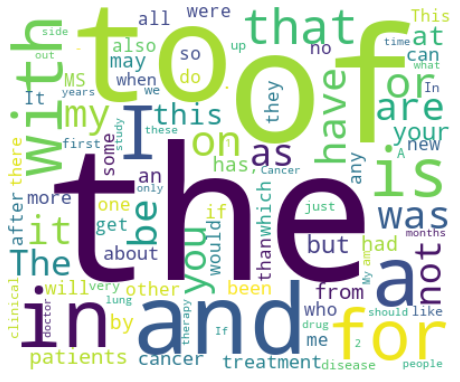

In [66]:
#Generate word cloud

word_freq = gen_freq(train.text.str)

wc = WordCloud(width=400, height=330, max_words=100, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(8,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Wordcloud for test

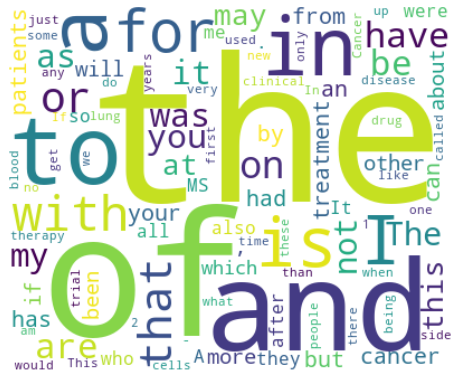

In [67]:
#Generate word cloud

word_freq = gen_freq(test.text.str)

wc = WordCloud(width=400, height=330, max_words=100, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(8,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Preprocessing

In [5]:
punctuation = string.punctuation

stopword = stopwords.words("english")

lem = WordNetLemmatizer()

def _clean(text):
    text = text.lower()
    
    #Remove url links
    text = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', text)
    
    #EMOJIS
    text = re.sub(r":\)","emoji happy",text)
    text = re.sub(r":P","emoji happy",text)
    text = re.sub(r":p","emoji happy",text)
    text = re.sub(r":>","emoji happy",text)
    text = re.sub(r":3","emoji happy",text)
    text = re.sub(r":D","emoji happy",text)
    text = re.sub(r" XD ","emoji happy",text)
    text = re.sub(r" <3 ","emoji happy",text)
    
    text = re.sub(r":\(","emoji sad",text)
    text = re.sub(r":<","emoji sad",text)
    text = re.sub(r":<","emoji sad",text)
    text = re.sub(r">:\(","emoji sad",text)
    
    #text = re.sub(r"\'", "\'", text)
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"dont", "do not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " had", text)
    #text = re.sub(r"\d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    #text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'am", " am", text)
    text = re.sub(r"\n", "", text)    
    text = re.sub(r"\r", "", text)
    text = re.sub(r",", " ", text)
    
    words = text.split()
    words = [w for w in words if w not in stopword]
    text = " ".join(words)
    
    text = "".join(x for x in text if x not in punctuation)
    
    #text = re.sub(r'(([^a-zA-Z0-9]))', ' ', text)
    text = re.sub(r'(([^a-zA-Z]))', ' ', text)
    
    words = text.split()
    words = [w for w in words if len(w)>1]
    text = " ".join(words)
    #cleandata = [' '.join([w for w in x.split() if len(w)>1]) for x in cleandata]
    
    text = re.sub(r'\s+', ' ', text)
    
    words = text.split()
    
    words = [lem.lemmatize(word, "v") for word in words]
    words = [lem.lemmatize(word, "n") for word in words]
    words = [w for w in words if w not in stopword]
    
    text = " ".join(words)
    
    return text

#_clean("This IS A Sample text!!!")
_clean("and is applied to the periphery don't I'am  informing I I've won't you'll of the retina. :) :( There is I'am some good information about injections for macular oedema here:-  http://www.diabeticretinopathy.org.uk/lucentispatientsdr.htm and good 3 information 22 about laser treatment here:-")

'apply periphery inform retina emoji happy emoji sad good information injection macular oedema URL good information laser treatment'

In [6]:
def longWords(text):
    #tokens = [w for w in text.split() if not w in stopword]
    tokens = text.split()
    print(tokens)
    long_words=[]
    for i in tokens:
        #removing short words
        if len(i)>=4:                                                 
            long_words.append(i)
    #print(long_words)
    textJoined = " ".join(long_words) 
    return textJoined

In [140]:
values_drugs = train['drug'].value_counts().loc[lambda x:x>2].index
train[train['drug'].isin(values_drugs)].shape

(5242, 4)

In [24]:
train.shape

(5279, 4)

In [30]:
#values_drugs = train['drug'].value_counts().loc[lambda x:x>1]
values_drugs = train['drug'].value_counts().loc[lambda x:x>1].index
train1 = train[train['drug'].isin(values_drugs)]
train1.shape

(5258, 4)

In [8]:
train['text'][346]

'Thanks for posting :) Your post is of great insight and very helpfull I am also worried because my cd4+ are coming back 129 Cells/ul , 1/2 months after hsct "Btw I have to own I don\'t know what mitigation inhibitors are" I think Md is refering to does Dmts that trap lymphocytes in the lymph nodes (Fingolimod,natalizumab) Ps: correct if i am wrong :) Obrigado Luis'

In [149]:
_clean(train['text'][346])

'thank post emoji happy post great insight helpfull also worry cd come back cellsul month hsct btw know mitigation inhibitor think md refer dmts trap lymphocyte lymph nod fingolimod natalizumab p correct wrong emoji happy obrigado luis'

In [47]:
longWords(_clean(train['text'][346]))

['thank', 'post', 'emoji', 'happy', 'post', 'great', 'insight', 'helpfull', 'also', 'worry', 'cd', 'come', 'back', 'cellsul', 'month', 'hsct', 'btw', 'know', 'mitigation', 'inhibitor', 'think', 'md', 'refer', 'dmts', 'trap', 'lymphocyte', 'lymph', 'nod', 'fingolimod', 'natalizumab', 'p', 'correct', 'wrong', 'emoji', 'happy', 'obrigado', 'luis']


'thank post emoji happy post great insight helpfull also worry come back cellsul month hsct know mitigation inhibitor think refer dmts trap lymphocyte lymph fingolimod natalizumab correct wrong emoji happy obrigado luis'

In [7]:
train['cleaned'] = train['text'].apply(_clean)

In [8]:
train['cleaned'] = train['cleaned'].apply(longWords)

['autoimmune', 'disease', 'tend', 'come', 'cluster', 'gilenya', 'feel', 'good', 'think', 'win', 'change', 'anything', 'waste', 'time', 'energy', 'take', 'tysabri', 'feel', 'amaze', 'symptom', 'dodgy', 'color', 'vision', 'since', 'always', 'know', 'know', 'last', 'month', 'year', 'decade', 'ive', 'decide', 'enjoy', 'ride', 'point', 'worry']
['completely', 'understand', 'want', 'try', 'result', 'report', 'lecture', 'always', 'stand', 'scrutiny', 'peerreview', 'publication', 'much', 'still', 'convince', 'hope', 'work', 'really', 'aware', 'happy', 'risk', 'great', 'think', 'important', 'present', 'balance', 'way', 'understand', 'move', 'straight', 'first', 'show', 'promise', 'animal', 'study', 'use', 'drug', 'human', 'still', 'lot', 'animal', 'data', 'gather', 'human', 'data', 'gather', 'anyone', 'tell', 'safe', 'effective', 'tell', 'many', 'time', 'animal', 'study', 'follow', 'human', 'one', 'major', 'attrition', 'point', 'drug', 'development', 'unpredictability', 'issue', 'cladribinegile

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [143]:
train1['cleaned'] = train1['text'].apply(_clean)

In [144]:
train1['cleaned'] = train1['cleaned'].apply(longWords)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['whole', 'autoimmune', 'system', 'run', 'amok', 'theory', 'never', 'make', 'sense', 'either', 'real', 'reason', 'beyond', 'make', 'sense', 'sudden', 'immune', 'system', 'would', 'want', 'start', 'attack', 'gut', 'develop', 'uc', 'really', 'experience', 'trouble', 'except', 'diverticulitis', 'another', 'really', 'weird', 'disease', 'uc', 'pancolitis', 'dx', 'march', 'partial', 'colectomy', 'diverticulitis', 'sept', 'apriso', 'day', 'canasa', 'uceris', 'foam', 'need', 'supplement', 'zinc', 'lglutamine', 'probiotic', 'reuteri', 'pearl', 'vsl', 'folic', 'acid', 'coq', 'turmeric', 'boswellia', 'milk', 'thistle', 'nac', 'reservatol', 'colostrum', 'glycine', 'start', 'entyvio', 'constant', 'flare', 'since', 'march', 'relieve', 'prednisone']
['hi', 'asgoodasitgets', 'story', 'sound', 'something', 'like', 'mine', 'year', 'age', 'reckon', 'since', 'diagnose', 'age', 'rrms', 'last', 'year', 'tell', 'spms', 'certainly', 'test', 'around', 'fine', 'still', 'walk', 'stick', 'usual', 'problem', 'blad

In [12]:
train.head(1)

unique_hash  \
0  2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0   

                                                                                                                                                                                                                                                                                                                                                                                                                   text  \
0  Autoimmune diseases tend to come in clusters. As for Gilenya – if you feel good, don’t think about it, it won’t change anything but waste your time and energy. I’m taking Tysabri and feel amazing, no symptoms (other than dodgy color vision, but I’ve had it since always, so, don’t know) and I don’t know if it will last a month, a year, a decade, ive just decided to enjoy the ride, no point in worrying.   

      drug  sentiment  \
0  gilenya          2   

                                                                                                                                                                                                                         cleaned  
0  autoimmune disease tend come cluster gilenya feel good think change anything waste time energy take tysabri feel amaze symptom dodgy color vision since always know know last month year decade decide enjoy ride point worry

In [34]:
train1.head(1)

unique_hash  \
0  2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0   

                                                                                                                                                                                                                                                                                                                                                                                                                   text  \
0  Autoimmune diseases tend to come in clusters. As for Gilenya – if you feel good, don’t think about it, it won’t change anything but waste your time and energy. I’m taking Tysabri and feel amazing, no symptoms (other than dodgy color vision, but I’ve had it since always, so, don’t know) and I don’t know if it will last a month, a year, a decade, ive just decided to enjoy the ride, no point in worrying.   

      drug  sentiment  \
0  gilenya          2   

                                                                                                                                                                                                                         cleaned  
0  autoimmune disease tend come cluster gilenya feel good think change anything waste time energy take tysabri feel amaze symptom dodgy color vision since always know know last month year decade decide enjoy ride point worry

In [78]:
train.to_csv('trainCleaned.csv',index=False)

In [145]:
train1.to_csv('trainCleaned1.csv',index=False)

In [9]:
test['cleaned'] = test['text'].apply(_clean)

In [10]:
test['cleaned'] = test['cleaned'].apply(longWords)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
test.head(1)

unique_hash  \
0  9e9a8166b84114aca147bf409f6f956635034c08   

                                                                       text  \
0  256 (previously stable on natalizumab), with 55% switching to fingolimod   

         drug                                          cleaned  
0  fingolimod  previously stable natalizumab switch fingolimod

In [16]:
test['cleaned'][0]

'previously stable natalizumab switch fingolimod'

In [88]:
test.to_csv('testCleaned.csv',index=False)

# EDA

In [84]:
train['drug'].value_counts()

ocrevus            676
gilenya            666
ocrelizumab        441
entyvio            303
humira             270
                  ... 
infliximab-dyyb      1
pf-00547659          1
geftinib             1
alunbrig             1
cyramza              1
Name: drug, Length: 102, dtype: int64

In [85]:
train.sentiment.value_counts()

2    3825
1     837
0     617
Name: sentiment, dtype: int64

In [41]:
train1.sentiment.value_counts()

2    3809
1     833
0     616
Name: sentiment, dtype: int64

## Wordcloud of clean train text

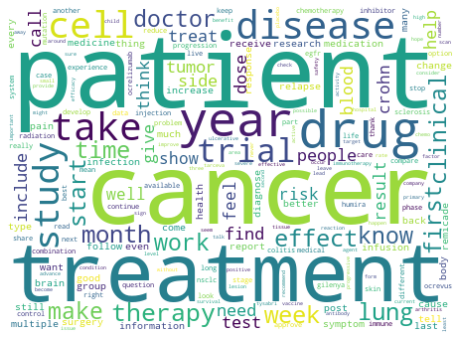

In [86]:
word_freq = gen_freq(train['cleaned'].str)
word_freq = word_freq.drop(labels=STOPWORDS, errors='ignore')

#Generate word cloud
wc = WordCloud(width=450, height=330, max_words=200, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(8, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Wordcloud of clean test text

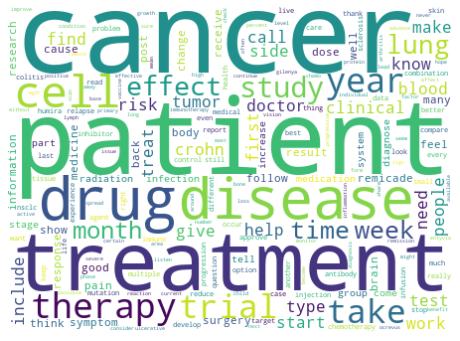

In [87]:
word_freq = gen_freq(test['cleaned'].str)
word_freq = word_freq.drop(labels=STOPWORDS, errors='ignore')

#Generate word cloud
wc = WordCloud(width=450, height=330, max_words=200, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(8, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

<AxesSubplot:xlabel='sentiment', ylabel='count'>

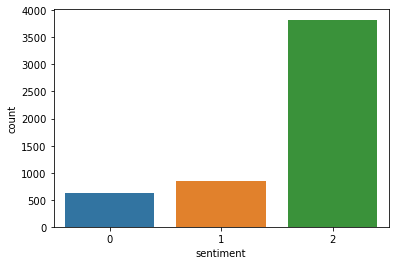

In [41]:
sns.countplot(x='sentiment', data=train)

In [43]:
drugs = train['drug'].value_counts().head(20)
df = pd.DataFrame()
df['xaxis'] = drugs.index
df['yaxis'] = drugs.values
print(df.head(2))

     xaxis  yaxis
0  ocrevus    676
1  gilenya    666


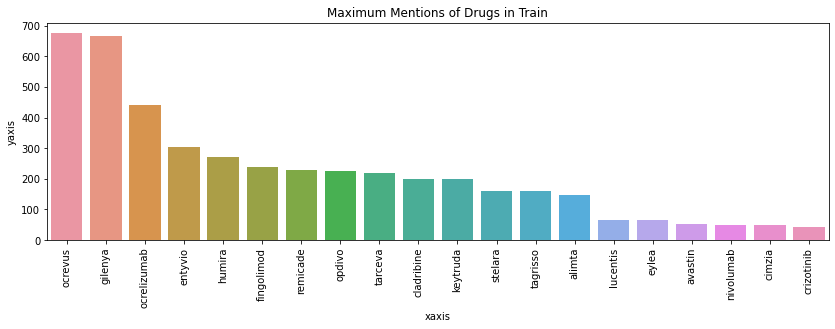

In [44]:
plt.figure(figsize=(14,4))
sns.barplot(x = 'xaxis',y = 'yaxis', data=df)
plt.xticks(rotation=90)
plt.title('Maximum Mentions of Drugs in Train')
plt.show()

In [45]:
drugs = test['drug'].value_counts().head(20)
df = pd.DataFrame()
df['xaxis'] = drugs.index
df['yaxis'] = drugs.values
print(df.head(2))

     xaxis  yaxis
0  gilenya    311
1  ocrevus    302


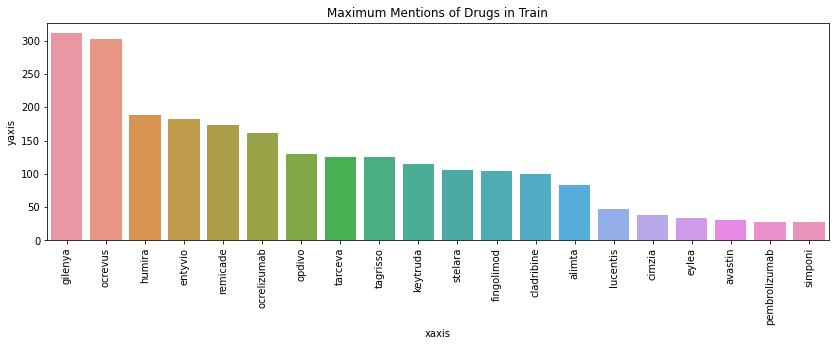

In [46]:
plt.figure(figsize=(14,4))
sns.barplot(x = 'xaxis',y = 'yaxis', data=df)
plt.xticks(rotation=90)
plt.title('Maximum Mentions of Drugs in Train')
plt.show()

In [88]:
# function to plot top 30 most frequent words
def freq_words(x,t = 'Common Words'):
    terms = 30
    # combine all the articles  
    text = ' '.join([text for text in x])
    # split text into words   
    all_words = text.split()
    
    # prepare a dictionary of word-frequency pairs
    fdist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top n most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    
    # plot the word counts  
    plt.figure(figsize=(14,4))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.title(t)
    plt.xticks(rotation=90)
    plt.show()

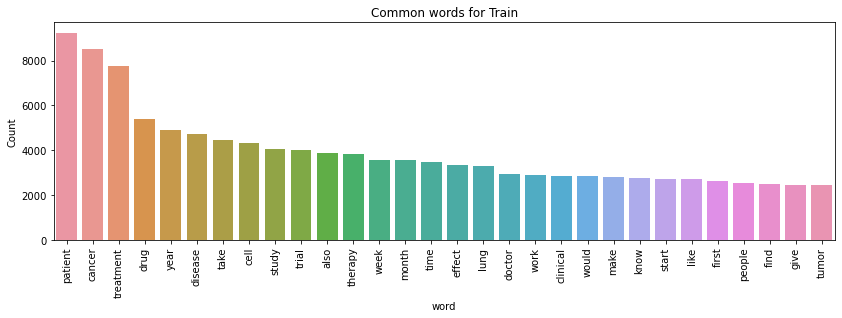

In [89]:
freq_words(train['cleaned'],'Common words for Train')

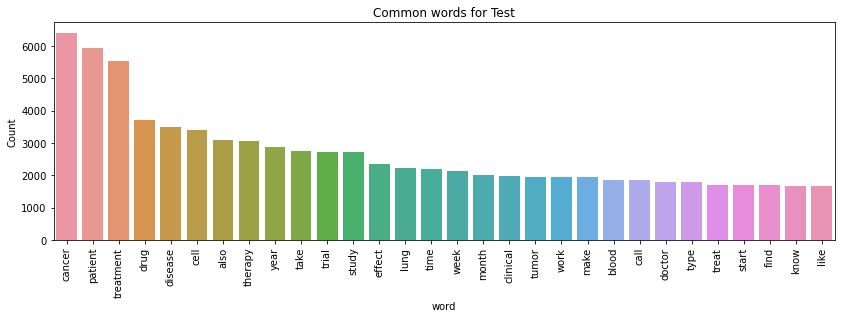

In [90]:
freq_words(test['cleaned'],'Common words for Test')

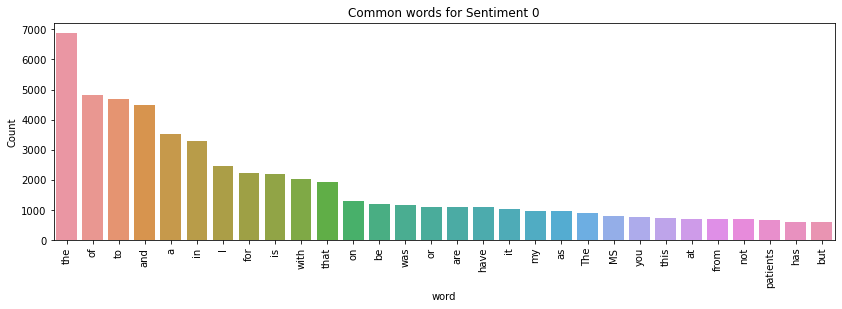

In [91]:
freq_words(train[train['sentiment'] == 0]['text'],'Common words for Sentiment 0')

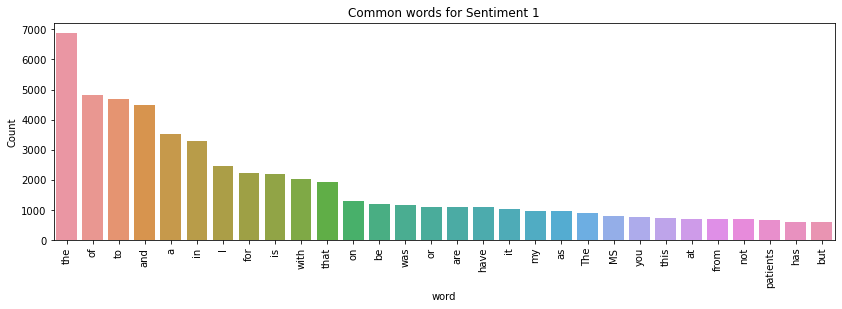

In [92]:
freq_words(train[train['sentiment'] == 0]['text'],'Common words for Sentiment 1')

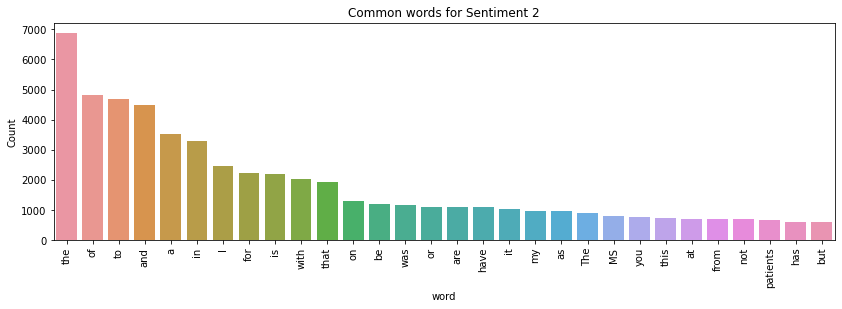

In [93]:
freq_words(train[train['sentiment'] == 0]['text'],'Common words for Sentiment 2')

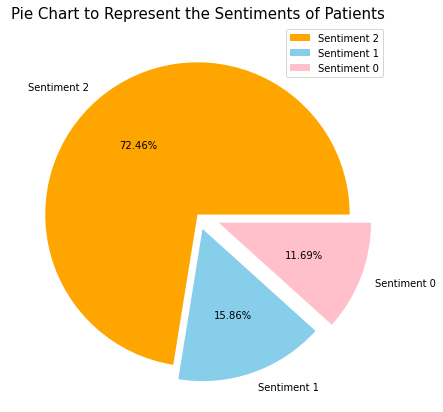

In [94]:
# a pie chart to represent the sentiments of the patients

size = [3825, 837, 617]
colors = ['orange', 'skyblue','pink']
labels = "Sentiment 2","Sentiment 1","Sentiment 0"
explode = [0, 0.1,0.15]

plt.rcParams['figure.figsize'] = (7, 7)
plt.pie(size, colors = colors, labels = labels, explode = explode, autopct = '%.2f%%')
plt.axis('off')
plt.title('Pie Chart to Represent the Sentiments of Patients', fontsize = 15)
plt.legend()
plt.show()

# Upsamplying Data
## Imbalanced classes - data related to neutral sentiments is more than positive & negative sentiments

In [11]:
# separating classes based on sentiments 
from sklearn.utils import resample
# minority classes
positive = train[train.sentiment==0]
negative = train[train.sentiment==1]
# majority class
neutral = train[train.sentiment==2]

# upsampling positive sentiments minority class
positive_upsampled = resample(positive,
                          replace=True, # sample with replacement
                          n_samples=len(neutral), # match number in majority class
                          random_state=27) # reproducible results

# upsampling negative sentiments minority class
negative_upsampled = resample(negative,
                          replace=True, # sample with replacement
                          n_samples=len(neutral), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority classes
upsampled_npn = pd.concat([neutral, positive_upsampled,negative_upsampled])

In [147]:
# separating classes based on sentiments 
# value_counts > 1
from sklearn.utils import resample
# minority classes
positive = train1[train1.sentiment==0]
negative = train1[train1.sentiment==1]
# majority class
neutral = train1[train1.sentiment==2]

# upsampling positive sentiments minority class
positive_upsampled = resample(positive,
                          replace=True, # sample with replacement
                          n_samples=len(neutral), # match number in majority class
                          random_state=27) # reproducible results

# upsampling negative sentiments minority class
negative_upsampled = resample(negative,
                          replace=True, # sample with replacement
                          n_samples=len(neutral), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority classes
upsampled_npn = pd.concat([neutral, positive_upsampled,negative_upsampled])

In [12]:
upsampled_npn.shape, positive_upsampled.shape, positive.shape, negative_upsampled.shape, negative.shape,neutral.shape

((11475, 5), (3825, 5), (617, 5), (3825, 5), (837, 5), (3825, 5))

In [44]:
upsampled_npn.shape, positive_upsampled.shape, positive.shape, negative_upsampled.shape, negative.shape,neutral.shape

((11427, 5), (3809, 5), (616, 5), (3809, 5), (833, 5), (3809, 5))

In [13]:
upsampled_npn["sentiment"].value_counts()

2    3825
0    3825
1    3825
Name: sentiment, dtype: int64

In [45]:
upsampled_npn["sentiment"].value_counts()

2    3809
0    3809
1    3809
Name: sentiment, dtype: int64

In [159]:
upsampled_npn.head(1)

unique_hash  \
0  2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0   

                                                                                                                                                                                                                                                                                                                                                                                                                   text  \
0  Autoimmune diseases tend to come in clusters. As for Gilenya – if you feel good, don’t think about it, it won’t change anything but waste your time and energy. I’m taking Tysabri and feel amazing, no symptoms (other than dodgy color vision, but I’ve had it since always, so, don’t know) and I don’t know if it will last a month, a year, a decade, ive just decided to enjoy the ride, no point in worrying.   

      drug  sentiment  \
0  gilenya          2   

                                                                                                                                                                                                                         cleaned  
0  autoimmune disease tend come cluster gilenya feel good think change anything waste time energy take tysabri feel amaze symptom dodgy color vision since always know know last month year decade decide enjoy ride point worry

In [14]:
neutral_downsampled = resample(neutral,
                                replace = False, # sample without replacement
                                n_samples = len(positive), # match minority n
                                random_state = 27) # reproducible results

In [15]:
# combine majority and upsampled minority
upsampled_npn = pd.concat([neutral_downsampled,negative_upsampled ,positive_upsampled])
upsampled_npn.shape

(8267, 5)

In [47]:
# combine majority and upsampled minority
upsampled_npn = pd.concat([neutral_downsampled,negative_upsampled ,positive_upsampled])
upsampled_npn.shape

(8234, 5)

In [16]:
upsampled_npn['sentiment'].value_counts()

1    3825
0    3825
2     617
Name: sentiment, dtype: int64

In [48]:
upsampled_npn['sentiment'].value_counts()

1    3809
0    3809
2     616
Name: sentiment, dtype: int64

# Feature Engineering

In [17]:
# Meta features 

# word count for train
upsampled_npn["word_count"] = upsampled_npn["text"].apply(lambda x : len(x.split()))
train["word_count"] = train["text"].apply(lambda x : len(x.split()))
#train["word_count"] = train["cleaned"].apply(lambda x : len(x.split()))

# char count for train
upsampled_npn["char_count"] = upsampled_npn["text"].apply(lambda x : len(x))
upsampled_npn["char_count_without_spaces"] = upsampled_npn["text"].apply(lambda x : len(x.replace(" ","")))
train["char_count"] = train["text"].apply(lambda x : len(x))
train["char_count_without_spaces"] = train["text"].apply(lambda x : len(x.replace(" ","")))

# word count for test
test["word_count"] = test["text"].apply(lambda x : len(x.split()))
#test["word_count"] = test["cleaned"].apply(lambda x : len(x.split()))

# char count for test
test["char_count"] = test["text"].apply(lambda x : len(x))
test["char_count_without_spaces"] = test["text"].apply(lambda x : len(x.replace(" ","")))

#  no. of digits
# for sentiment analysis numbers don't have much impact
#train["num_dig"] = train["text"].apply(lambda x :  sum([1 if w.isdigit() else 0 for w in x.split()]))

In [18]:
pos_dic = {"noun" : ["NNP", "NN", "NNS", "NNPS"], "verb" : ["VBZ", "VB", "VBD","VBG", "VBN"]}
import nltk
def pos_check(txt, family):
    tags = nltk.pos_tag(nltk.word_tokenize(txt))
    count = 0
    for tag in tags:
        tag = tag[1]
        if tag in pos_dic[family]:
            count += 1 
    return count

upsampled_npn["noun_count"] = upsampled_npn["text"].apply(lambda x : pos_check(x, "noun"))
upsampled_npn["verb_count"] = upsampled_npn["text"].apply(lambda x : pos_check(x, "verb"))
train["noun_count"] = train["text"].apply(lambda x : pos_check(x, "noun"))
train["verb_count"] = train["text"].apply(lambda x : pos_check(x, "verb"))
test["noun_count"] = test["text"].apply(lambda x : pos_check(x, "noun"))
test["verb_count"] = test["text"].apply(lambda x : pos_check(x, "verb"))

In [154]:
# word count for train
train1["word_count"] = train1["text"].apply(lambda x : len(x.split()))
#train["word_count"] = train["cleaned"].apply(lambda x : len(x.split()))

# char count for train
train1["char_count"] = train1["text"].apply(lambda x : len(x))
train1["char_count_without_spaces"] = train1["text"].apply(lambda x : len(x.replace(" ","")))

In [19]:
upsampled_npn.to_csv('upsampled_npnMeta.csv',index=False)

In [20]:
train.to_csv('trainMeta.csv',index=False)

In [52]:
train1.to_csv('trainMeta1.csv',index=False)

In [21]:
test.to_csv('testMeta.csv',index=False)

In [53]:
test1.to_csv('testMeta1.csv',index=False)

In [3]:
train = pd.read_csv("trainMeta.csv")
train.head(1)

unique_hash  \
0  2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0   

                                                                                                                                                                                                                                                                                                                                                                                                                   text  \
0  Autoimmune diseases tend to come in clusters. As for Gilenya – if you feel good, don’t think about it, it won’t change anything but waste your time and energy. I’m taking Tysabri and feel amazing, no symptoms (other than dodgy color vision, but I’ve had it since always, so, don’t know) and I don’t know if it will last a month, a year, a decade, ive just decided to enjoy the ride, no point in worrying.   

      drug  sentiment  \
0  gilenya          2   

                                                                                                                                                                                                                         cleaned  \
0  autoimmune disease tend come cluster gilenya feel good think change anything waste time energy take tysabri feel amaze symptom dodgy color vision since always know know last month year decade decide enjoy ride point worry   

   word_count  char_count  char_count_without_spaces  noun_count  verb_count  
0          76         404                        329          26           8

In [4]:
test = pd.read_csv("testMeta.csv")
test.head(1)

unique_hash  \
0  9e9a8166b84114aca147bf409f6f956635034c08   

                                                                       text  \
0  256 (previously stable on natalizumab), with 55% switching to fingolimod   

         drug                                          cleaned  word_count  \
0  fingolimod  previously stable natalizumab switch fingolimod          10   

   char_count  char_count_without_spaces  noun_count  verb_count  
0          72                         63           2           3

In [5]:
upsampled_npn = pd.read_csv("upsampled_npnMeta.csv")
upsampled_npn.head(1)

unique_hash  \
0  7ec25f3e8ac304ae4a75308f5bbcfd78db45caaf   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               text  \
0  Hi, I haven't taken Keytruda but am on opdivo and they are very similar. First off, your mom is stage 4 because it has traveled to another organ and at this time the standards of treatment is no surgery. BUT do not let that get you to far down because immunotherapy can get rid of the cancer or keep her stable for a long time. Everybody experiences different side effects at varying times and severity, no two are really the same. When I first started immunotherapy I had a runny nose and eyes for about 3 hours every morning, after about 6 weeks this went away, then I had knee pain, again this later went away. Now at almost three years of taking immunotherapy I am experiencing fatigue and I am cold all the time. I can't wait for this to subside also. Severe heartburn hit at about a year on the drug so I take over the counter Zantac twice a day. Others have has rash that sometimes itches, diarrhea that required medication to calm down. A few people gave had fevers and flu symptoms after their infusions for about four episodes then it went away. Things to report: ANY shortness of breath, abdominal pain, diarrhea. Good luck to your mom. Woodburn, I am out of likes but this is super encouraging (DH starts Keytruda this week). Thank you!   

       drug  sentiment  \
0  keytruda          2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  cleaned  \
0  take keytruda opdivo similar first stage travel another organ time standard treatment surgery immunotherapy cancer keep stable long time everybody experience different side effect vary time severity really first start immunotherapy runny nose hour every morning week away knee pain later away almost three year take immunotherapy experience fatigue cold time wait subside also severe heartburn year drug take counter zantac twice others rash sometimes itch diarrhea require medication calm people give fever symptom infusion four episode away thing report shortness breath abdominal pain diarrhea good luck woodburn like super encourage start keytruda week thank   

   word_count  char_count  char_co

In [196]:
#dfData = pd.read_csv('upsampled_npnMeta.csv')
dfData = upsampled_npn.copy()
dfData.head(1)

unique_hash  \
2075  7ec25f3e8ac304ae4a75308f5bbcfd78db45caaf   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  text  \
2075  Hi, I haven't taken Keytruda but am on opdivo and they are very similar. First off, your mom is stage 4 because it has traveled to another organ and at this time the standards of treatment is no surgery. BUT do not let that get you to far down because immunotherapy can get rid of the cancer or keep her stable for a long time. Everybody experiences different side effects at varying times and severity, no two are really the same. When I first started immunotherapy I had a runny nose and eyes for about 3 hours every morning, after about 6 weeks this went away, then I had knee pain, again this later went away. Now at almost three years of taking immunotherapy I am experiencing fatigue and I am cold all the time. I can't wait for this to subside also. Severe heartburn hit at about a year on the drug so I take over the counter Zantac twice a day. Others have has rash that sometimes itches, diarrhea that required medication to calm down. A few people gave had fevers and flu symptoms after their infusions for about four episodes then it went away. Things to report: ANY shortness of breath, abdominal pain, diarrhea. Good luck to your mom. Woodburn, I am out of likes but this is super encouraging (DH starts Keytruda this week). Thank you!   

          drug  sentiment  \
2075  keytruda          2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     cleaned  \
2075  take keytruda opdivo similar first stage travel another organ time standard treatment surgery immunotherapy cancer keep stable long time everybody experience different side effect vary time severity really first start immunotherapy runny nose hour every morning week away knee pain later away almost three year take immunotherapy experience fatigue cold time wait subside also severe heartburn year drug take counter zantac twice others rash sometimes itch diarrhea require medication calm people give fever symptom infusion four episode away thing report shortness breath abdominal pain diarrhea good luck woodburn like super encourage start keytruda week thank   

      word_co

In [155]:
#test.head(1)

In [154]:
#upsampled_npn.head(1)

## One-Hot Encoding and Vectorization

### Training dataset

In [6]:
# one-hot encoding of gene(drug) feature
gene_vectorizer = TfidfVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(upsampled_npn['drug'])

In [7]:
text_vectorizer = TfidfVectorizer(analyzer='word')
train_text_feature_onehotCoding = text_vectorizer.fit_transform(upsampled_npn['cleaned'])

In [8]:
# normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)
x = train_text_feature_onehotCoding

In [9]:
train_x_onehotCoding = hstack((train_text_feature_onehotCoding, train_gene_feature_onehotCoding)).tocsr()
x1 = train_x_onehotCoding
y = np.array(list(upsampled_npn['sentiment']))

### Test dataset

In [10]:
# one-hot encoding of gene(drug) feature for test dataset
test_gene_feature_onehotCoding = gene_vectorizer.transform(test['drug'])

In [11]:
test_text_feature_onehotCoding = text_vectorizer.transform(test['cleaned'])

In [12]:
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)
xtest = test_text_feature_onehotCoding

In [13]:
test_x_onehotCoding = hstack((test_text_feature_onehotCoding, test_gene_feature_onehotCoding)).tocsr()
xtest1 = test_x_onehotCoding

In [14]:
train_gene_feature_onehotCoding.shape

(8267, 82)

In [15]:
test_gene_feature_onehotCoding.shape

(2924, 82)

In [16]:
train_text_feature_onehotCoding.shape

(8267, 17316)

In [17]:
test_text_feature_onehotCoding.shape

(2924, 17316)

## Train Test Splits

In [18]:
train_x,test_x,train_y,test_y = train_test_split(x,y, random_state = 101, stratify=y)

In [19]:
train_x1,test_x1,train_y1,test_y1 = train_test_split(x1,y, random_state = 101, stratify=y)

# Applying Models

## ========================== Decision Tree Classifier ==========================

### when x = one_hot_encoding of train_text_feature

In [36]:
dt = DecisionTreeClassifier()

In [37]:
dt.fit(train_x,train_y)

DecisionTreeClassifier()

In [140]:
y_pred = dt.predict(test_x)
y_true = test_y
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       956
           1       0.84      0.98      0.91       957
           2       0.98      0.66      0.79       956

    accuracy                           0.88      2869
   macro avg       0.89      0.88      0.87      2869
weighted avg       0.89      0.88      0.87      2869



In [38]:
# upsampled
y_pred = dt.predict(test_x)
y_true = test_y
#print(classification_report(y_true,y_pred))

In [141]:
# Computing Model Accuracy
print("================================== Decision Tree Classifier ==================================")
print("Accuracy:",round(accuracy_score(test_y, y_pred),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y, y_pred))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y, y_pred,target_names =target_names))

================================== Decision Tree Classifier ==================================
Accuracy: 88.0 %
---------------
Confusion matrix
---------------
[[949   5   2]
 [  6 942   9]
 [149 177 630]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.86      0.99      0.92       956
  Sentiment1       0.84      0.98      0.91       957
  Sentiment2       0.98      0.66      0.79       956

    accuracy                           0.88      2869
   macro avg       0.89      0.88      0.87      2869
weighted avg       0.89      0.88      0.87      2869



In [39]:
# upsampled
# Computing Model Accuracy
print("================================== Decision Tree Classifier ==================================")
print("Accuracy:",round(accuracy_score(test_y, y_pred),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y, y_pred))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y, y_pred,target_names =target_names))

================================== Decision Tree Classifier ==================================
Accuracy: 93.0 %
---------------
Confusion matrix
---------------
[[952   4   0]
 [  4 947   6]
 [ 61  63  30]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.94      1.00      0.97       956
  Sentiment1       0.93      0.99      0.96       957
  Sentiment2       0.83      0.19      0.32       154

    accuracy                           0.93      2067
   macro avg       0.90      0.73      0.75      2067
weighted avg       0.93      0.93      0.91      2067



In [142]:
print("F1-score macro = ",f1_score(test_y1,y_pred,average='macro'))
print("F1-score micro = ",f1_score(test_y1,y_pred,average='micro'))
print("F1-score weighted = ",f1_score(test_y1,y_pred,average='weighted'))

F1-score macro =  0.8718908445357956
F1-score micro =  0.8787033809689787
F1-score weighted =  0.8719025012557382


### For x having both train_text_feature_onehotCoding & train_gene_feature_onehotCoding

In [29]:
dt1 = DecisionTreeClassifier()

In [30]:
dt1.fit(train_x1,train_y1)

DecisionTreeClassifier()

In [118]:
y_pred1 = dt1.predict(test_x1)

In [136]:
# Computing Model Accuracy
print("================================== Decision Tree Classifier ==================================")
print("Accuracy:",round(accuracy_score(test_y1, y_pred1),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y1, y_pred1))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y1, y_pred1,target_names =target_names))

================================== Decision Tree Classifier ==================================
Accuracy: 88.0 %
---------------
Confusion matrix
---------------
[[954   0   2]
 [  3 939  15]
 [158 180 618]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.86      1.00      0.92       956
  Sentiment1       0.84      0.98      0.90       957
  Sentiment2       0.97      0.65      0.78       956

    accuracy                           0.88      2869
   macro avg       0.89      0.88      0.87      2869
weighted avg       0.89      0.88      0.87      2869



#### Apparently both give same f1 scores & accuracies

### Hyperparameter tuning using RandomSearchCV

In [107]:
parameter_grid = {
    'max_depth' : [4,5,6,7,8,9],
    'max_features': [0.3,0.5, 0.7,0.9]
    }

In [110]:
dt2 = DecisionTreeClassifier()
dt2.fit(train_x1,train_y1)
y_pred2 = dt1.predict(test_x1)
y_true2 = test_y1

In [135]:
# Computing Model Accuracy
print("================================== Decision Tree Classifier ==================================")
print("Accuracy:",round(accuracy_score(test_y1, y_pred2),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y1, y_pred2))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y1, y_pred2,target_names =target_names))

================================== Decision Tree Classifier ==================================
Accuracy: 88.0 %
---------------
Confusion matrix
---------------
[[954   0   2]
 [  3 939  15]
 [158 180 618]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.86      1.00      0.92       956
  Sentiment1       0.84      0.98      0.90       957
  Sentiment2       0.97      0.65      0.78       956

    accuracy                           0.88      2869
   macro avg       0.89      0.88      0.87      2869
weighted avg       0.89      0.88      0.87      2869



In [112]:
randomsearch = RandomizedSearchCV(estimator=dt2, param_distributions=parameter_grid, n_iter= 10, cv=5)
randomsearch.fit(train_x1, train_y1)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'max_depth': [4, 5, 6, 7, 8, 9],
                                        'max_features': [0.3, 0.5, 0.7, 0.9]})

In [113]:
randomsearch.best_params_

{'max_features': 0.5, 'max_depth': 9}

In [115]:
dt2 = DecisionTreeClassifier(max_features= 0.5, max_depth = 9)
dt2.fit(train_x1,train_y1)
y_pred2 = dt1.predict(test_x1)

In [134]:
# Computing Model Accuracy
print("================================== Decision Tree Classifier ==================================")
print("Accuracy:",round(accuracy_score(test_y1, y_pred2),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y1, y_pred2))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y1, y_pred2,target_names =target_names))

================================== Decision Tree Classifier ==================================
Accuracy: 88.0 %
---------------
Confusion matrix
---------------
[[954   0   2]
 [  3 939  15]
 [158 180 618]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.86      1.00      0.92       956
  Sentiment1       0.84      0.98      0.90       957
  Sentiment2       0.97      0.65      0.78       956

    accuracy                           0.88      2869
   macro avg       0.89      0.88      0.87      2869
weighted avg       0.89      0.88      0.87      2869



In [151]:
print("F1-score macro = ",(round(f1_score(test_y1,y_pred2,average='macro'),2))*100,"%")
print("F1-score micro = ",(round(f1_score(test_y1,y_pred2,average='micro'),2))*100,"%")
print("F1-score weighted = ",(round(f1_score(test_y1,y_pred2,average='weighted'),2))*100,"%")

F1-score macro =  87.0 %
F1-score micro =  88.0 %
F1-score weighted =  87.0 %


### So best F1 scores & accuracy are 87% & 88%

## ======================== Support Vector Classifier ===========================

### when x = one_hot_encoding of train_text_feature

In [168]:
# Same positive, negative, neutral

In [43]:
#modelSvcXfull = svm.SVC(kernel='rbf',gamma=1,C= 1)
modelSvcXfull = svm.SVC()
modelSvcXfull.fit(train_x, train_y)
predsSvcXfull = modelSvcXfull.predict(test_x)
#accuracy_score(preds, valy)

In [212]:
#upsampled
# Computing Model Accuracy
print("================================== Support Vector Classifier ==================================")
print("Accuracy:",round(accuracy_score(test_y, predsSvcXfull),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y, predsSvcXfull))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y, predsSvcXfull,target_names =target_names))

================================== Support Vector Classifier ==================================
Accuracy: 95.0 %
---------------
Confusion matrix
---------------
[[949   7   0]
 [ 13 937   7]
 [ 21  55  78]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.97      0.99      0.98       956
  Sentiment1       0.94      0.98      0.96       957
  Sentiment2       0.92      0.51      0.65       154

    accuracy                           0.95      2067
   macro avg       0.94      0.83      0.86      2067
weighted avg       0.95      0.95      0.94      2067



In [42]:
#0.4024

# Computing Model Accuracy
print("================================== Support Vector Classifier ==================================")
print("Accuracy:",round(accuracy_score(test_y, predsSvcXfull),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y, predsSvcXfull))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y, predsSvcXfull,target_names =target_names))

================================== Support Vector Classifier ==================================
Accuracy: 95.0 %
---------------
Confusion matrix
---------------
[[949   7   0]
 [ 13 937   7]
 [ 21  55  78]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.97      0.99      0.98       956
  Sentiment1       0.94      0.98      0.96       957
  Sentiment2       0.92      0.51      0.65       154

    accuracy                           0.95      2067
   macro avg       0.94      0.83      0.86      2067
weighted avg       0.95      0.95      0.94      2067



In [172]:
print("F1-score macro = ",f1_score(test_y,predsSvcXfull,average='macro'))
print("F1-score micro = ",f1_score(test_y,predsSvcXfull,average='micro'))
print("F1-score weighted = ",f1_score(test_y,predsSvcXfull,average='weighted'))

F1-score macro =  0.9096622153821494
F1-score micro =  0.911467410247473
F1-score weighted =  0.9096705602527952


In [213]:
#0.4024
# upsmapled
print("F1-score macro = ",f1_score(test_y,predsSvcXfull,average='macro'))
print("F1-score micro = ",f1_score(test_y,predsSvcXfull,average='micro'))
print("F1-score weighted = ",f1_score(test_y,predsSvcXfull,average='weighted'))

F1-score macro =  0.8632174849405102
F1-score micro =  0.9501693275278181
F1-score weighted =  0.944936939028001


In [70]:
#0.4024
# upsmapled value_counts>1
print("F1-score macro = ",f1_score(test_y,predsSvcXfull,average='macro'))
print("F1-score micro = ",f1_score(test_y,predsSvcXfull,average='micro'))
print("F1-score weighted = ",f1_score(test_y,predsSvcXfull,average='weighted'))

F1-score macro =  0.8600846850113828
F1-score micro =  0.9490043710539097
F1-score weighted =  0.944434409595855


In [71]:
param_gridSvcX = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']
              }

randomsearchfull = RandomizedSearchCV(estimator=modelSvcXfull, param_distributions=param_gridSvcX, n_iter= 10, cv=5)
randomsearchfull.fit(train_x, train_y)

RandomizedSearchCV(cv=5, estimator=SVC(),
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf']})

In [214]:
#upsampling
# score 0.41
param_gridSvcX = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']
              }

randomsearch = RandomizedSearchCV(estimator=modelSvcXfull, param_distributions=param_gridSvcX, n_iter= 15, cv=10)
randomsearch.fit(train_x, train_y)

RandomizedSearchCV(cv=10, estimator=SVC(), n_iter=15,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf']})

In [56]:
#upsampling

param_gridSvcX = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']
              }

randomsearch = RandomizedSearchCV(estimator=modelSvcXfull, param_distributions=param_gridSvcX, n_iter= 30, cv=15)
randomsearch.fit(train_x, train_y)

RandomizedSearchCV(cv=15, estimator=SVC(), n_iter=30,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf']})

In [57]:
randomsearch.best_params_

{'kernel': 'rbf', 'gamma': 1, 'C': 1}

In [50]:
# upsampled
#randomsearch = RandomizedSearchCV(estimator=modelSvcXfull, param_distributions=param_gridSvcX, n_iter= 15, cv=15)
#{'kernel': 'rbf', 'gamma': 1, 'C': 1}
modelSvcX = svm.SVC(kernel='rbf',gamma=1,C= 1)
#modelSvcX = svm.SVC()
modelSvcX.fit(train_x, train_y)
predsSvcX = modelSvcX.predict(test_x)

In [51]:
# upsampled
#randomsearch = RandomizedSearchCV(estimator=modelSvcXfull, param_distributions=param_gridSvcX, n_iter= 15, cv=15)
#{'kernel': 'rbf', 'gamma': 1, 'C': 1}
# Computing Model Accuracy
print("================================== Support Vector Classifier ==================================")
print("Accuracy:",round(accuracy_score(test_y, predsSvcX),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y, predsSvcX))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y, predsSvcX,target_names =target_names))

================================== Support Vector Classifier ==================================
Accuracy: 96.0 %
---------------
Confusion matrix
---------------
[[953   3   0]
 [  4 943  10]
 [ 13  51  90]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.98      1.00      0.99       956
  Sentiment1       0.95      0.99      0.97       957
  Sentiment2       0.90      0.58      0.71       154

    accuracy                           0.96      2067
   macro avg       0.94      0.86      0.89      2067
weighted avg       0.96      0.96      0.96      2067



In [75]:
# 0.4024
# upsampled > 1
modelSvcX = svm.SVC(kernel='rbf',gamma=1,C= 100)
#modelSvcX = svm.SVC()
modelSvcX.fit(train_x, train_y)
predsSvcX = modelSvcX.predict(test_x)

In [76]:
#0.4024
# Computing Model Accuracy
print("================================== Support Vector Classifier ==================================")
print("Accuracy:",round(accuracy_score(test_y, predsSvcX),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y, predsSvcX))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y, predsSvcX,target_names =target_names))

================================== Support Vector Classifier ==================================
Accuracy: 96.0 %
---------------
Confusion matrix
---------------
[[934   3  15]
 [  1 944   8]
 [  8  50  96]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.99      0.98      0.99       952
  Sentiment1       0.95      0.99      0.97       953
  Sentiment2       0.81      0.62      0.70       154

    accuracy                           0.96      2059
   macro avg       0.91      0.87      0.89      2059
weighted avg       0.96      0.96      0.96      2059



In [24]:
# score 0.41
# no value_count>1
#randomsearch = RandomizedSearchCV(estimator=modelSvcXfull, param_distributions=param_gridSvcX, n_iter= 15, cv=10)
# 'kernel': 'rbf', 'gamma': 0.1, 'C': 10}
modelSvcX = svm.SVC(kernel='rbf',gamma=1,C= 10)
#modelSvcX = svm.SVC()
modelSvcX.fit(train_x, train_y)
predsSvcX = modelSvcX.predict(test_x)

In [25]:
# score 0.41
#randomsearch = RandomizedSearchCV(estimator=modelSvcXfull, param_distributions=param_gridSvcX, n_iter= 15, cv=10)
# Computing Model Accuracy
print("================================== Support Vector Classifier ==================================")
print("Accuracy:",round(accuracy_score(test_y, predsSvcX),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y, predsSvcX))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y, predsSvcX,target_names =target_names))

================================== Support Vector Classifier ==================================
Accuracy: 96.0 %
---------------
Confusion matrix
---------------
[[951   5   0]
 [  2 945  10]
 [ 12  49  93]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.99      0.99      0.99       956
  Sentiment1       0.95      0.99      0.97       957
  Sentiment2       0.90      0.60      0.72       154

    accuracy                           0.96      2067
   macro avg       0.94      0.86      0.89      2067
weighted avg       0.96      0.96      0.96      2067



In [350]:
predictionsTestSvcX = modelSvcX.predict(xtest)
predictionsTestSvcX

array([1, 1, 1, ..., 2, 1, 1])

In [26]:
# 'kernel': 'rbf', 'gamma': 1, 'C': 10}
predictionsTestSvcX = modelSvcX.predict(xtest)
predictionsTestSvcX

array([1, 1, 1, ..., 2, 1, 1])

In [218]:
# 'kernel': 'rbf', 'gamma': 0.1, 'C': 10}
predictionsTestSvcX = modelSvcX.predict(xtest)
predictionsTestSvcX

array([1, 1, 1, ..., 2, 1, 1])

In [98]:
#0.4024
#upsampled
#value_counts > 1
predictionsTestSvcX = modelSvcX.predict(xtest)
predictionsTestSvcX

array([1, 1, 1, ..., 2, 2, 2])

In [52]:
# upsampled
#randomsearch = RandomizedSearchCV(estimator=modelSvcXfull, param_distributions=param_gridSvcX, n_iter= 15, cv=15)
#{'kernel': 'rbf', 'gamma': 1, 'C': 1}
predictionsTestSvcX = modelSvcX.predict(xtest)
predictionsTestSvcX

array([1, 1, 1, ..., 2, 1, 1])

In [27]:
# upsampled value_counts>1
dfinalsvcx = pd.DataFrame(columns=['id','sentiment'])
dfinalsvcx['id'] = test['unique_hash']
dfinalsvcx['sentiment'] = predictionsTestSvcX
dfinalsvcx['sentiment'].value_counts()

2    1497
1    1124
0     303
Name: sentiment, dtype: int64

In [219]:
#randomsearch = RandomizedSearchCV(estimator=modelSvcXfull, param_distributions=param_gridSvcX, n_iter= 15, cv=10)
#score 0.41
dfinalsvcx = pd.DataFrame(columns=['id','sentiment'])
dfinalsvcx['id'] = test['unique_hash']
dfinalsvcx['sentiment'] = predictionsTestSvcX
dfinalsvcx['sentiment'].value_counts()

2    1497
1    1124
0     303
Name: sentiment, dtype: int64

In [53]:
# upsampled
#randomsearch = RandomizedSearchCV(estimator=modelSvcXfull, param_distributions=param_gridSvcX, n_iter= 15, cv=15)
#{'kernel': 'rbf', 'gamma': 1, 'C': 1}
dfinalsvcx = pd.DataFrame(columns=['id','sentiment'])
dfinalsvcx['id'] = test['unique_hash']
dfinalsvcx['sentiment'] = predictionsTestSvcX
dfinalsvcx['sentiment'].value_counts()

2    1548
1    1059
0     317
Name: sentiment, dtype: int64

In [54]:
dfinalsvcx.head(1)

id  sentiment
0  9e9a8166b84114aca147bf409f6f956635034c08          1

In [28]:
dfinalsvcx.to_csv("sample_submision_finalsvcx.csv",index=0)

### SVC xtest score 0.40

In [174]:
randomsearchfull.best_params_

{'kernel': 'rbf', 'gamma': 1, 'C': 100}

In [175]:
modelSvcXfull = svm.SVC(kernel='rbf',gamma=1,C= 100)
#modelSvcXfull = svm.SVC()
modelSvcXfull.fit(train_x, train_y)
predsSvcXfull = modelSvcXfull.predict(test_x)
#accuracy_score(preds, valy)

In [176]:
# Computing Model Accuracy
print("================================== Support Vector Classifier ==================================")
print("Accuracy:",round(accuracy_score(test_y, predsSvcXfull),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y, predsSvcXfull))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y, predsSvcXfull,target_names =target_names))

================================== Support Vector Classifier ==================================
Accuracy: 97.0 %
---------------
Confusion matrix
---------------
[[949   0   7]
 [  0 938  19]
 [ 24  26 906]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.98      0.99      0.98       956
  Sentiment1       0.97      0.98      0.98       957
  Sentiment2       0.97      0.95      0.96       956

    accuracy                           0.97      2869
   macro avg       0.97      0.97      0.97      2869
weighted avg       0.97      0.97      0.97      2869



In [177]:
print("F1-score macro = ",f1_score(test_y,predsSvcXfull,average='macro'))
print("F1-score micro = ",f1_score(test_y,predsSvcXfull,average='micro'))
print("F1-score weighted = ",f1_score(test_y,predsSvcXfull,average='weighted'))

F1-score macro =  0.9734166535124591
F1-score micro =  0.9735099337748344
F1-score weighted =  0.9734177542608606


In [77]:
modelSvcX = svm.SVC()
modelSvcX.fit(train_x, train_y)
predsSvcX = modelSvcX.predict(test_x)
#accuracy_score(preds, valy)

In [78]:
# Computing Model Accuracy
print("================================== Support Vector Classifier ==================================")
print("Accuracy:",round(accuracy_score(test_y, predsSvcX),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y, predsSvcX))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y, predsSvcX,target_names =target_names))

================================== Support Vector Classifier ==================================
Accuracy: 95.0 %
---------------
Confusion matrix
---------------
[[949   7   0]
 [ 13 937   7]
 [ 21  55  78]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.97      0.99      0.98       956
  Sentiment1       0.94      0.98      0.96       957
  Sentiment2       0.92      0.51      0.65       154

    accuracy                           0.95      2067
   macro avg       0.94      0.83      0.86      2067
weighted avg       0.95      0.95      0.94      2067



In [85]:
param_gridSvcX = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']
              }

In [86]:
randomsearch = RandomizedSearchCV(estimator=modelSvcX, param_distributions=param_gridSvcX, n_iter= 10, cv=5)
randomsearch.fit(train_x, train_y)

RandomizedSearchCV(cv=5, estimator=SVC(),
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf']})

In [87]:
randomsearch.best_params_

{'kernel': 'rbf', 'gamma': 1, 'C': 1}

In [90]:
modelSvcX = svm.SVC(kernel='rbf',gamma=1,C= 1)
modelSvcX.fit(train_x, train_y)
predsSvcX = modelSvcX.predict(test_x)
#accuracy_score(preds, valy)

In [91]:
# Computing Model Accuracy
print("================================== Support Vector Classifier ==================================")
print("Accuracy:",round(accuracy_score(test_y, predsSvcX),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y, predsSvcX))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y, predsSvcX,target_names =target_names))

================================== Support Vector Classifier ==================================
Accuracy: 96.0 %
---------------
Confusion matrix
---------------
[[953   3   0]
 [  4 943  10]
 [ 13  51  90]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.98      1.00      0.99       956
  Sentiment1       0.95      0.99      0.97       957
  Sentiment2       0.90      0.58      0.71       154

    accuracy                           0.96      2067
   macro avg       0.94      0.86      0.89      2067
weighted avg       0.96      0.96      0.96      2067



In [101]:
print("F1-score macro = ",f1_score(test_y,predsSvcX,average='macro'))
print("F1-score micro = ",f1_score(test_y,predsSvcX,average='micro'))
print("F1-score weighted = ",f1_score(test_y,predsSvcX,average='weighted'))

F1-score macro =  0.8878255973048536
F1-score micro =  0.9608127721335269
F1-score weighted =  0.9573790788427625


In [354]:
#modelSvcX = svm.SVC(kernel='rbf',gamma=1,C= 1)
#modelSvcX.fit(train_x, train_y)
#predsSvcX = modelSvcX.predict(test_x)
predictionsTestSvcX = modelSvcX.predict(xtest)
predictionsTestSvcX

array([1, 1, 1, ..., 2, 1, 1])

In [355]:
dfinalsvcx = pd.DataFrame(columns=['id','sentiment'])
dfinalsvcx['id'] = test['unique_hash']
dfinalsvcx['sentiment'] = predictionsTestSvcX
dfinalsvcx['sentiment'].value_counts()

2    1548
1    1059
0     317
Name: sentiment, dtype: int64

In [356]:
dfinalsvcx.head(1)

id  sentiment
0  9e9a8166b84114aca147bf409f6f956635034c08          1

In [ ]:
dfinalsvcx.to_csv("sample_submision_finalsvcx.csv",index=0)

### SVC xtest 0.40

In [357]:
#gridSvcX = GridSearchCV(modelSvcX, param_gridSvcX, refit = True, verbose = 3)

# fitting the model for grid search
#gridSvcX.fit(train_x, train_y)

In [358]:
# print best parameter after tuning
#print(gridSvcX.best_params_)
#print(gridSvcX.best_params_)
# print how our model looks after hyper-parameter tuning
#print(gridSvcX.best_estimator_)

### For x having both train_text_feature_onehotCoding & train_gene_feature_onehotCoding

In [102]:
modelSvcX1 = svm.SVC()
modelSvcX1.fit(train_x1, train_y1)
predsSvcX1 = modelSvcX1.predict(test_x1)
#accuracy_score(preds, valy)

In [104]:
# Computing Model Accuracy
print("================================== Support Vector Classifier ==================================")
print("Accuracy:",round(accuracy_score(test_y1, predsSvcX1),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y1, predsSvcX1))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y1, predsSvcX1,target_names =target_names))

================================== Support Vector Classifier ==================================
Accuracy: 93.0 %
---------------
Confusion matrix
---------------
[[928  28   0]
 [ 19 931   7]
 [ 34  47  73]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.95      0.97      0.96       956
  Sentiment1       0.93      0.97      0.95       957
  Sentiment2       0.91      0.47      0.62       154

    accuracy                           0.93      2067
   macro avg       0.93      0.81      0.84      2067
weighted avg       0.93      0.93      0.93      2067



In [107]:
randomsearch = RandomizedSearchCV(estimator=modelSvcX1, param_distributions=param_gridSvcX, n_iter= 10, cv=5)
randomsearch.fit(train_x1, train_y1)

RandomizedSearchCV(cv=5, estimator=SVC(),
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf']})

In [108]:
randomsearch.best_params_

{'kernel': 'rbf', 'gamma': 1, 'C': 1}

In [109]:
modelSvcX1 = svm.SVC(kernel='rbf',gamma= 1,C= 1)
modelSvcX1.fit(train_x1, train_y1)
predsSvcX1 = modelSvcX1.predict(test_x1)
#accuracy_score(preds, valy)

In [110]:
# Computing Model Accuracy
print("================================== Support Vector Classifier ==================================")
print("Accuracy:",round(accuracy_score(test_y1, predsSvcX1),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y1, predsSvcX1))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y1, predsSvcX1,target_names =target_names))

================================== Support Vector Classifier ==================================
Accuracy: 96.0 %
---------------
Confusion matrix
---------------
[[951   5   0]
 [  3 944  10]
 [ 19  45  90]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.98      0.99      0.99       956
  Sentiment1       0.95      0.99      0.97       957
  Sentiment2       0.90      0.58      0.71       154

    accuracy                           0.96      2067
   macro avg       0.94      0.86      0.89      2067
weighted avg       0.96      0.96      0.96      2067



In [111]:
print("F1-score macro = ",(round(f1_score(test_y1,predsSvcX1,average='macro'),2))*100,"%")
print("F1-score micro = ",(round(f1_score(test_y1,predsSvcX1,average='micro'),2))*100,"%")
print("F1-score weighted = ",(round(f1_score(test_y1,predsSvcX1,average='weighted'),2))*100,"%")

F1-score macro =  89.0 %
F1-score micro =  96.0 %
F1-score weighted =  96.0 %


In [359]:
predictionsTestSvcX1 = modelSvcX1.predict(xtest1)

predictionsTestSvcX1

array([1, 1, 1, ..., 2, 1, 2])

In [360]:
dfinalsvcx1 = pd.DataFrame(columns=['id','sentiment'])
dfinalsvcx1['id'] = test['unique_hash']
dfinalsvcx1['sentiment'] = predictionsTestSvcX1
dfinalsvcx1['sentiment'].value_counts()

2    1551
1    1087
0     286
Name: sentiment, dtype: int64

In [361]:
dfinalsvcx1.head(1)

id  sentiment
0  9e9a8166b84114aca147bf409f6f956635034c08          1

In [ ]:
dfinalsvcx1.to_csv("sample_submision_finalsvcx1.csv",index=0)

## =========================== XGBoost Classifier ===========================

### Without parameters

In [376]:
modelXg = xgboost.XGBClassifier(use_label_encoder=False,objective='multi:softmax')
modelXg.fit(train_x, train_y)
predsXg = modelXg.predict(test_x)
accuracy_score(predsXg, test_y)

[18:56:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9366231253023706

In [377]:
# Computing Model Accuracy
print("================================== XGBoost ==================================")
print("Accuracy:",round(accuracy_score(test_y, predsXg),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y, predsXg))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y, predsXg,target_names =target_names))

================================== XGBoost ==================================
Accuracy: 94.0 %
---------------
Confusion matrix
---------------
[[954   2   0]
 [  2 951   4]
 [ 58  65  31]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.94      1.00      0.97       956
  Sentiment1       0.93      0.99      0.96       957
  Sentiment2       0.89      0.20      0.33       154

    accuracy                           0.94      2067
   macro avg       0.92      0.73      0.75      2067
weighted avg       0.93      0.94      0.92      2067



In [378]:
print("F1-score macro = ",(round(f1_score(test_y1,predsXg,average='macro'),2))*100,"%")
print("F1-score micro = ",(round(f1_score(test_y1,predsXg,average='micro'),2))*100,"%")
print("F1-score weighted = ",(round(f1_score(test_y1,predsXg,average='weighted'),2))*100,"%")

F1-score macro =  75.0 %
F1-score micro =  94.0 %
F1-score weighted =  92.0 %


### Hyperparameter Tuning using GridSearchCV

In [371]:
params_xgb = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]       
}

gridxgb = GridSearchCV(modelXg, params_xgb, cv=5,scoring='f1_macro')
gridxgb.fit(train_x,train_y)
gridxgb.best_params_

[18:40:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:40:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:40:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:40:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[18:40:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:40:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[18:41:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:41:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:41:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:41:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[18:42:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:42:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:42:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:42:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[18:42:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:42:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:42:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:42:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[18:43:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:43:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:43:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:43:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[18:44:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:44:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:44:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:44:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[18:44:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:44:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:44:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:44:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[18:45:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:45:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:45:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:45:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[18:46:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:46:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:46:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:46:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[18:46:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:46:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[18:47:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

KeyboardInterrupt: 

In [372]:
params_xgb = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]       
}
randomsearch = RandomizedSearchCV(estimator=modelXg, param_distributions=params_xgb,n_iter= 10, cv=5)
randomsearch.fit(train_x1, train_y1)

[18:49:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[18:50:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           enable_categorical=False, gamma=0,
                                           gpu_id=-1, importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimat...
                                           num_parallel_tree=1,
                                           objective='multi:softprob',
  

In [373]:
randomsearch.best_params_

{'subsample': 1.0,
 'min_child_weight': 1,
 'max_depth': 5,
 'gamma': 1,
 'colsample_bytree': 0.6}

In [374]:
modelXg = xgboost.XGBClassifier(subsample=1.0,min_child_weight= 1,max_depth= 5,gamma= 1,colsample_bytree=0.6,
                                use_label_encoder=False,objective='multi:softmax')
modelXg.fit(train_x, train_y)
predsXg = modelXg.predict(test_x)
accuracy_score(predsXg, test_y)

[18:55:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.93033381712627

In [375]:
# Computing Model Accuracy
print("================================== XGBoost ==================================")
print("Accuracy:",round(accuracy_score(test_y, predsXg),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y, predsXg))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y, predsXg,target_names =target_names))

================================== XGBoost ==================================
Accuracy: 93.0 %
---------------
Confusion matrix
---------------
[[951   5   0]
 [ 10 943   4]
 [ 54  71  29]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.94      0.99      0.96       956
  Sentiment1       0.93      0.99      0.95       957
  Sentiment2       0.88      0.19      0.31       154

    accuracy                           0.93      2067
   macro avg       0.91      0.72      0.74      2067
weighted avg       0.93      0.93      0.91      2067



In [ ]:
params_xgb = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        
}

#'eval_metric': ["merror", "mlogloss","auc"]
#xgb = xgboost.XGBClassifier(use_label_encoder=False,objective='multi:softmax')

#randomsearch = RandomizedSearchCV(estimator=clf, param_distributions=parameter_grid, n_iter= 10, cv=5)
#randomsearch = RandomizedSearchCV(estimator=xgb, param_distributions=params_xgb, n_iter= 10, cv=5)
gridxgb = GridSearchCV(xgboost.XGBClassifier(use_label_encoder=False,objective='multi:softmax'), params_xgb, refit = True, verbose = 3)

# fitting the model for grid search
gridxgb.fit(train_x1, train_y1)
#randomsearch.fit(train_x, train_y)

In [66]:
# print best parameter after tuning
print(gridxgb.best_params_)

# print how our model looks after hyper-parameter tuning
print(gridxgb.best_estimator_)

{'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, gamma=0.5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1.0,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


In [364]:
modelXg1 = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, gamma=0.5, gpu_id=-1,importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,min_child_weight=1,
              monotone_constraints='()',n_estimators=100, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1.0,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
modelXg1.fit(train_x1, train_y1)
predsXg1 = modelXg1.predict(test_x1)
accuracy_score(predsXg1, test_y1)

#89%

[18:33:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9317851959361393

In [365]:
# Computing Model Accuracy
print("================================== XGBoost ==================================")
print("Accuracy:",round(accuracy_score(test_y1, predsXg1),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y1, predsXg1))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y1, predsXg1,target_names =target_names))

================================== XGBoost ==================================
Accuracy: 93.0 %
---------------
Confusion matrix
---------------
[[951   5   0]
 [  6 949   2]
 [ 54  74  26]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.94      0.99      0.97       956
  Sentiment1       0.92      0.99      0.96       957
  Sentiment2       0.93      0.17      0.29       154

    accuracy                           0.93      2067
   macro avg       0.93      0.72      0.74      2067
weighted avg       0.93      0.93      0.91      2067



In [366]:
print("F1-score macro = ",(round(f1_score(test_y1,predsXg,average='macro'),2))*100,"%")
print("F1-score micro = ",(round(f1_score(test_y1,predsXg,average='micro'),2))*100,"%")
print("F1-score weighted = ",(round(f1_score(test_y1,predsXg,average='weighted'),2))*100,"%")

F1-score macro =  74.0 %
F1-score micro =  93.0 %
F1-score weighted =  91.0 %


In [ ]:
predictionsTestOvr1 = modelOvr1.predict(xtest)
predictionsTestOvr1

dfinalOvr1 = pd.DataFrame(columns=['id','sentiment'])
dfinalOvr1['id'] = test['unique_hash']
dfinalOvr1['sentiment'] = predictionsTestOvr1
dfinalOvr1['sentiment'].value_counts()

dfinalOvr1.head(1)

dfinalOvr1.to_csv("sample_submision_finalovr1.csv",index=0)

### So both F1-score & Accuracy are about 91%

In [74]:
# A parameter grid for XGBoost
# 'learaning_rate':[0.01,0.05,0.1,0.5],
#params_xgb = {
#        'min_child_weight': [1, 5, 10],
#        'learning_rate':[0.01,0.05,0.1,0.5],
#        'gamma': [0.5, 1, 1.5, 2, 5],
#        'subsample': [0.6, 0.8, 1.0],
#        'colsample_bytree': [0.6, 0.8, 1.0],
#        'max_depth': [3, 4, 5],
#        'n_estimators': [150,300],
#        'eval_metric' : ['auc']
#        }
#gridxgb = GridSearchCV(xgboost.XGBClassifier(use_label_encoder=False), params_xgb, refit = True, verbose = 3)

# fitting the model for grid search
#gridxgb.fit(train_x1, train_y1)

In [ ]:
# defining parameter range
# 'kernel': ('linear', 'rbf','poly')
# 'C': [0.1, 1, 5, 10, 50, 100, 1000]
#param_grid = {'C': [0.1, 1, 10, 100, 1000],
#              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#              'kernel': ['rbf']
#              }

#grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
#grid.fit(train_x1, train_y1)

In [ ]:
#param_dist = {'n_estimators': stats.randint(150, 1000),
#              'learning_rate': stats.uniform(0.01, 0.6),
#              'subsample': stats.uniform(0.3, 0.9),
#              'max_depth': [3, 4, 5, 6, 7, 8, 9],
#              'colsample_bytree': stats.uniform(0.5, 0.9),
#              'min_child_weight': [1, 2, 3, 4]
#             }

## =========================== OneVsRest Classifier ===========================

In [387]:
#clf = linear_model.SGDClassifier(loss='hinge')
#alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
#penalty=['l1','l2']
#param_grid = {'alpha':alpha,'penalty':penalty}
#knn_cv = GridSearchCV(clf, param_grid, cv=10,scoring='f1_macro')
#knn_cv.fit(train_text_feature_onehotCoding, y_train) 
#knn_cv.best_params_

#Ovr = OneVsRestClassifier(SGDClassifier(loss='log'))
#alpha = [0.0000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]
#subsample = [0.6,0.7,0.75,0.8,0.85,0.9]
#learning_rate = [0.1,0.05,0.001,0.0001]
#max_features = range(7,20,2)
#penalty = ['l1','l2']
#params_ovr = {
#        'estimator__alpha' : alpha,
#        'estimator__subsample' : subsample,
#        'estimator__learning_rate':learning_rate,
#        'estimator__max_features':max_features,
#        'estimator__penalty' : penalty}
#param_grid = {'estimator__subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
#param_grid = {"estimator__alpha":alpha }
#loss='log',
#, alpha=0.00001, penalty='l1'

#alpha = [0.0000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]
#param_grid = {"estimator__alpha":alpha }
#Ovr = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'))
#Ovr = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'))
#Ovr = GridSearchCV(Ovr, param_grid, cv=5,scoring='f1_macro')
#Ovr.fit(train_x1,train_y1)
#Ovr.fit(train_x,train_y)
#Ovr.best_params_

{'estimator__alpha': 1e-07}

In [117]:
#alpha = [0.0000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]
#param_grid = {"estimator__alpha":alpha }
#Ovr = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'))
#Ovr = GridSearchCV(Ovr, param_grid, cv=5,scoring='f1_macro')
#Ovr.fit(train_x1,train_y1)
#Ovr.best_params_

{'estimator__alpha': 1e-07}

In [401]:
modelOvr = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.0000001, penalty='l1'))
modelOvr.fit(train_x, train_y)
predsOvr = modelOvr.predict(test_x)
accuracy_score(predsOvr, test_y)

0.9443638122883405

In [402]:
# Computing Model Accuracy
print("================================== One Vs Rest Classifier ==================================")
print("Accuracy:",round(accuracy_score(test_y, predsOvr),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y, predsOvr))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y, predsOvr,target_names =target_names))

================================== One Vs Rest Classifier ==================================
Accuracy: 94.0 %
---------------
Confusion matrix
---------------
[[952   2   2]
 [  3 949   5]
 [ 54  49  51]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.94      1.00      0.97       956
  Sentiment1       0.95      0.99      0.97       957
  Sentiment2       0.88      0.33      0.48       154

    accuracy                           0.94      2067
   macro avg       0.92      0.77      0.81      2067
weighted avg       0.94      0.94      0.93      2067



In [403]:
print("F1-score macro = ",(round(f1_score(test_y,predsOvr,average='macro'),2))*100,"%")
print("F1-score micro = ",(round(f1_score(test_y,predsOvr,average='micro'),2))*100,"%")
print("F1-score weighted = ",(round(f1_score(test_y,predsOvr,average='weighted'),2))*100,"%")

F1-score macro =  81.0 %
F1-score micro =  94.0 %
F1-score weighted =  93.0 %


In [404]:
predictionsTestOvr = modelOvr.predict(xtest)
predictionsTestOvr

array([1, 1, 2, ..., 2, 2, 0])

In [405]:
dfinalOvr = pd.DataFrame(columns=['id','sentiment'])
dfinalOvr['id'] = test['unique_hash']
dfinalOvr['sentiment'] = predictionsTestOvr
dfinalOvr['sentiment'].value_counts()

1    1148
0     917
2     859
Name: sentiment, dtype: int64

In [406]:
dfinalOvr.head(1)

id  sentiment
0  9e9a8166b84114aca147bf409f6f956635034c08          1

In [407]:
dfinalOvr.to_csv("sample_submision_final_ovr.csv",index=0)

## OVR score 0.3697

In [126]:
alpha = [0.0000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]
param_grid = {"estimator__alpha":alpha }
Ovr1 = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'))
Ovr1 = GridSearchCV(Ovr1, param_grid, cv=5,scoring='f1_macro')
Ovr1.fit(train_x,train_y)
Ovr1.best_params_

{'estimator__alpha': 1e-07}

In [127]:
modelOvr1 = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'))
modelOvr1.fit(train_x, train_y)
predsOvr1 = modelOvr1.predict(test_x)
accuracy_score(predsOvr1, test_y)

0.9366231253023706

In [128]:
# Computing Model Accuracy
print("================================== One Vs Rest Classifier ==================================")
print("Accuracy:",round(accuracy_score(test_y, predsOvr1),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y, predsOvr1))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y, predsOvr1,target_names =target_names))

================================== One Vs Rest Classifier ==================================
Accuracy: 94.0 %
---------------
Confusion matrix
---------------
[[953   3   0]
 [  6 951   0]
 [ 59  63  32]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.94      1.00      0.97       956
  Sentiment1       0.94      0.99      0.96       957
  Sentiment2       1.00      0.21      0.34       154

    accuracy                           0.94      2067
   macro avg       0.96      0.73      0.76      2067
weighted avg       0.94      0.94      0.92      2067



In [129]:
print("F1-score macro = ",(round(f1_score(test_y,predsOvr1,average='macro'),2))*100,"%")
print("F1-score micro = ",(round(f1_score(test_y,predsOvr1,average='micro'),2))*100,"%")
print("F1-score weighted = ",(round(f1_score(test_y,predsOvr1,average='weighted'),2))*100,"%")

F1-score macro =  76.0 %
F1-score micro =  94.0 %
F1-score weighted =  92.0 %


## =============================== Ensemble ===============================

In [408]:
modelEn = ensemble.ExtraTreesClassifier()
modelEn.fit(train_x, train_y)
predsEn = modelEn.predict(test_x) 
#accuracy_score(predsEn, test_y1)

# Computing Model Accuracy
print("================================== Ensemble ==================================")
print("Accuracy:",round(accuracy_score(test_y, predsEn),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y, predsEn))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y, predsEn,target_names =target_names))

================================== Ensemble ==================================
Accuracy: 93.0 %
---------------
Confusion matrix
---------------
[[954   2   0]
 [  3 954   0]
 [ 55  86  13]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.94      1.00      0.97       956
  Sentiment1       0.92      1.00      0.95       957
  Sentiment2       1.00      0.08      0.16       154

    accuracy                           0.93      2067
   macro avg       0.95      0.69      0.69      2067
weighted avg       0.93      0.93      0.90      2067



In [411]:
print("F1-score macro = ",(round(f1_score(test_y,predsEn,average='macro'),2))*100,"%")
print("F1-score micro = ",(round(f1_score(test_y,predsEn,average='micro'),2))*100,"%")
print("F1-score weighted = ",(round(f1_score(test_y,predsEn,average='weighted'),2))*100,"%")

F1-score macro =  69.0 %
F1-score micro =  93.0 %
F1-score weighted =  90.0 %


In [413]:
modelEn1 = ensemble.ExtraTreesClassifier()
modelEn1.fit(train_x1, train_y1)
predsEn1 = modelEn1.predict(test_x1) 
#accuracy_score(predsEn, test_y1)

# Computing Model Accuracy
print("================================== Ensemble ==================================")
print("Accuracy:",round(accuracy_score(test_y1, predsEn1),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y1, predsEn1))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y1, predsEn1,target_names =target_names))

================================== Ensemble ==================================
Accuracy: 93.0 %
---------------
Confusion matrix
---------------
[[952   4   0]
 [  3 954   0]
 [ 62  82  10]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.94      1.00      0.97       956
  Sentiment1       0.92      1.00      0.96       957
  Sentiment2       1.00      0.06      0.12       154

    accuracy                           0.93      2067
   macro avg       0.95      0.69      0.68      2067
weighted avg       0.93      0.93      0.90      2067



In [414]:
print("F1-score macro = ",(round(f1_score(test_y1,predsEn1,average='macro'),2))*100,"%")
print("F1-score micro = ",(round(f1_score(test_y1,predsEn1,average='micro'),2))*100,"%")
print("F1-score weighted = ",(round(f1_score(test_y1,predsEn1,average='weighted'),2))*100,"%")

F1-score macro =  68.0 %
F1-score micro =  93.0 %
F1-score weighted =  90.0 %


## ============================ SGD Classifier ==============================

In [137]:
sgd = SGDClassifier(loss='hinge')
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']
param_grid = {'alpha':alpha,'penalty':penalty}
sgdx = GridSearchCV(sgd, param_grid, cv=10,scoring='f1_macro')
sgdx.fit(train_x, train_y) 
sgdx.best_params_

{'alpha': 1e-05, 'penalty': 'l1'}

In [138]:
sgdx = SGDClassifier(alpha=0.00001,loss='hinge',penalty='l1')
sgdx.fit(train_x, train_y)

SGDClassifier(alpha=1e-05, penalty='l1')

In [139]:
predssgdx = sgdx.predict(test_x)

In [140]:
# Computing Model Accuracy
print("================================== SGD Classifier ==================================")
print("Accuracy:",round(accuracy_score(test_y, predssgdx),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(test_y, predssgdx))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(test_y, predssgdx,target_names =target_names))

================================== SGD Classifier ==================================
Accuracy: 95.0 %
---------------
Confusion matrix
---------------
[[954   2   0]
 [  5 949   3]
 [ 44  52  58]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.95      1.00      0.97       956
  Sentiment1       0.95      0.99      0.97       957
  Sentiment2       0.95      0.38      0.54       154

    accuracy                           0.95      2067
   macro avg       0.95      0.79      0.83      2067
weighted avg       0.95      0.95      0.94      2067



In [141]:
print("F1-score macro = ",(round(f1_score(test_y,predssgdx,average='macro'),2))*100,"%")
print("F1-score micro = ",(round(f1_score(test_y,predssgdx,average='micro'),2))*100,"%")
print("F1-score weighted = ",(round(f1_score(test_y,predssgdx,average='weighted'),2))*100,"%")

F1-score macro =  83.0 %
F1-score micro =  95.0 %
F1-score weighted =  94.0 %


In [415]:
max_words = 2000
max_len=500

# Predictions for Test dataset

## SVC has best F1 scores & Accuracy

In [ ]:
predictionsTestOvr1 = modelOvr1.predict(xtest)
predictionsTestOvr1

dfinalOvr1 = pd.DataFrame(columns=['id','sentiment'])
dfinalOvr1['id'] = test['unique_hash']
dfinalOvr1['sentiment'] = predictionsTestOvr1
dfinalOvr1['sentiment'].value_counts()

dfinalOvr1.head(1)

dfinalOvr1.to_csv("sample_submision_finalovr1.csv",index=0)

In [187]:
#modelSvcXfull = svm.SVC(kernel='rbf',gamma=1,C= 100)
#modelSvcXfull = svm.SVC()
#modelSvcXfull.fit(train_x, train_y)
#predsSvcXfull = modelSvcXfull.predict(test_x)
#accuracy_score(preds, valy)
predictionsTestSvcXfull = modelSvcXfull.predict(xtest)
predictionsTestSvcXfull

array([2, 1, 2, ..., 2, 2, 2])

In [188]:
dfinalSvcXfull = pd.DataFrame(columns=['id','sentiment'])
dfinalSvcXfull['id'] = test['unique_hash']
dfinalSvcXfull['sentiment'] = predictionsTestSvcXfull
dfinalSvcXfull['sentiment'].value_counts()

2    2783
1      74
0      67
Name: sentiment, dtype: int64

In [189]:
dfinalSvcXfull.head(1)

id  sentiment
0  9e9a8166b84114aca147bf409f6f956635034c08          2

In [190]:
dfinalSvcXfull.to_csv("sample_submision_finalSvcXfull.csv",index=0)

In [143]:
predictionsTestSgd = sgdx.predict(xtest)
predictionsTestSgd

array([1, 1, 2, ..., 2, 2, 0])

In [144]:
dfinalSgd = pd.DataFrame(columns=['id','sentiment'])
dfinalSgd['id'] = test['unique_hash']
dfinalSgd['sentiment'] = predictionsTestSgd
dfinalSgd['sentiment'].value_counts()

1    1073
2     986
0     865
Name: sentiment, dtype: int64

In [145]:
dfinalSgd.head(1)

id  sentiment
0  9e9a8166b84114aca147bf409f6f956635034c08          1

In [146]:
dfinalSgd.to_csv("sample_submision_finalsgd.csv",index=0)

In [130]:
predictionsTestOvr1 = modelOvr1.predict(xtest)
predictionsTestOvr1

array([1, 1, 1, ..., 0, 2, 0])

In [131]:
dfinalOvr1 = pd.DataFrame(columns=['id','sentiment'])
dfinalOvr1['id'] = test['unique_hash']
dfinalOvr1['sentiment'] = predictionsTestOvr1
dfinalOvr1['sentiment'].value_counts()

1    1182
0    1079
2     663
Name: sentiment, dtype: int64

In [132]:
dfinalOvr1.head(1)

id  sentiment
0  9e9a8166b84114aca147bf409f6f956635034c08          1

In [133]:
dfinalOvr1.to_csv("sample_submision_finalovr1.csv",index=0)

In [121]:
predictionsTestOvr = modelOvr.predict(xtest1)
predictionsTestOvr

array([1, 1, 2, ..., 0, 2, 0])

In [122]:
dfinalOvr = pd.DataFrame(columns=['id','sentiment'])
dfinalOvr['id'] = test['unique_hash']
dfinalOvr['sentiment'] = predictionsTestOvr
dfinalOvr['sentiment'].value_counts()

1    1182
0     967
2     775
Name: sentiment, dtype: int64

In [123]:
dfinalOvr.head(1)

id  sentiment
0  9e9a8166b84114aca147bf409f6f956635034c08          1

In [124]:
dfinalOvr.to_csv("sample_submision_finalovr.csv",index=0)

In [112]:
predictionsTestSvcX1 = modelSvcX1.predict(xtest1)

In [113]:
predictionsTestSvcX1

array([1, 1, 1, ..., 2, 1, 2])

In [114]:
dfinalsvcx1 = pd.DataFrame(columns=['id','sentiment'])
dfinalsvcx1['id'] = test['unique_hash']
dfinalsvcx1['sentiment'] = predictionsTestSvcX1
dfinalsvcx1['sentiment'].value_counts()

2    1551
1    1087
0     286
Name: sentiment, dtype: int64

In [115]:
dfinalsvcx1.head(1)

id  sentiment
0  9e9a8166b84114aca147bf409f6f956635034c08          1

In [116]:
dfinalsvcx1.to_csv("sample_submision_finalsvcx1.csv",index=0)

In [188]:
predictionsTest = modelSvc.predict(xtest1)
len(predictionsTest)

2924

In [189]:
predictionsTest

array([2, 2, 2, ..., 2, 2, 2])

In [190]:
dfinal = pd.DataFrame(columns=['unique_hash','sentiment'])

In [191]:
dfinal['unique_hash'] = test['unique_hash']

In [192]:
dfinal['sentiment'] = predictionsTest

In [205]:
dfinal['sentiment'].value_counts()

2    2866
1      35
0      23
Name: sentiment, dtype: int64

In [206]:
dfinal[dfinal['sentiment']==1].head()

unique_hash  sentiment
57   20707566e9c06d46685ff47a6ab8d949eb1320f1          1
62   d775cdbdcbc51f809f282af380f80f6dbaa7b79c          1
160  0dd7b6f4b75a8b3770e5139f06442747a0be20fc          1
208  fbac8a07109bce7079d56a3300a1f2f67747fff7          1
357  beb9f9c5261b8f197f1aced251395e6c442581f6          1

In [215]:
dfinal1[dfinal1['sentiment']==1].head()

unique_hash  sentiment
57   20707566e9c06d46685ff47a6ab8d949eb1320f1          1
62   d775cdbdcbc51f809f282af380f80f6dbaa7b79c          1
160  0dd7b6f4b75a8b3770e5139f06442747a0be20fc          1
208  fbac8a07109bce7079d56a3300a1f2f67747fff7          1
357  beb9f9c5261b8f197f1aced251395e6c442581f6          1

In [216]:
dfinal2[dfinal2['sentiment']==1].head()

unique_hash  sentiment
57   20707566e9c06d46685ff47a6ab8d949eb1320f1          1
62   d775cdbdcbc51f809f282af380f80f6dbaa7b79c          1
160  0dd7b6f4b75a8b3770e5139f06442747a0be20fc          1
208  fbac8a07109bce7079d56a3300a1f2f67747fff7          1
357  beb9f9c5261b8f197f1aced251395e6c442581f6          1

In [207]:
dfinal[dfinal['sentiment']==0].head()

unique_hash  sentiment
43   e4b8a2c8442578be126011fb53ec578b401c5195          0
154  efa78ef5b105fc85380977cb212bf53ee45992d8          0
188  10b1d26560f46ecfc450a0c0af2a1c439b07ec0f          0
214  8fa671fe12d344404f2ac7a3dbf152706699a9d9          0
255  3db88b9a195de0c9cbc0fa1a0a63591ef3c12cf8          0

In [213]:
dfinal2[dfinal2['sentiment']==0].head()

unique_hash  sentiment
43   e4b8a2c8442578be126011fb53ec578b401c5195          0
154  efa78ef5b105fc85380977cb212bf53ee45992d8          0
188  10b1d26560f46ecfc450a0c0af2a1c439b07ec0f          0
214  8fa671fe12d344404f2ac7a3dbf152706699a9d9          0
255  3db88b9a195de0c9cbc0fa1a0a63591ef3c12cf8          0

In [214]:
dfinal1[dfinal1['sentiment']==0].head()

unique_hash  sentiment
43   e4b8a2c8442578be126011fb53ec578b401c5195          0
154  efa78ef5b105fc85380977cb212bf53ee45992d8          0
188  10b1d26560f46ecfc450a0c0af2a1c439b07ec0f          0
214  8fa671fe12d344404f2ac7a3dbf152706699a9d9          0
255  3db88b9a195de0c9cbc0fa1a0a63591ef3c12cf8          0

In [212]:
dfinal[dfinal['sentiment']==0].tail(5)

unique_hash  sentiment
2097  5f73886c32f195d6e5bb59e65e171e4c96d3aeff          0
2175  23883df7de3515140c3cf8511b44e9f5e07dfa80          0
2385  0c39d50b4a3bbc956c6e4e9ee28caf2d64a28603          0
2429  5e37e60fb8dd1a7375c0e93d92e382c02d85e5ad          0
2694  4aa26cc92eb0d758b7dce0f905f18f6365bdd18e          0

In [197]:
predictionsTestEn = modelEn.predict(xtest1)
len(predictionsTestEn)

2924

In [200]:
predictionsTestEn

array([2, 2, 2, ..., 2, 2, 2])

In [201]:
dfinal1 = pd.DataFrame(columns=['unique_hash','sentiment'])
dfinal1['unique_hash'] = test['unique_hash']
dfinal1['sentiment'] = predictionsTest
dfinal1['sentiment'].value_counts()

2    2866
1      35
0      23
Name: sentiment, dtype: int64

In [202]:
predictionsTestOvr = modelOvr.predict(xtest1)
len(predictionsTestOvr)

2924

In [203]:
predictionsTestOvr

array([1, 1, 2, ..., 0, 2, 0])

In [204]:
dfinal2 = pd.DataFrame(columns=['unique_hash','sentiment'])
dfinal2['unique_hash'] = test['unique_hash']
dfinal2['sentiment'] = predictionsTest
dfinal2['sentiment'].value_counts()

2    2866
1      35
0      23
Name: sentiment, dtype: int64

In [210]:
dfinal.to_csv("sample_submision_finalsvc.csv",index=0)

In [211]:
dfinal2.to_csv("sample_submision_finalen.csv",index=0)

In [31]:
df_save = pd.read_csv('sample_submision_finalsvc.csv')
df_save.head(1)

unique_hash  sentiment
0  9e9a8166b84114aca147bf409f6f956635034c08          2

In [35]:
df_save = pd.read_csv('sample_submision_finalen.csv')
df_save.head(1)

unique_hash  sentiment
0  9e9a8166b84114aca147bf409f6f956635034c08          2

In [36]:
df_save.rename(columns={'unique_hash':'id'},inplace=True)

In [37]:
df_save.head(1)

id  sentiment
0  9e9a8166b84114aca147bf409f6f956635034c08          2

In [38]:
df_save.to_csv("submissionen_hs.csv",index=0)

## =============================== END ==================================

In [228]:
#cvz = CountVectorizer(analyzer='word') 
#cvz.fit(train["cleaned"].values)
#count_vectors = cvz.transform(train["cleaned"].values)

In [196]:
#cvz_test = CountVectorizer(analyzer='word') 
#cvz_test.fit(test["cleaned"].values)
#count_vectors_test = cvz_test.transform(test["cleaned"].values)

In [197]:
#word_tfidf = TfidfVectorizer(analyzer='word') 
#word_tfidf.fit(train["cleaned"].values)
#word_vectors_tfidf = word_tfidf.transform(train["cleaned"].values)

#ngram_tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,3)) 
#ngram_tfidf.fit(train["cleaned"].values)
#ngarm_vectors_tfidf = ngram_tfidf.transform(train["cleaned"].values)

#char_tfidf = TfidfVectorizer(analyzer='char', ngram_range=(1,3)) 
#char_tfidf.fit(train["cleaned"].values)
#char_vectors_tfidf = char_tfidf.transform(train["cleaned"].values)

In [198]:
#word_tfidf_test = TfidfVectorizer(analyzer='word') 
#word_tfidf_test.fit(test["cleaned"].values)
#word_vectors_tfidf_test = word_tfidf_test.transform(test["cleaned"].values)

#ngram_tfidf_test = TfidfVectorizer(analyzer='word', ngram_range=(1,3)) 
#ngram_tfidf_test.fit(test["cleaned"].values)
#ngarm_vectors_tfidf_test = ngram_tfidf_test.transform(test["cleaned"].values)

#char_tfidf_test = TfidfVectorizer(analyzer='char', ngram_range=(1,3)) 
#char_tfidf_test.fit(test["cleaned"].values)
#char_vectors_tfidf_test = char_tfidf_test.transform(test["cleaned"].values)

In [199]:
#tfidf = dict(zip(word_tfidf.get_feature_names(), word_tfidf.idf_))
#tfidf = pd.DataFrame(columns=['title_word_tfidf']).from_dict(dict(tfidf), orient='index')
#tfidf.columns = ['title_word_tfidf']
#tfidf.sort_values(by=['title_word_tfidf'], ascending=False).head()

C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


title_word_tfidf
likeddisliked            8.878534
joh                      8.878534
joie                     8.878534
johto                    8.878534
johnsonactelion          8.878534

In [200]:
#tfidf_test = dict(zip(word_tfidf_test.get_feature_names(), word_tfidf_test.idf_))
#tfidf_test = pd.DataFrame(columns=['title_word_tfidf_test']).from_dict(dict(tfidf_test), orient='index')
#tfidf_test.columns = ['title_word_tfidf_test']
#tfidf_test.sort_values(by=['title_word_tfidf_test'], ascending=False).head()

C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


title_word_tfidf_test
aa                     8.287903
marcele                8.287903
marginal               8.287903
maren                  8.287903
marder                 8.287903

In [201]:
#tfidf.sort_values(by=['title_word_tfidf'], ascending=False).tail()

title_word_tfidf
go                 2.103168
take               2.053074
treatment          2.016823
get                1.974787
year               1.969280

In [202]:
#tfidf_test.sort_values(by=['title_word_tfidf_test'], ascending=False).tail()

title_word_tfidf_test
go                      2.042765
take                    2.039860
treatment               1.984368
year                    1.929194
get                     1.918858

### Final Meta Features

================================== Ensemble ==================================
Accuracy: 99.0 %
---------------
Confusion matrix
---------------
[[949   0   7]
 [  0 937  20]
 [  2   5 949]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       1.00      0.99      1.00       956
  Sentiment1       0.99      0.98      0.99       957
  Sentiment2       0.97      0.99      0.98       956

    accuracy                           0.99      2869
   macro avg       0.99      0.99      0.99      2869
weighted avg       0.99      0.99      0.99      2869



In [203]:
#meta_features = ['word_count', 'char_count', 'char_count_without_spaces', 'noun_count', 'verb_count']
#feature_set1 = train[meta_features]
#trainMeta = hstack([word_vectors_tfidf, csr_matrix(feature_set1)], 'csr')
#feature_set2 = test[meta_features]
#testMeta = hstack([word_vectors_tfidf_test, csr_matrix(feature_set2)], 'csr')

In [223]:
#feature_set1.head(1)

word_count  char_count  char_count_without_spaces  noun_count  verb_count
0          37         404                        329          26           8

In [225]:
#feature_set2.head(1)

word_count  char_count  char_count_without_spaces  noun_count  verb_count
0           5          72                         63           2           3

## Applying Different Models on train

### Word2Vev

In [33]:
from gensim.models import KeyedVectors

# path of the downloaded model
filename = 'GoogleNews-vectors-negative300.bin'
# load into gensim
w2vec = KeyedVectors.load_word2vec_format(filename, binary=True)

In [34]:
# import word2vec
from gensim.models import Word2Vec
w2v_model = Word2Vec(train['cleaned'], vector_size=300, min_count=2, sg=1)

In [49]:
# returns vector reperesentation of a given word if it is present in vocabulary
def get_embedding_w2v(doc_tokens, pre_trained):
    embeddings = []
    # if pre_trained = 1; use Google's model else use our own model
    if pre_trained:
        model = w2vec
    else:
        model = w2v_model
    # iterate over tokens to extract their vectors    
    for tok in doc_tokens:
        #pretrained = 0
        #if tok in model.wv:
        #pretrained = 1
        if tok in model:
        #if tok in model.wv.vocab:
            #pretrained = 0
            #embeddings.append(model.wv.word_vec(tok))
            #pretrained = 1
            embeddings.append(model.word_vec(tok))
    # mean the vectors of individual words to get the vector of the statement
    return np.mean(embeddings, axis=0)

In [96]:
traincopy = train.copy()
#traincopy.head(1)

In [36]:
# general preprocessing
#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# create X from w2vec
X_w2v_model = train['cleaned'].apply(lambda x: get_embedding_w2v(x, pre_trained=0))
X_w2v_model = pd.DataFrame(X_w2v_model.tolist())
print('X shape:', X_w2v_model.shape)

# split into train and test
y = train['sentiment']
X_train_wm, X_test_wm, y_train_wm, y_test_wm = train_test_split(X_w2v_model, y, test_size=0.2, random_state=42)

C:\Users\Harshitta\AppData\Local\Temp\ipykernel_28512\4266112856.py:17: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  embeddings.append(model.wv.word_vec(tok))


X shape: (5279, 300)


### Gaussian Naive Bayes withWord2Vec

In [37]:
# build a text classification model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Initialize GaussianNB classifier
model_1 = GaussianNB()
# Fit the model on the train dataset
model_1 = model_1.fit(X_train_wm, y_train_wm)
# Make predictions on the test dataset
pred_1 = model_1.predict(X_test_wm)

# check the accuracy of the model
print("Accuracy:", accuracy_score(y_test_wm, pred_1)*100, "%")

Accuracy: 47.44318181818182 %


In [46]:
# Computing Model Accuracy

print("Accuracy:",round(accuracy_score(y_test_wm, pred_1),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(y_test_wm, pred_1))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(y_test_wm, pred_1,target_names =target_names))

Accuracy: 47.0 %
---------------
Confusion matrix
---------------
[[ 24  52  35]
 [ 24 122  29]
 [ 72 343 355]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.20      0.22      0.21       111
  Sentiment1       0.24      0.70      0.35       175
  Sentiment2       0.85      0.46      0.60       770

    accuracy                           0.47      1056
   macro avg       0.43      0.46      0.39      1056
weighted avg       0.68      0.47      0.52      1056



In [47]:
from gensim.models import KeyedVectors

In [50]:
# create X from w2vec
X_w2v = train['cleaned'].apply(lambda x: get_embedding_w2v(x, pre_trained=1))
X_w2v = pd.DataFrame(X_w2v.tolist())
print('X shape:', X_w2v.shape)

# split into train and test
y = train['sentiment']
X_train_wv, X_test_wv, y_train_wv, y_test_wv = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

C:\Users\Harshitta\AppData\Local\Temp\ipykernel_28512\1187661125.py:19: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  embeddings.append(model.word_vec(tok))


X shape: (5279, 300)


In [52]:
# Initialize GaussianNB classifier
model_2 = GaussianNB()
# Fit the model on the train dataset
model_2 = model_2.fit(X_train_wv, y_train_wv)
# Make predictions on the test dataset
pred_2 = model_2.predict(X_test_wv)

# check the accuracy of the model
#print("Accuracy:", accuracy_score(y_test_wv, pred_2)*100, "%")

In [53]:
# Computing Model Accuracy

print("Accuracy:",round(accuracy_score(y_test_wv, pred_2),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(y_test_wv, pred_2))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(y_test_wv, pred_2,target_names =target_names))

Accuracy: 45.0 %
---------------
Confusion matrix
---------------
[[ 29  50  32]
 [ 21 113  41]
 [ 98 338 334]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.20      0.26      0.22       111
  Sentiment1       0.23      0.65      0.33       175
  Sentiment2       0.82      0.43      0.57       770

    accuracy                           0.45      1056
   macro avg       0.41      0.45      0.38      1056
weighted avg       0.66      0.45      0.49      1056



#### Word2Vec has very low accuracy 35% & 41% when digits are included
#### Word2Vec has very low accuracy 47% & 45% when digits are not included

### GLove

In [54]:
# load glove into a data frame 
df = pd.read_csv('glove.6B.300d.txt', sep=" ", quoting=3, header=None, index_col=0)
df.head(2)

1        2         3         4         5         6        7    \
0                                                                        
the  0.04656  0.21318 -0.007436 -0.458540 -0.035639  0.236430 -0.28836   
,   -0.25539 -0.25723  0.131690 -0.042688  0.218170 -0.022702 -0.17854   

         8         9       10   ...       291       292       293      294  \
0                               ...                                          
the  0.21521 -0.134860 -1.6413  ... -0.013064 -0.296860 -0.079913  0.19500   
,    0.10756  0.058936 -1.3854  ...  0.075968 -0.014359 -0.073794  0.22176   

          295      296       297       298      299       300  
0                                                              
the  0.031549  0.28506 -0.087461  0.009061 -0.20989  0.053913  
,    0.146520  0.56686  0.053307 -0.232900 -0.12226  0.354990  

[2 rows x 300 columns]

In [55]:
# make a dictionary of glove
glove = {key: val.values for key, val in df.T.items()}

In [56]:
import pickle

with open('glove.6B.300d.pkl', 'wb') as fp:
    # save the pickle file to disk
    pickle.dump(glove, fp)

In [57]:
# returns vector reperesentation of a given word if it is present in vocabulary
def get_embedding_glove(doc_tokens):
    embeddings = []
    # iterate over tokens to extract their vectors    
    for tok in doc_tokens:
        if tok in glove:
            embeddings.append(glove[tok])
    # mean the vectors of individual words to get the vector of the statement
    return np.mean(embeddings, axis=0)

In [58]:
#from gensim.utils import simple_preprocess

# create X from glove
X = train['cleaned'].apply(lambda x: get_embedding_glove(x))
X = pd.DataFrame(X.tolist())
print('X shape:', X.shape)

X shape: (5279, 300)


In [59]:
y = train['sentiment']
X_train_gv, X_test_gv, y_train_gv, y_test_gv = train_test_split(X, y, test_size=0.2, random_state=42)

### Gaussian Naive Bayes with GLove

In [60]:
# build a text classification model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Initialize GaussianNB classifier
model_2 = GaussianNB()
# Fit the model on the train dataset
model_2 = model_2.fit(X_train_gv, y_train_gv)
# Make predictions on the test dataset
pred_2 = model_2.predict(X_test_gv)

# check the accuracy of the model
#print("Accuracy:", accuracy_score(y_test_gv, pred_2)*100, "%")

In [61]:
# Computing Model Accuracy

print("Accuracy:",round(accuracy_score(y_test_gv, pred_2),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(y_test_gv, pred_2))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(y_test_gv, pred_2,target_names =target_names))

Accuracy: 49.0 %
---------------
Confusion matrix
---------------
[[ 24  49  38]
 [ 25 105  45]
 [ 82 300 388]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.18      0.22      0.20       111
  Sentiment1       0.23      0.60      0.33       175
  Sentiment2       0.82      0.50      0.63       770

    accuracy                           0.49      1056
   macro avg       0.41      0.44      0.39      1056
weighted avg       0.66      0.49      0.53      1056



#### Glove has very low accuracy 45% when digits are included
#### Glove has very low accuracy 49% when digits are not included

### Naive Bayes

In [205]:
trainx, valx, trainy, valy = train_test_split(trainMeta, train['sentiment'],test_size=0.2, random_state=42)

In [64]:
## NaiveBayes
model = naive_bayes.MultinomialNB()
model.fit(trainx, trainy)
preds = model.predict(valx)
accuracy_score(preds, valy)

0.7291666666666666

In [66]:
# Computing Model Accuracy
print("================================== Naive Bayes ==================================")
print("Accuracy:",round(accuracy_score(valy, preds),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(valy, preds))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(valy, preds,target_names =target_names))

================================== Naive Bayes ==================================
Accuracy: 73.0 %
---------------
Confusion matrix
---------------
[[  0   0 111]
 [  0   0 175]
 [  0   0 770]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.00      0.00      0.00       111
  Sentiment1       0.00      0.00      0.00       175
  Sentiment2       0.73      1.00      0.84       770

    accuracy                           0.73      1056
   macro avg       0.24      0.33      0.28      1056
weighted avg       0.53      0.73      0.61      1056



C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
## With Digits
## NaiveBayes
model = naive_bayes.MultinomialNB()
model.fit(trainx, trainy)
preds = model.predict(valx)
accuracy_score(preds, valy)

0.7291666666666666

#### Naive Bayes has better accuracy than GaussianNB 73% in both cases when digits are included and not included

### Logistic Regression

In [208]:
modelLr = LogisticRegression()
modelLr.fit(trainx, trainy)
predsLr = model.predict(valx)
accuracy_score(predsLr, valy)

C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7206439393939394

In [209]:
# Computing Model Accuracy
print("================================== LogisticRegression ==================================")
print("Accuracy:",round(accuracy_score(valy, predsLr),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(valy, predsLr))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(valy, predsLr,target_names =target_names))

================================== LogisticRegression ==================================
Accuracy: 72.0 %
---------------
Confusion matrix
---------------
[[  2   0 109]
 [  3   7 165]
 [  9   9 752]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.14      0.02      0.03       111
  Sentiment1       0.44      0.04      0.07       175
  Sentiment2       0.73      0.98      0.84       770

    accuracy                           0.72      1056
   macro avg       0.44      0.34      0.31      1056
weighted avg       0.62      0.72      0.63      1056



In [22]:
## With digits
model = LogisticRegression()
model.fit(trainx, trainy)
preds = model.predict(valx)
accuracy_score(preds, valy)

C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7215909090909091

## Support Vector Classifier

In [69]:
model = svm.SVC()
model.fit(trainx, trainy)
preds = model.predict(valx)
#accuracy_score(preds, valy)

In [70]:
# Computing Model Accuracy
print("================================== Support Vector Classifier ==================================")
print("Accuracy:",round(accuracy_score(valy, preds),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(valy, preds))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(valy, preds,target_names =target_names))

================================== Support Vector Classifier ==================================
Accuracy: 73.0 %
---------------
Confusion matrix
---------------
[[  0   0 111]
 [  0   0 175]
 [  0   0 770]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.00      0.00      0.00       111
  Sentiment1       0.00      0.00      0.00       175
  Sentiment2       0.73      1.00      0.84       770

    accuracy                           0.73      1056
   macro avg       0.24      0.33      0.28      1056
weighted avg       0.53      0.73      0.61      1056



C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
## with digits
model = svm.SVC()
model.fit(trainx, trainy)
preds = model.predict(valx)
accuracy_score(preds, valy)

0.7291666666666666

## Ensemble

In [210]:
modelEn = ensemble.ExtraTreesClassifier()
modelEn.fit(trainx, trainy)
predsEn = model.predict(valx)
accuracy_score(predsEn, valy)

0.7206439393939394

In [211]:
# Computing Model Accuracy
print("================================== Ensemble ==================================")
print("Accuracy:",round(accuracy_score(valy, predsEn),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(valy, predsEn))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(valy, predsEn,target_names =target_names))

================================== Ensemble ==================================
Accuracy: 72.0 %
---------------
Confusion matrix
---------------
[[  2   0 109]
 [  3   7 165]
 [  9   9 752]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.14      0.02      0.03       111
  Sentiment1       0.44      0.04      0.07       175
  Sentiment2       0.73      0.98      0.84       770

    accuracy                           0.72      1056
   macro avg       0.44      0.34      0.31      1056
weighted avg       0.62      0.72      0.63      1056



In [24]:
## With digits
model = ensemble.ExtraTreesClassifier()
model.fit(trainx, trainy)
preds = model.predict(valx)
accuracy_score(preds, valy)

0.7291666666666666

## XGBoost

In [212]:
modelXg = xgboost.XGBClassifier()
modelXg.fit(trainx, trainy)
predsXg = modelXg.predict(valx)
accuracy_score(predsXg, valy)

C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:00:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7348484848484849

In [213]:
# Computing Model Accuracy
print("================================== XGBoost ==================================")
print("Accuracy:",round(accuracy_score(valy, predsXg),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(valy, predsXg))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(valy, predsXg,target_names =target_names))

================================== XGBoost ==================================
Accuracy: 73.0 %
---------------
Confusion matrix
---------------
[[ 10   9  92]
 [  3  34 138]
 [ 18  20 732]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.32      0.09      0.14       111
  Sentiment1       0.54      0.19      0.29       175
  Sentiment2       0.76      0.95      0.85       770

    accuracy                           0.73      1056
   macro avg       0.54      0.41      0.42      1056
weighted avg       0.68      0.73      0.68      1056



In [25]:
## With digits
model = xgboost.XGBClassifier()
model.fit(trainx, trainy)
preds = model.predict(valx)
accuracy_score(preds, valy)

C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:01:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7386363636363636

## KNN

In [32]:
model = KNeighborsClassifier(n_neighbors=29)
model.fit(trainx, trainy)
preds = model.predict(valx)

In [33]:
# Computing Model Accuracy
print("================================== K Nearest Neighbour ==================================")
print("Accuracy:",round(accuracy_score(valy, preds),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(valy, preds))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(valy, preds,target_names =target_names))

================================== K Nearest Neighbour ==================================
Accuracy: 73.0 %
---------------
Confusion matrix
---------------
[[  0   0 111]
 [  0   1 174]
 [  0   0 770]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.00      0.00      0.00       111
  Sentiment1       1.00      0.01      0.01       175
  Sentiment2       0.73      1.00      0.84       770

    accuracy                           0.73      1056
   macro avg       0.58      0.34      0.29      1056
weighted avg       0.70      0.73      0.62      1056



C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
accuracyScores = []
for K in range(40): 
    K_value = K+1 
    neigh = KNeighborsClassifier(n_neighbors = K_value, weights='uniform', algorithm='auto')
    neigh.fit(trainx, trainy) 
    y_pred_1 = neigh.predict(valx) 
    print("Accuracy is ", accuracy_score(valy,y_pred_1)*100,"% for K-Value:",K_value)
    accuracyScores.append(accuracy_score(valy, y_pred_1)*100)

Accuracy is  56.53409090909091 % for K-Value: 1
Accuracy is  48.10606060606061 % for K-Value: 2
Accuracy is  61.74242424242424 % for K-Value: 3
Accuracy is  61.07954545454546 % for K-Value: 4
Accuracy is  64.39393939393939 % for K-Value: 5
Accuracy is  67.8030303030303 % for K-Value: 6
Accuracy is  67.99242424242425 % for K-Value: 7
Accuracy is  69.60227272727273 % for K-Value: 8
Accuracy is  69.98106060606061 % for K-Value: 9
Accuracy is  70.54924242424242 % for K-Value: 10
Accuracy is  71.02272727272727 % for K-Value: 11
Accuracy is  72.25378787878788 % for K-Value: 12
Accuracy is  71.875 % for K-Value: 13
Accuracy is  72.25378787878788 % for K-Value: 14
Accuracy is  72.1590909090909 % for K-Value: 15
Accuracy is  72.44318181818183 % for K-Value: 16
Accuracy is  72.53787878787878 % for K-Value: 17
Accuracy is  72.63257575757575 % for K-Value: 18
Accuracy is  72.63257575757575 % for K-Value: 19
Accuracy is  72.34848484848484 % for K-Value: 20
Accuracy is  72.72727272727273 % for K-Val

Text(0, 0.5, 'Testing Accuracy')

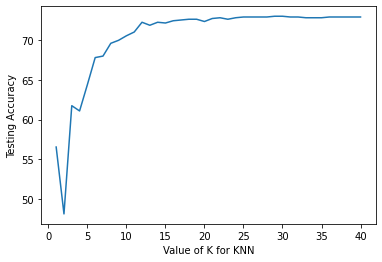

In [31]:
K_Values = range(1, 41)
plt.plot(K_Values, accuracyScores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

#### Highest Accuracy is 73.01136363636364 % for K-Value: 29

## Decision Tree Classifier

In [35]:
model = DecisionTreeClassifier()

model.fit(trainx, trainy)

preds = model.predict(valx)

# Computing Model Accuracy
print("================================== Decision Tree Classifier ==================================")
print("Accuracy:",round(accuracy_score(valy, preds),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(valy, preds))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(valy, preds,target_names =target_names))

================================== Decision Tree Classifier ==================================
Accuracy: 63.0 %
---------------
Confusion matrix
---------------
[[ 23   7  81]
 [ 14  47 114]
 [ 78  97 595]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.20      0.21      0.20       111
  Sentiment1       0.31      0.27      0.29       175
  Sentiment2       0.75      0.77      0.76       770

    accuracy                           0.63      1056
   macro avg       0.42      0.42      0.42      1056
weighted avg       0.62      0.63      0.63      1056



#### DTClassifier gives 63% accuracy

## One Vs Rest Classifier

In [64]:
dt = DecisionTreeClassifier()
model = OneVsRestClassifier(dt,n_jobs=6)
model.fit(trainx, trainy)

preds = model.predict(valx)

# Computing Model Accuracy
print("================================== One Vs Rest Classifier ==================================")
print("Accuracy:",round(accuracy_score(valy, preds),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(valy, preds))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(valy, preds,target_names =target_names))

================================== One Vs Rest Classifier ==================================
Accuracy: 71.0 %
---------------
Confusion matrix
---------------
[[  4   3 104]
 [  4  28 143]
 [ 24  32 714]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.12      0.04      0.06       111
  Sentiment1       0.44      0.16      0.24       175
  Sentiment2       0.74      0.93      0.82       770

    accuracy                           0.71      1056
   macro avg       0.44      0.37      0.37      1056
weighted avg       0.63      0.71      0.65      1056



In [ ]:
rfr = RandomForestClassifier(n_estimators = 50, random_state = 0)
rfr.fit(trainx, trainy)

ytrain_pred = rfr.predict(train)

sq_train = ytrain**2
#cv_score = cross_validate(lr,xtrain,sq_train,cv=20,scoring='neg_mean_squared_error')
#cv_score = cv_score**2

print('Model Report RFR')
print('RMSE: ',np.sqrt(metrics.mean_squared_error(sq_train.values,ytrain_pred)))
#print('CV Score: Mean - ',np.mean(cv_score),' Std - ',np.std(cv_score),' Min- ',np.min(cv_score),' Max- ',np.max(cv_score))

#print('Accuracy is ytrain_pred',lr.score(xtrain,ytrain_pred))
#print('Accuracy is ytrain',lr.score(xtrain,ytrain))
print('Accuracy: ',metrics.r2_score(ytrain,ytrain_pred))
#print('Accuracy is',metrics.accuracy_score(ytrain_pred,ytrain))
ytest = rfr.predict(xtest)

In [75]:
model = RandomForestClassifier(n_estimators = 50, random_state = 0)
model.fit(trainx, trainy)
preds_trainy = model.predict(trainx)
preds = model.predict(valx)
sq_train = trainy**2
print('Model Report RFR')
print('RMSE: ',np.sqrt(mean_squared_error(sq_train.values,preds_trainy)))
#print('Accuracy: ',r2_score(valy,preds))
print("Accuracy:",round(accuracy_score(valy, preds),2) * 100, "%")

Model Report RFR
RMSE:  1.701359654629815
Accuracy: 73.0 %


In [76]:
model = RandomForestClassifier(n_estimators = 50, random_state = 0)
model.fit(trainx, trainy)

preds = model.predict(valx)
#sq_train = trainy**2
#print('Model Report RFR')
#print('RMSE: ',np.sqrt(metrics.mean_squared_error(sq_train.values,preds)))
#print('Accuracy: ',metrics.r2_score(valy,preds))
#ytest = rfr.predict(xtest)
# Computing Model Accuracy
print("================================== Random Forest Classifier ==================================")
print("Accuracy:",round(accuracy_score(valy, preds),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(valy, preds))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(valy, preds,target_names =target_names))

================================== Random Forest Classifier ==================================
Accuracy: 73.0 %
---------------
Confusion matrix
---------------
[[  0   0 111]
 [  0   3 172]
 [  1   3 766]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.00      0.00      0.00       111
  Sentiment1       0.50      0.02      0.03       175
  Sentiment2       0.73      0.99      0.84       770

    accuracy                           0.73      1056
   macro avg       0.41      0.34      0.29      1056
weighted avg       0.62      0.73      0.62      1056



## CNN

In [76]:
# load the pre-trained word-embedding vectors
import numpy as np 
embeddings_index = {}
for i, line in enumerate(open('crawl-300d-2M.vec', encoding="utf8")):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

In [77]:
# create a tokenizer 
from keras.preprocessing import text, sequence
from sklearn import model_selection 

token = text.Tokenizer()
#token.fit_on_texts(train['text'])
token.fit_on_texts(train['cleaned'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(train['cleaned'], train['sentiment'])
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=70)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [78]:
train_x.shape

(3959,)

In [79]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

In [80]:
from keras import layers , models , optimizers
from sklearn import metrics

def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="softmax")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy')
    
    return model

classifier = create_cnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print ("CNN, Word Embeddings",  accuracy)

124/124 [==============================] - 1s 5ms/step - loss: 0.0000e+00
CNN, Word Embeddings 0.125


In [81]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(train['cleaned'],train['sentiment'],test_size=0.3,random_state=0,shuffle=True) 

In [82]:
max_len=500

In [83]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
#creating index for a wor
tokenizer.fit_on_texts(list(x_tr))

#converting word seq to integer seq
x_tr    =   tokenizer.texts_to_sequences(x_tr) 
x_val   =   tokenizer.texts_to_sequences(x_val)

#padding up with zero 
x_tr    =   pad_sequences(x_tr,  maxlen=max_len, padding='post')
x_val   =   pad_sequences(x_val, maxlen=max_len, padding='post')

vocabulary   =  len(tokenizer.word_index) +1
print("Vocabulary size:",vocabulary)

Vocabulary size: 28468


In [84]:
from keras.utils.np_utils import to_categorical
y_tr=to_categorical(y_tr,num_classes=3)
y_val=to_categorical(y_val,num_classes=3)

In [85]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
K.clear_session()

# LSTM model
model=Sequential()
model.add(Embedding(vocabulary,100,input_length=max_len,trainable=True, mask_zero=True)) 
model.add(LSTM(300,dropout=0.1, recurrent_dropout=0.2)) 
model.add(Dense(64,activation='relu')) 
model.add(Dense(3,activation='softmax')) 
print(model.summary()) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 100)          2846800   
_________________________________________________________________
lstm (LSTM)                  (None, 300)               481200    
_________________________________________________________________
dense (Dense)                (None, 64)                19264     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 3,347,459
Trainable params: 3,347,459
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
import numpy as np

In [41]:
np.__version__

'1.19.5'

In [86]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=["acc"]) 

In [87]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)
es = EarlyStopping(patience=3)
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)  

In [88]:
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=100,epochs=50,validation_data=(np.array(x_val),np.array(y_val)),verbose=1,callbacks=[es,mc])

Epoch 1/50
37/37 [==============================] - ETA: 0s - loss: 0.8145 - acc: 0.7164
Epoch 00001: val_loss improved from inf to 0.76716, saving model to best_model.h5
37/37 [==============================] - 86s 2s/step - loss: 0.8145 - acc: 0.7164 - val_loss: 0.7672 - val_acc: 0.7184
Epoch 2/50
37/37 [==============================] - ETA: 0s - loss: 0.6831 - acc: 0.7342
Epoch 00002: val_loss improved from 0.76716 to 0.75858, saving model to best_model.h5
37/37 [==============================] - 86s 2s/step - loss: 0.6831 - acc: 0.7342 - val_loss: 0.7586 - val_acc: 0.7172
Epoch 3/50
37/37 [==============================] - ETA: 0s - loss: 0.5229 - acc: 0.7900
Epoch 00003: val_loss did not improve from 0.75858
37/37 [==============================] - 83s 2s/step - loss: 0.5229 - acc: 0.7900 - val_loss: 0.7915 - val_acc: 0.7052
Epoch 4/50
37/37 [==============================] - ETA: 0s - loss: 0.3961 - acc: 0.8390
Epoch 00004: val_loss did not improve from 0.75858
37/37 [==========

### Gives accuracy of 71.7%

## RNN

In [13]:
temp = []
#Splitting pd.Series to list
data_to_list = train['text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(_clean(data_to_list[i]))

In [233]:
temp = []
#Splitting pd.Series to list
data_to_list = upsampled_npn['cleaned'].values.tolist()
for i in range(len(data_to_list)):
    #temp.append(_clean(data_to_list[i]))
    temp.append(data_to_list[i])

In [132]:
tempTest = []
#Splitting pd.Series to list
dataTest_to_list = test['text'].values.tolist()
for i in range(len(dataTest_to_list)):
    tempTest.append(_clean(dataTest_to_list[i]))

In [235]:
tempTest = []
#Splitting pd.Series to list
dataTest_to_list = test['cleaned'].values.tolist()
for i in range(len(dataTest_to_list)):
    #tempTest.append(_clean(dataTest_to_list[i]))
    tempTest.append(dataTest_to_list[i])

In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
data_words = list(sent_to_words(temp))
len(data_words)

5279

In [236]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
data_words = list(sent_to_words(temp))
len(data_words)

8267

In [79]:
data_words

[['autoimmune',
  'disease',
  'tend',
  'come',
  'cluster',
  'gilenya',
  'feel',
  'good',
  'think',
  'win',
  'change',
  'anything',
  'waste',
  'time',
  'energy',
  'take',
  'tysabri',
  'feel',
  'amaze',
  'symptom',
  'dodgy',
  'color',
  'vision',
  'since',
  'always',
  'know',
  'know',
  'last',
  'month',
  'year',
  'decade',
  'ive',
  'decide',
  'enjoy',
  'ride',
  'point',
  'worry'],
 ['completely',
  'understand',
  'want',
  'try',
  'result',
  'report',
  'lecture',
  'always',
  'stand',
  'scrutiny',
  'peerreview',
  'publication',
  'much',
  'still',
  'convince',
  'hope',
  'work',
  'really',
  'aware',
  'happy',
  'risk',
  'great',
  'think',
  'important',
  'present',
  'balance',
  'way',
  'understand',
  'move',
  'straight',
  'first',
  'show',
  'promise',
  'animal',
  'study',
  'use',
  'drug',
  'human',
  'still',
  'lot',
  'animal',
  'data',
  'gather',
  'human',
  'data',
  'gather',
  'anyone',
  'tell',
  'safe',
  'effect

In [153]:
dataTest_words = list(sent_to_words(tempTest))
len(dataTest_words)

2924

In [237]:
dataTest_words = list(sent_to_words(tempTest))
len(dataTest_words)

2924

In [238]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [18]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))

data = np.array(data)

labels = train['sentiment']

len(labels)

#max_words = 5000
max_words = 2000
max_len = 200

In [245]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))

data = np.array(data)

labels = upsampled_npn['sentiment']

len(labels)

#max_words = 5000
max_words = 2000
max_len = 200

In [24]:
data

array(['autoimmune disease tend come cluster gilenya feel good think win change anything waste time energy take tysabri feel amaze symptom dodgy color vision since always know know last month year decade ive decide enjoy ride point worry',
       'completely understand want try result report lecture always stand scrutiny peerreview publication much still convince hope work really aware happy risk great think important present balance way understand move straight first show promise animal study use drug human still lot animal data gather human data gather anyone tell safe effective tell many time animal study follow human one major attrition point drug development issue interaction predict people try doctor see pattern work go excite give say current condition personal risk tolerance make sense try definitely everyone',
       'interest target receptor rather like fingolimod hop soon see aes saes yes im sure mean exactly quote nine patient report serious adverse event mg mg mg mg seriou

In [25]:
labels

0       2
1       2
2       2
3       2
4       1
       ..
5274    0
5275    2
5276    2
5277    2
5278    0
Name: sentiment, Length: 5279, dtype: int64

In [135]:
dataTest = []
for i in range(len(dataTest_words)):
    dataTest.append(detokenize(dataTest_words[i]))

dataTest = np.array(dataTest)

#max_words = 5000
max_words = 1000
max_len = 200
print(dataTest.shape)

(2924,)


In [246]:
dataTest = []
for i in range(len(dataTest_words)):
    dataTest.append(detokenize(dataTest_words[i]))

dataTest = np.array(dataTest)
#labelsy = test['sentiment']

#max_words = 5000
max_words = 1000
max_len = 200
print(dataTest.shape)

(2924,)


In [247]:
max_words = 1000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizerTest = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
tokenizerTest.fit_on_texts(dataTest)
sequences = tokenizer.texts_to_sequences(data)
sequencesTest = tokenizerTest.texts_to_sequences(dataTest)
comments = pad_sequences(sequences, maxlen=max_len)
commentsTest = pad_sequences(sequencesTest, maxlen=max_len)
print(commentsTest.shape)
print(comments.shape)

(2924, 200)
(8267, 200)


In [243]:
max_words = 1000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizerTest = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
tokenizerTest.fit_on_texts(dataTest)
sequences = tokenizer.texts_to_sequences(data)
sequencesTest = tokenizerTest.texts_to_sequences(dataTest)
comments = pad_sequences(sequences, maxlen=max_len)
commentsTest = pad_sequences(sequencesTest, maxlen=max_len)
print(commentsTest.shape)
print(comments.shape)

(2924, 200)
(8267, 200)


In [22]:
#Splitting the data
#max_words = 2000
X_train, X_test, y_train, y_test = train_test_split(comments,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

3959 1320 3959 1320


In [248]:
#Splitting the data
#max_words = 2000
X_train, X_test, y_train, y_test = train_test_split(comments,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

6200 2067 6200 2067


In [31]:
X_train

array([[   0,    0,    0, ...,  764,  421,  138],
       [1243,  724,   86, ...,  151,  708,    7],
       [   0,    0,    0, ..., 1535,  354,  292],
       ...,
       [   0,    0,    0, ...,  419,    8,  292],
       [   0,    0,    0, ..., 1019,   30,  962],
       [   0,    0,    0, ...,  335,   78,  179]])

In [249]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [38]:
y_test

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [250]:
#max_words = 2000
# Simple RNN
modelRnn = Sequential()
modelRnn.add(layers.Embedding(max_words, 15))
modelRnn.add(layers.SimpleRNN(15))
modelRnn.add(layers.Dense(3,activation='softmax'))


modelRnn.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpointRnn = ModelCheckpoint("best_model0.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='min', period=1,save_weights_only=False)
historyRnn = modelRnn.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpointRnn])

Epoch 1/5
194/194 [==============================] - ETA: 0s - loss: 0.8279 - accuracy: 0.6656
Epoch 00001: val_loss improved from inf to 0.69081, saving model to best_model0.hdf5
194/194 [==============================] - 19s 96ms/step - loss: 0.8279 - accuracy: 0.6656 - val_loss: 0.6908 - val_accuracy: 0.7886
Epoch 2/5
194/194 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.8561
Epoch 00002: val_loss improved from 0.69081 to 0.43084, saving model to best_model0.hdf5
194/194 [==============================] - 17s 90ms/step - loss: 0.5029 - accuracy: 0.8561 - val_loss: 0.4308 - val_accuracy: 0.8791
Epoch 3/5
194/194 [==============================] - ETA: 0s - loss: 0.3053 - accuracy: 0.9069
Epoch 00003: val_loss improved from 0.43084 to 0.30576, saving model to best_model0.hdf5
194/194 [==============================] - 17s 89ms/step - loss: 0.3053 - accuracy: 0.9069 - val_loss: 0.3058 - val_accuracy: 0.9057
Epoch 4/5
194/194 [==============================] - 

In [252]:
import keras
modelRnn = keras.models.load_model('best_model0.hdf5')

In [253]:
y_predRnn=modelRnn.predict_classes(np.array(X_test))
y_trueRnn = np.argmax(y_test, axis=1)
#print(classification_report(y_true,y_pred))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [255]:
# Computing Model Accuracy
print("================================== RNN ==================================")
print("Accuracy:",round(accuracy_score(y_trueRnn, y_predRnn),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(y_trueRnn, y_predRnn))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(y_trueRnn, y_predRnn,target_names =target_names))

================================== RNN ==================================
Accuracy: 93.0 %
---------------
Confusion matrix
---------------
[[934   7   1]
 [ 18 933  10]
 [ 54  65  45]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.93      0.99      0.96       942
  Sentiment1       0.93      0.97      0.95       961
  Sentiment2       0.80      0.27      0.41       164

    accuracy                           0.93      2067
   macro avg       0.89      0.75      0.77      2067
weighted avg       0.92      0.93      0.91      2067



In [256]:
print("F1-score macro = ",(round(f1_score(y_trueRnn, y_predRnn,average='macro'),2))*100,"%")
print("F1-score micro = ",(round(f1_score(y_trueRnn, y_predRnn,average='micro'),2))*100,"%")
print("F1-score weighted = ",(round(f1_score(y_trueRnn, y_predRnn,average='weighted'),2))*100,"%")

F1-score macro =  77.0 %
F1-score micro =  93.0 %
F1-score weighted =  91.0 %


In [258]:
predictionsTestRnn = modelRnn.predict_classes(commentsTest)
predictionsTestRnn

array([0, 0, 0, ..., 1, 2, 1], dtype=int64)

In [259]:
dfinalRnn = pd.DataFrame(columns=['id','sentiment'])
dfinalRnn['id'] = test['unique_hash']
dfinalRnn['sentiment'] = predictionsTestRnn
dfinalRnn['sentiment'].value_counts()

1    1377
0    1187
2     360
Name: sentiment, dtype: int64

In [260]:
dfinalRnn.head(1)

id  sentiment
0  9e9a8166b84114aca147bf409f6f956635034c08          0

In [261]:
dfinalRnn.to_csv("sample_submision_finalRnn.csv",index=0)

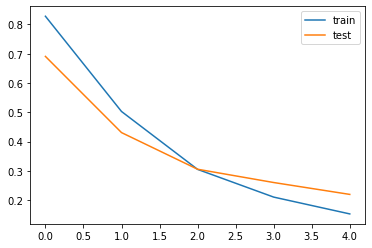

In [302]:
from matplotlib import pyplot
pyplot.plot(historyRnn.history['loss'], label='train')
pyplot.plot(historyRnn.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#### RNN Score 24

#### Epoch 00002: val_loss improved from 0.77784 to 0.77637, saving model to best_model0.hdf5
#### 124/124 [==============================] - 14s 113ms/step - loss: 0.7497 - accuracy: 0.7247 - val_loss: 0.7764 - val_accuracy: 0.7220
#### RNN gives 72.2% accuracy

## LSTM

In [304]:
modelLstm = Sequential()
modelLstm.add(layers.Embedding(max_words, 100))
modelLstm.add(layers.LSTM(300,return_sequences=True))
modelLstm.add(layers.LSTM(300))
modelLstm.add(layers.Dropout(0.2))
modelLstm.add(Dense(64,activation='relu'))
modelLstm.add(Dense(36,activation='relu'))
modelLstm.add(layers.Dense(3,activation='softmax'))

modelLstm.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

checkpointLstm = ModelCheckpoint("best_modelLstm.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='min', period=1,save_weights_only=False)

historyLstm = modelLstm.fit(X_train, y_trn,batch_size = 1000, epochs=100,validation_data=(X_test, y_vall),callbacks=[checkpointLstm])

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 1.0386 - accuracy: 0.4394
Epoch 00001: val_loss improved from inf to 0.91560, saving model to best_modelLstm.hdf5
7/7 [==============================] - 4s 540ms/step - loss: 1.0386 - accuracy: 0.4394 - val_loss: 0.9156 - val_accuracy: 0.4557
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.9144 - accuracy: 0.4795
Epoch 00002: val_loss did not improve from 0.91560
7/7 [==============================] - 3s 434ms/step - loss: 0.9144 - accuracy: 0.4795 - val_loss: 0.9180 - val_accuracy: 0.5085
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.8916 - accuracy: 0.5427
Epoch 00003: val_loss improved from 0.91560 to 0.86693, saving model to best_modelLstm.hdf5
7/7 [==============================] - 3s 438ms/step - loss: 0.8916 - accuracy: 0.5427 - val_loss: 0.8669 - val_accuracy: 0.6057
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.8049 - accuracy: 0.6597
Epoch 0000

Epoch 29/100
7/7 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 0.9565
Epoch 00029: val_loss did not improve from 0.34620
7/7 [==============================] - 3s 454ms/step - loss: 0.1367 - accuracy: 0.9565 - val_loss: 0.4034 - val_accuracy: 0.9158
Epoch 30/100
7/7 [==============================] - ETA: 0s - loss: 0.1177 - accuracy: 0.9615
Epoch 00030: val_loss did not improve from 0.34620
7/7 [==============================] - 3s 455ms/step - loss: 0.1177 - accuracy: 0.9615 - val_loss: 0.3738 - val_accuracy: 0.9149
Epoch 31/100
7/7 [==============================] - ETA: 0s - loss: 0.1092 - accuracy: 0.9658
Epoch 00031: val_loss improved from 0.34620 to 0.33454, saving model to best_modelLstm.hdf5
7/7 [==============================] - 3s 463ms/step - loss: 0.1092 - accuracy: 0.9658 - val_loss: 0.3345 - val_accuracy: 0.9240
Epoch 32/100
7/7 [==============================] - ETA: 0s - loss: 0.0926 - accuracy: 0.9740
Epoch 00032: val_loss improved from 0.33454

Epoch 59/100
7/7 [==============================] - ETA: 0s - loss: 0.0262 - accuracy: 0.9942
Epoch 00059: val_loss did not improve from 0.32721
7/7 [==============================] - 3s 478ms/step - loss: 0.0262 - accuracy: 0.9942 - val_loss: 0.4210 - val_accuracy: 0.9352
Epoch 60/100
7/7 [==============================] - ETA: 0s - loss: 0.0225 - accuracy: 0.9952
Epoch 00060: val_loss did not improve from 0.32721
7/7 [==============================] - 3s 475ms/step - loss: 0.0225 - accuracy: 0.9952 - val_loss: 0.4390 - val_accuracy: 0.9347
Epoch 61/100
7/7 [==============================] - ETA: 0s - loss: 0.0260 - accuracy: 0.9932
Epoch 00061: val_loss did not improve from 0.32721
7/7 [==============================] - 3s 476ms/step - loss: 0.0260 - accuracy: 0.9932 - val_loss: 0.4225 - val_accuracy: 0.9410
Epoch 62/100
7/7 [==============================] - ETA: 0s - loss: 0.0281 - accuracy: 0.9932
Epoch 00062: val_loss did not improve from 0.32721
7/7 [============================

Epoch 89/100
7/7 [==============================] - ETA: 0s - loss: 0.0345 - accuracy: 0.9918
Epoch 00089: val_loss did not improve from 0.31685
7/7 [==============================] - 4s 507ms/step - loss: 0.0345 - accuracy: 0.9918 - val_loss: 0.3602 - val_accuracy: 0.9357
Epoch 90/100
7/7 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9929
Epoch 00090: val_loss did not improve from 0.31685
7/7 [==============================] - 4s 511ms/step - loss: 0.0274 - accuracy: 0.9929 - val_loss: 0.3656 - val_accuracy: 0.9352
Epoch 91/100
7/7 [==============================] - ETA: 0s - loss: 0.0241 - accuracy: 0.9940
Epoch 00091: val_loss did not improve from 0.31685
7/7 [==============================] - 4s 514ms/step - loss: 0.0241 - accuracy: 0.9940 - val_loss: 0.3794 - val_accuracy: 0.9395
Epoch 92/100
7/7 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9958
Epoch 00092: val_loss did not improve from 0.31685
7/7 [============================

In [316]:
import keras
modelLstm = keras.models.load_model('best_modelLstm.hdf5')
y_predLstm=modelLstm.predict_classes(np.array(X_test))
y_trueLstm = np.argmax(y_vall, axis=1)
#print(classification_report(y_true,y_pred))

In [317]:
# Computing Model Accuracy
print("================================== LSTM ==================================")
print("Accuracy:",round(accuracy_score(y_trueLstm, y_predLstm),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(y_trueLstm, y_predLstm))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(y_trueLstm, y_predLstm,target_names =target_names))

================================== LSTM ==================================
Accuracy: 91.0 %
---------------
Confusion matrix
---------------
[[936   5   1]
 [ 20 919  22]
 [ 54  75  35]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.93      0.99      0.96       942
  Sentiment1       0.92      0.96      0.94       961
  Sentiment2       0.60      0.21      0.32       164

    accuracy                           0.91      2067
   macro avg       0.82      0.72      0.74      2067
weighted avg       0.90      0.91      0.90      2067



In [318]:
print("F1-score macro = ",(round(f1_score(y_trueLstm, y_predLstm,average='macro'),2))*100,"%")
print("F1-score micro = ",(round(f1_score(y_trueLstm, y_predLstm,average='micro'),2))*100,"%")
print("F1-score weighted = ",(round(f1_score(y_trueLstm, y_predLstm,average='weighted'),2))*100,"%")

F1-score macro =  74.0 %
F1-score micro =  91.0 %
F1-score weighted =  90.0 %


In [319]:
predictionsTestLstm = modelLstm.predict_classes(commentsTest)
predictionsTestLstm

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [320]:
dfinalLstm = pd.DataFrame(columns=['id','sentiment'])
dfinalLstm['id'] = test['unique_hash']
dfinalLstm['sentiment'] = predictionsTestLstm
dfinalLstm['sentiment'].value_counts()

0    1361
1    1244
2     319
Name: sentiment, dtype: int64

In [321]:
dfinalLstm.head(1)

id  sentiment
0  9e9a8166b84114aca147bf409f6f956635034c08          0

In [322]:
dfinalLstm.to_csv("sample_submision_finalLLstm.csv",index=0)

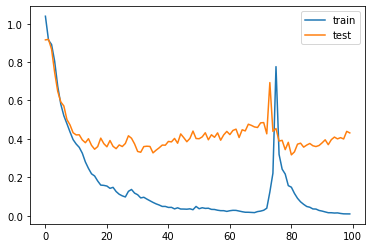

In [323]:
from matplotlib import pyplot
pyplot.plot(historyLstm.history['loss'], label='train')
pyplot.plot(historyLstm.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### LSTM Score 0.25

In [315]:
modelLstm2 = Sequential()
modelLstm2.add(layers.Embedding(max_words, 100))
modelLstm2.add(layers.LSTM(300,dropout=0.2)) 
modelLstm2.add(Dense(64,activation='relu')) 
modelLstm2.add(layers.Dense(3,activation='softmax'))

modelLstm2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

checkpointLstm2 = ModelCheckpoint("best_modelLstm2.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='min', period=1,save_weights_only=False)

historyLstm2 = modelLstm2.fit(X_train, y_trn,batch_size = 1000, epochs=100,validation_data=(X_test, y_vall),callbacks=[checkpointLstm2])

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 1.0580 - accuracy: 0.4363
Epoch 00001: val_loss improved from inf to 0.97020, saving model to best_modelLstm2.hdf5
7/7 [==============================] - 2s 281ms/step - loss: 1.0580 - accuracy: 0.4363 - val_loss: 0.9702 - val_accuracy: 0.4557
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.9352 - accuracy: 0.4663
Epoch 00002: val_loss improved from 0.97020 to 0.90557, saving model to best_modelLstm2.hdf5
7/7 [==============================] - 2s 222ms/step - loss: 0.9352 - accuracy: 0.4663 - val_loss: 0.9056 - val_accuracy: 0.5723
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.8872 - accuracy: 0.5834
Epoch 00003: val_loss improved from 0.90557 to 0.88888, saving model to best_modelLstm2.hdf5
7/7 [==============================] - 2s 221ms/step - loss: 0.8872 - accuracy: 0.5834 - val_loss: 0.8889 - val_accuracy: 0.6391
Epoch 4/100
7/7 [==============================] - ETA: 0s 

Epoch 28/100
7/7 [==============================] - ETA: 0s - loss: 0.1149 - accuracy: 0.9618
Epoch 00028: val_loss did not improve from 0.32238
7/7 [==============================] - 2s 225ms/step - loss: 0.1149 - accuracy: 0.9618 - val_loss: 0.3396 - val_accuracy: 0.9216
Epoch 29/100
7/7 [==============================] - ETA: 0s - loss: 0.1023 - accuracy: 0.9668
Epoch 00029: val_loss did not improve from 0.32238
7/7 [==============================] - 2s 224ms/step - loss: 0.1023 - accuracy: 0.9668 - val_loss: 0.3582 - val_accuracy: 0.9226
Epoch 30/100
7/7 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.9711
Epoch 00030: val_loss did not improve from 0.32238
7/7 [==============================] - 2s 227ms/step - loss: 0.0937 - accuracy: 0.9711 - val_loss: 0.3342 - val_accuracy: 0.9279
Epoch 31/100
7/7 [==============================] - ETA: 0s - loss: 0.0816 - accuracy: 0.9744
Epoch 00031: val_loss did not improve from 0.32238
7/7 [============================

Epoch 58/100
7/7 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9953
Epoch 00058: val_loss did not improve from 0.32238
7/7 [==============================] - 2s 228ms/step - loss: 0.0152 - accuracy: 0.9953 - val_loss: 0.4529 - val_accuracy: 0.9395
Epoch 59/100
7/7 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9952
Epoch 00059: val_loss did not improve from 0.32238
7/7 [==============================] - 2s 228ms/step - loss: 0.0161 - accuracy: 0.9952 - val_loss: 0.4707 - val_accuracy: 0.9429
Epoch 60/100
7/7 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9963
Epoch 00060: val_loss did not improve from 0.32238
7/7 [==============================] - 2s 227ms/step - loss: 0.0117 - accuracy: 0.9963 - val_loss: 0.4436 - val_accuracy: 0.9410
Epoch 61/100
7/7 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9952
Epoch 00061: val_loss did not improve from 0.32238
7/7 [============================

Epoch 88/100
7/7 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9989
Epoch 00088: val_loss did not improve from 0.32238
7/7 [==============================] - 2s 230ms/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.5332 - val_accuracy: 0.9400
Epoch 89/100
7/7 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9989
Epoch 00089: val_loss did not improve from 0.32238
7/7 [==============================] - 2s 236ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.5328 - val_accuracy: 0.9410
Epoch 90/100
7/7 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9990
Epoch 00090: val_loss did not improve from 0.32238
7/7 [==============================] - 2s 232ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.5513 - val_accuracy: 0.9405
Epoch 91/100
7/7 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9987
Epoch 00091: val_loss did not improve from 0.32238
7/7 [============================

In [324]:
import keras
modelLstm2 = keras.models.load_model('best_modelLstm2.hdf5')
y_predLstm2 = modelLstm2.predict_classes(np.array(X_test))
y_trueLstm2 = np.argmax(y_vall, axis=1)
#print(classification_report(y_true,y_pred))

In [325]:
# Computing Model Accuracy
print("================================== LSTM ==================================")
print("Accuracy:",round(accuracy_score(y_trueLstm2, y_predLstm2),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(y_trueLstm2, y_predLstm2))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(y_trueLstm2, y_predLstm2,target_names =target_names))

================================== LSTM ==================================
Accuracy: 92.0 %
---------------
Confusion matrix
---------------
[[931   5   6]
 [ 22 920  19]
 [ 60  58  46]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.92      0.99      0.95       942
  Sentiment1       0.94      0.96      0.95       961
  Sentiment2       0.65      0.28      0.39       164

    accuracy                           0.92      2067
   macro avg       0.83      0.74      0.76      2067
weighted avg       0.91      0.92      0.91      2067



In [326]:
print("F1-score macro = ",(round(f1_score(y_trueLstm2, y_predLstm2,average='macro'),2))*100,"%")
print("F1-score micro = ",(round(f1_score(y_trueLstm2, y_predLstm2,average='micro'),2))*100,"%")
print("F1-score weighted = ",(round(f1_score(y_trueLstm2, y_predLstm2,average='weighted'),2))*100,"%")

F1-score macro =  76.0 %
F1-score micro =  92.0 %
F1-score weighted =  91.0 %


In [327]:
predictionsTestLstm2 = modelLstm2.predict_classes(commentsTest)
predictionsTestLstm2

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

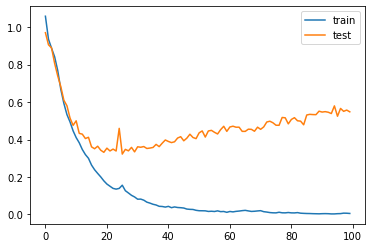

In [328]:
from matplotlib import pyplot
pyplot.plot(historyLstm2.history['loss'], label='train')
pyplot.plot(historyLstm2.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [329]:
modelLstm3 = Sequential()
modelLstm3.add(layers.Embedding(max_words, 100))
modelLstm3.add(layers.LSTM(300,dropout=0.2)) 
modelLstm3.add(Dense(64,activation='relu')) 
modelLstm3.add(layers.Dense(3,activation='softmax'))

modelLstm3.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

checkpointLstm3 = ModelCheckpoint("best_modelLstm3.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='min', period=1,save_weights_only=False)

historyLstm3 = modelLstm3.fit(X_train, y_trn,batch_size = 500, epochs=70,validation_data=(X_test, y_vall),callbacks=[checkpointLstm3])

Epoch 1/70
13/13 [==============================] - ETA: 0s - loss: 0.9931 - accuracy: 0.4639
Epoch 00001: val_loss improved from inf to 0.91234, saving model to best_modelLstm3.hdf5
13/13 [==============================] - 2s 163ms/step - loss: 0.9931 - accuracy: 0.4639 - val_loss: 0.9123 - val_accuracy: 0.4557
Epoch 2/70
13/13 [==============================] - ETA: 0s - loss: 0.8923 - accuracy: 0.5211
Epoch 00002: val_loss improved from 0.91234 to 0.88701, saving model to best_modelLstm3.hdf5
13/13 [==============================] - 2s 130ms/step - loss: 0.8923 - accuracy: 0.5211 - val_loss: 0.8870 - val_accuracy: 0.4983
Epoch 3/70
13/13 [==============================] - ETA: 0s - loss: 0.8292 - accuracy: 0.6395
Epoch 00003: val_loss improved from 0.88701 to 0.77398, saving model to best_modelLstm3.hdf5
13/13 [==============================] - 2s 130ms/step - loss: 0.8292 - accuracy: 0.6395 - val_loss: 0.7740 - val_accuracy: 0.7112
Epoch 4/70
13/13 [==============================] 

Epoch 29/70
13/13 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9924
Epoch 00029: val_loss did not improve from 0.36489
13/13 [==============================] - 2s 133ms/step - loss: 0.0256 - accuracy: 0.9924 - val_loss: 0.4640 - val_accuracy: 0.9332
Epoch 30/70
13/13 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9924
Epoch 00030: val_loss did not improve from 0.36489
13/13 [==============================] - 2s 133ms/step - loss: 0.0232 - accuracy: 0.9924 - val_loss: 0.4810 - val_accuracy: 0.9342
Epoch 31/70
13/13 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.9944
Epoch 00031: val_loss did not improve from 0.36489
13/13 [==============================] - 2s 133ms/step - loss: 0.0193 - accuracy: 0.9944 - val_loss: 0.5161 - val_accuracy: 0.9308
Epoch 32/70
13/13 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.9929
Epoch 00032: val_loss did not improve from 0.36489
13/13 [================

Epoch 59/70
13/13 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9942
Epoch 00059: val_loss did not improve from 0.36489
13/13 [==============================] - 2s 134ms/step - loss: 0.0166 - accuracy: 0.9942 - val_loss: 0.5677 - val_accuracy: 0.9361
Epoch 60/70
13/13 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9935
Epoch 00060: val_loss did not improve from 0.36489
13/13 [==============================] - 2s 135ms/step - loss: 0.0183 - accuracy: 0.9935 - val_loss: 0.5729 - val_accuracy: 0.9332
Epoch 61/70
13/13 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.9942
Epoch 00061: val_loss did not improve from 0.36489
13/13 [==============================] - 2s 134ms/step - loss: 0.0193 - accuracy: 0.9942 - val_loss: 0.5346 - val_accuracy: 0.9361
Epoch 62/70
13/13 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9945
Epoch 00062: val_loss did not improve from 0.36489
13/13 [================

In [330]:
import keras
modelLstm3 = keras.models.load_model('best_modelLstm3.hdf5')
y_predLstm3 = modelLstm3.predict_classes(np.array(X_test))
y_trueLstm3 = np.argmax(y_vall, axis=1)
#print(classification_report(y_true,y_pred))

In [331]:
# Computing Model Accuracy
print("================================== LSTM ==================================")
print("Accuracy:",round(accuracy_score(y_trueLstm3, y_predLstm3),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(y_trueLstm3, y_predLstm3))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(y_trueLstm3, y_predLstm3,target_names =target_names))

================================== LSTM ==================================
Accuracy: 91.0 %
---------------
Confusion matrix
---------------
[[908  13  21]
 [ 17 916  28]
 [ 51  66  47]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.93      0.96      0.95       942
  Sentiment1       0.92      0.95      0.94       961
  Sentiment2       0.49      0.29      0.36       164

    accuracy                           0.91      2067
   macro avg       0.78      0.73      0.75      2067
weighted avg       0.89      0.91      0.90      2067



In [332]:
print("F1-score macro = ",(round(f1_score(y_trueLstm3, y_predLstm3,average='macro'),2))*100,"%")
print("F1-score micro = ",(round(f1_score(y_trueLstm3, y_predLstm3,average='micro'),2))*100,"%")
print("F1-score weighted = ",(round(f1_score(y_trueLstm3, y_predLstm3,average='weighted'),2))*100,"%")

F1-score macro =  75.0 %
F1-score micro =  91.0 %
F1-score weighted =  90.0 %


In [333]:
predictionsTestLstm3 = modelLstm3.predict_classes(commentsTest)
predictionsTestLstm3

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

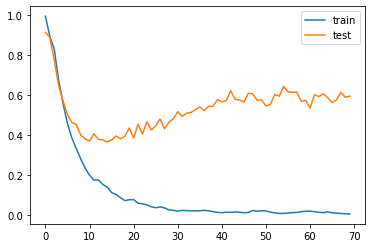

In [334]:
from matplotlib import pyplot
pyplot.plot(historyLstm3.history['loss'], label='train')
pyplot.plot(historyLstm3.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [335]:
modelLstmm4 = Sequential()
modelLstmm4.add(layers.Embedding(max_words, 100))
modelLstmm4.add(layers.LSTM(200,return_sequences=True))
modelLstmm4.add(layers.LSTM(200))
modelLstmm4.add(Dropout(0.2))
modelLstmm4.add(Dense(64,activation='relu')) 
modelLstmm4.add(layers.Dense(3,activation='softmax'))

modelLstmm4.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
checkpointLstmm4 = ModelCheckpoint("best_modelLstmm4.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='min', period=1,save_weights_only=False)
historyLstmm4 = modelLstmm4.fit(X_train, y_trn, epochs=70,validation_data=(X_test, y_vall),callbacks=[checkpointLstmm4])

Epoch 1/70
194/194 [==============================] - ETA: 0s - loss: 0.7636 - accuracy: 0.6558
Epoch 00001: val_loss improved from inf to 0.58825, saving model to best_modelLstmm4.hdf5
194/194 [==============================] - 13s 65ms/step - loss: 0.7636 - accuracy: 0.6558 - val_loss: 0.5882 - val_accuracy: 0.8075
Epoch 2/70
194/194 [==============================] - ETA: 0s - loss: 0.4380 - accuracy: 0.8505
Epoch 00002: val_loss improved from 0.58825 to 0.37334, saving model to best_modelLstmm4.hdf5
194/194 [==============================] - 12s 61ms/step - loss: 0.4380 - accuracy: 0.8505 - val_loss: 0.3733 - val_accuracy: 0.8858
Epoch 3/70
194/194 [==============================] - ETA: 0s - loss: 0.2927 - accuracy: 0.9005
Epoch 00003: val_loss did not improve from 0.37334
194/194 [==============================] - 12s 61ms/step - loss: 0.2927 - accuracy: 0.9005 - val_loss: 0.3761 - val_accuracy: 0.8926
Epoch 4/70
193/194 [============================>.] - ETA: 0s - loss: 0.2228 -

194/194 [==============================] - ETA: 0s - loss: 0.0414 - accuracy: 0.9903
Epoch 00058: val_loss did not improve from 0.30795
194/194 [==============================] - 12s 63ms/step - loss: 0.0414 - accuracy: 0.9903 - val_loss: 0.4006 - val_accuracy: 0.9318
Epoch 59/70
194/194 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 0.9932
Epoch 00059: val_loss did not improve from 0.30795
194/194 [==============================] - 12s 62ms/step - loss: 0.0226 - accuracy: 0.9932 - val_loss: 0.4004 - val_accuracy: 0.9347
Epoch 60/70
194/194 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9965
Epoch 00060: val_loss did not improve from 0.30795
194/194 [==============================] - 12s 64ms/step - loss: 0.0130 - accuracy: 0.9965 - val_loss: 0.5114 - val_accuracy: 0.9342
Epoch 61/70
194/194 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9987
Epoch 00061: val_loss did not improve from 0.30795
194/194 [============

In [336]:
import keras
modelLstmm4 = keras.models.load_model('best_modelLstmm4.hdf5')
y_predLstmm4 = modelLstmm4.predict_classes(np.array(X_test))
y_trueLstmm4 = np.argmax(y_vall, axis=1)
#print(classification_report(y_true,y_pred))

In [337]:
# Computing Model Accuracy
print("================================== LSTM ==================================")
print("Accuracy:",round(accuracy_score(y_trueLstmm4, y_predLstmm4),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(y_trueLstmm4, y_predLstmm4))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(y_trueLstmm4, y_predLstmm4,target_names =target_names))

================================== LSTM ==================================
Accuracy: 90.0 %
---------------
Confusion matrix
---------------
[[902  14  26]
 [ 17 925  19]
 [ 46  75  43]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.93      0.96      0.95       942
  Sentiment1       0.91      0.96      0.94       961
  Sentiment2       0.49      0.26      0.34       164

    accuracy                           0.90      2067
   macro avg       0.78      0.73      0.74      2067
weighted avg       0.89      0.90      0.89      2067



In [338]:
print("F1-score macro = ",(round(f1_score(y_trueLstmm4, y_predLstmm4,average='macro'),2))*100,"%")
print("F1-score micro = ",(round(f1_score(y_trueLstmm4, y_predLstmm4,average='micro'),2))*100,"%")
print("F1-score weighted = ",(round(f1_score(y_trueLstmm4, y_predLstmm4,average='weighted'),2))*100,"%")

F1-score macro =  74.0 %
F1-score micro =  90.0 %
F1-score weighted =  89.0 %


In [339]:
predictionsTestLstmm4 = modelLstmm4.predict_classes(commentsTest)
predictionsTestLstmm4

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

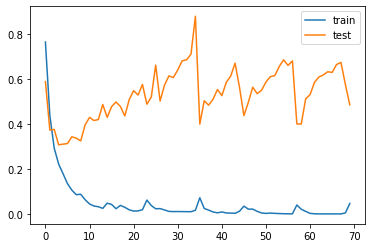

In [340]:
from matplotlib import pyplot
pyplot.plot(historyLstmm4.history['loss'], label='train')
pyplot.plot(historyLstmm4.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [341]:
modelLstm5 = Sequential()
modelLstm5.add(layers.Embedding(max_words, 20))
modelLstm5.add(layers.LSTM(15,dropout=0.5))
modelLstm5.add(layers.Dense(3,activation='softmax'))


modelLstm5.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
checkpointLstm5 = ModelCheckpoint("best_modelLstm5.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='min', period=1,save_weights_only=False)
historyLstm5 = modelLstm5.fit(X_train, y_trn, epochs=70,validation_data=(X_test, y_vall),callbacks=[checkpointLstm5])

Epoch 1/70
193/194 [============================>.] - ETA: 0s - loss: 0.8855 - accuracy: 0.5719
Epoch 00001: val_loss improved from inf to 0.78605, saving model to best_modelLstm5.hdf5
194/194 [==============================] - 6s 30ms/step - loss: 0.8862 - accuracy: 0.5719 - val_loss: 0.7860 - val_accuracy: 0.6865
Epoch 2/70
193/194 [============================>.] - ETA: 0s - loss: 0.6914 - accuracy: 0.7332
Epoch 00002: val_loss improved from 0.78605 to 0.68774, saving model to best_modelLstm5.hdf5
194/194 [==============================] - 4s 22ms/step - loss: 0.6900 - accuracy: 0.7335 - val_loss: 0.6877 - val_accuracy: 0.7242
Epoch 3/70
194/194 [==============================] - ETA: 0s - loss: 0.5947 - accuracy: 0.7861
Epoch 00003: val_loss improved from 0.68774 to 0.58191, saving model to best_modelLstm5.hdf5
194/194 [==============================] - 4s 21ms/step - loss: 0.5947 - accuracy: 0.7861 - val_loss: 0.5819 - val_accuracy: 0.7929
Epoch 4/70
193/194 [=====================

Epoch 56/70
193/194 [============================>.] - ETA: 0s - loss: 0.2255 - accuracy: 0.9247
Epoch 00056: val_loss did not improve from 0.30887
194/194 [==============================] - 4s 20ms/step - loss: 0.2260 - accuracy: 0.9244 - val_loss: 0.3163 - val_accuracy: 0.9144
Epoch 57/70
193/194 [============================>.] - ETA: 0s - loss: 0.2058 - accuracy: 0.9335
Epoch 00057: val_loss did not improve from 0.30887
194/194 [==============================] - 4s 20ms/step - loss: 0.2056 - accuracy: 0.9335 - val_loss: 0.3639 - val_accuracy: 0.9129
Epoch 58/70
192/194 [============================>.] - ETA: 0s - loss: 0.2135 - accuracy: 0.9295
Epoch 00058: val_loss did not improve from 0.30887
194/194 [==============================] - 4s 20ms/step - loss: 0.2144 - accuracy: 0.9294 - val_loss: 0.3674 - val_accuracy: 0.9149
Epoch 59/70
194/194 [==============================] - ETA: 0s - loss: 0.2147 - accuracy: 0.9281
Epoch 00059: val_loss did not improve from 0.30887
194/194 [===

In [342]:
import keras
modelLstm5 = keras.models.load_model('best_modelLstm5.hdf5')
y_predLstm5 = modelLstm5.predict_classes(np.array(X_test))
y_trueLstm5 = np.argmax(y_vall, axis=1)
#print(classification_report(y_true,y_pred))

In [343]:
# Computing Model Accuracy
print("================================== LSTM ==================================")
print("Accuracy:",round(accuracy_score(y_trueLstm5, y_predLstm5),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(y_trueLstm5, y_predLstm5))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(y_trueLstm5, y_predLstm5,target_names =target_names))

================================== LSTM ==================================
Accuracy: 92.0 %
---------------
Confusion matrix
---------------
[[920  12  10]
 [  9 948   4]
 [ 56  68  40]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.93      0.98      0.95       942
  Sentiment1       0.92      0.99      0.95       961
  Sentiment2       0.74      0.24      0.37       164

    accuracy                           0.92      2067
   macro avg       0.87      0.74      0.76      2067
weighted avg       0.91      0.92      0.91      2067



In [344]:
print("F1-score macro = ",(round(f1_score(y_trueLstm5, y_predLstm5,average='macro'),2))*100,"%")
print("F1-score micro = ",(round(f1_score(y_trueLstm5, y_predLstm5,average='micro'),2))*100,"%")
print("F1-score weighted = ",(round(f1_score(y_trueLstm5, y_predLstm5,average='weighted'),2))*100,"%")

F1-score macro =  76.0 %
F1-score micro =  92.0 %
F1-score weighted =  91.0 %


In [345]:
predictionsTestLstm5 = modelLstm5.predict_classes(commentsTest)
predictionsTestLstm5

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

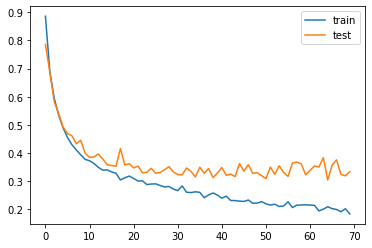

In [346]:
from matplotlib import pyplot
pyplot.plot(historyLstm5.history['loss'], label='train')
pyplot.plot(historyLstm5.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [347]:
dfinalLstm5 = pd.DataFrame(columns=['id','sentiment'])
dfinalLstm5['id'] = test['unique_hash']
dfinalLstm5['sentiment'] = predictionsTestLstm5
dfinalLstm5['sentiment'].value_counts()

0    1463
1    1029
2     432
Name: sentiment, dtype: int64

In [348]:
dfinalLstm5.head(1)

id  sentiment
0  9e9a8166b84114aca147bf409f6f956635034c08          0

In [349]:
dfinalLstm5.to_csv("sample_submision_finalLstm5.csv",index=0)

### LSTM5 score 0.25

#### Epoch 00011: val_accuracy improved from 0.72500 to 0.73030, saving model to best_model1.hdf5
#### 124/124 [==============================] - 2s 17ms/step - loss: 0.5849 - accuracy: 0.7674 - val_loss: 0.7647 - val_accuracy: 0.7303
#### LSTM gives accuracy of 73.03%

### Bidirectional LSTM

In [44]:
#max_words = 2000
# bidirectional LSTM
modelBL3 = Sequential()
modelBL3.add(layers.Embedding(max_words, 50, input_length=max_len))
modelBL3.add(layers.Bidirectional(layers.LSTM(200,dropout=0.2)))
modelBL3.add(layers.Dense(3,activation='softmax'))
modelBL3.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpointBL3 = ModelCheckpoint("best_modelBL3.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='min', period=1,save_weights_only=False)
historyBL3 = modelBL3.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpointBL3])

Epoch 1/70
124/124 [==============================] - ETA: 0s - loss: 0.8142 - accuracy: 0.7211
Epoch 00001: val_loss improved from inf to 0.78080, saving model to best_modelBL3.hdf5
124/124 [==============================] - 5s 43ms/step - loss: 0.8142 - accuracy: 0.7211 - val_loss: 0.7808 - val_accuracy: 0.7227
Epoch 2/70
124/124 [==============================] - ETA: 0s - loss: 0.7449 - accuracy: 0.7257
Epoch 00002: val_loss improved from 0.78080 to 0.74820, saving model to best_modelBL3.hdf5
124/124 [==============================] - 4s 36ms/step - loss: 0.7449 - accuracy: 0.7257 - val_loss: 0.7482 - val_accuracy: 0.7227
Epoch 3/70
124/124 [==============================] - ETA: 0s - loss: 0.7037 - accuracy: 0.7312
Epoch 00003: val_loss did not improve from 0.74820
124/124 [==============================] - 4s 35ms/step - loss: 0.7037 - accuracy: 0.7312 - val_loss: 0.7487 - val_accuracy: 0.7220
Epoch 4/70
123/124 [============================>.] - ETA: 0s - loss: 0.7020 - accuracy

Epoch 30/70
124/124 [==============================] - ETA: 0s - loss: 0.1597 - accuracy: 0.9454
Epoch 00030: val_loss did not improve from 0.74820
124/124 [==============================] - 5s 37ms/step - loss: 0.1597 - accuracy: 0.9454 - val_loss: 1.5910 - val_accuracy: 0.6462
Epoch 31/70
124/124 [==============================] - ETA: 0s - loss: 0.1452 - accuracy: 0.9510
Epoch 00031: val_loss did not improve from 0.74820
124/124 [==============================] - 4s 36ms/step - loss: 0.1452 - accuracy: 0.9510 - val_loss: 1.6175 - val_accuracy: 0.6455
Epoch 32/70
124/124 [==============================] - ETA: 0s - loss: 0.1451 - accuracy: 0.9507
Epoch 00032: val_loss did not improve from 0.74820
124/124 [==============================] - 4s 35ms/step - loss: 0.1451 - accuracy: 0.9507 - val_loss: 1.6656 - val_accuracy: 0.6447
Epoch 33/70
124/124 [==============================] - ETA: 0s - loss: 0.1252 - accuracy: 0.9591
Epoch 00033: val_loss did not improve from 0.74820
124/124 [===

In [45]:
modelBL3 = load_model('best_modelBL3.hdf5')

In [46]:
y_pred=modelBL3.predict_classes(np.array(X_test))
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       161
           1       0.00      0.00      0.00       205
           2       0.72      1.00      0.84       954

    accuracy                           0.72      1320
   macro avg       0.24      0.33      0.28      1320
weighted avg       0.52      0.72      0.61      1320



C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


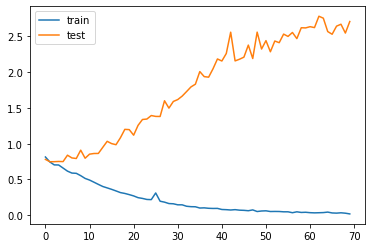

In [47]:
from matplotlib import pyplot
pyplot.plot(historyBL3.history['loss'], label='train')
pyplot.plot(historyBL3.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [48]:
#max_words = 2000
# bidirectional LSTM
modelBL4 = Sequential()
modelBL4.add(layers.Embedding(max_words, 100, input_length=max_len))
modelBL4.add(layers.Bidirectional(layers.LSTM(300,dropout=0.2)))
modelBL4.add(layers.Dense(64,activation='relu'))
modelBL4.add(layers.Dense(3,activation='softmax'))
modelBL4.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpointBL4 = ModelCheckpoint("best_modelBL4.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='min', period=1,save_weights_only=False)
historyBL4 = modelBL4.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpointBL4])

Epoch 1/70
123/124 [============================>.] - ETA: 0s - loss: 0.7917 - accuracy: 0.7205
Epoch 00001: val_loss improved from inf to 0.77893, saving model to best_modelBL4.hdf5
124/124 [==============================] - 6s 46ms/step - loss: 0.7911 - accuracy: 0.7209 - val_loss: 0.7789 - val_accuracy: 0.7227
Epoch 2/70
124/124 [==============================] - ETA: 0s - loss: 0.7096 - accuracy: 0.7277
Epoch 00002: val_loss improved from 0.77893 to 0.73993, saving model to best_modelBL4.hdf5
124/124 [==============================] - 5s 39ms/step - loss: 0.7096 - accuracy: 0.7277 - val_loss: 0.7399 - val_accuracy: 0.7227
Epoch 3/70
123/124 [============================>.] - ETA: 0s - loss: 0.6327 - accuracy: 0.7508
Epoch 00003: val_loss did not improve from 0.73993
124/124 [==============================] - 5s 38ms/step - loss: 0.6327 - accuracy: 0.7502 - val_loss: 0.7749 - val_accuracy: 0.6871
Epoch 4/70
124/124 [==============================] - ETA: 0s - loss: 0.5641 - accuracy

Epoch 30/70
123/124 [============================>.] - ETA: 0s - loss: 0.0485 - accuracy: 0.9830
Epoch 00030: val_loss did not improve from 0.73993
124/124 [==============================] - 5s 40ms/step - loss: 0.0484 - accuracy: 0.9831 - val_loss: 2.6424 - val_accuracy: 0.6273
Epoch 31/70
124/124 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9864
Epoch 00031: val_loss did not improve from 0.73993
124/124 [==============================] - 5s 39ms/step - loss: 0.0422 - accuracy: 0.9864 - val_loss: 2.5442 - val_accuracy: 0.6470
Epoch 32/70
123/124 [============================>.] - ETA: 0s - loss: 0.0344 - accuracy: 0.9878
Epoch 00032: val_loss did not improve from 0.73993
124/124 [==============================] - 5s 39ms/step - loss: 0.0344 - accuracy: 0.9879 - val_loss: 2.7560 - val_accuracy: 0.6197
Epoch 33/70
123/124 [============================>.] - ETA: 0s - loss: 0.0406 - accuracy: 0.9855 ETA: 0s - los
Epoch 00033: val_loss did not improve from 0.7399

In [49]:
modelBL4 = load_model('best_modelBL4.hdf5')

In [50]:
y_pred=modelBL4.predict_classes(np.array(X_test))
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       161
           1       0.40      0.01      0.02       205
           2       0.72      1.00      0.84       954

    accuracy                           0.72      1320
   macro avg       0.37      0.34      0.29      1320
weighted avg       0.59      0.72      0.61      1320



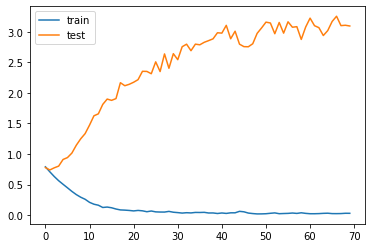

In [51]:
from matplotlib import pyplot
pyplot.plot(historyBL4.history['loss'], label='train')
pyplot.plot(historyBL4.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [40]:
#max_words = 2000
# bidirectional LSTM
modelBL2 = Sequential()
modelBL2.add(layers.Embedding(max_words, 100, input_length=max_len))
modelBL2.add(layers.Bidirectional(layers.LSTM(300,dropout=0.2)))
modelBL2.add(layers.Dense(3,activation='softmax'))
modelBL2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpointBL2 = ModelCheckpoint("best_modelBL2.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='min', period=1,save_weights_only=False)
historyBL2 = modelBL2.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpointBL2])

Epoch 1/70
123/124 [============================>.] - ETA: 0s - loss: 0.8143 - accuracy: 0.7182
Epoch 00001: val_loss improved from inf to 0.79259, saving model to best_modelBL2.hdf5
124/124 [==============================] - 6s 47ms/step - loss: 0.8132 - accuracy: 0.7189 - val_loss: 0.7926 - val_accuracy: 0.7220
Epoch 2/70
123/124 [============================>.] - ETA: 0s - loss: 0.7269 - accuracy: 0.7297
Epoch 00002: val_loss improved from 0.79259 to 0.74005, saving model to best_modelBL2.hdf5
124/124 [==============================] - 5s 41ms/step - loss: 0.7265 - accuracy: 0.7297 - val_loss: 0.7401 - val_accuracy: 0.7227
Epoch 3/70
124/124 [==============================] - ETA: 0s - loss: 0.6664 - accuracy: 0.7345
Epoch 00003: val_loss did not improve from 0.74005
124/124 [==============================] - 5s 41ms/step - loss: 0.6664 - accuracy: 0.7345 - val_loss: 0.7452 - val_accuracy: 0.7159
Epoch 4/70
124/124 [==============================] - ETA: 0s - loss: 0.6227 - accuracy

Epoch 30/70
124/124 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9770
Epoch 00030: val_loss did not improve from 0.74005
124/124 [==============================] - 5s 41ms/step - loss: 0.0699 - accuracy: 0.9770 - val_loss: 1.9533 - val_accuracy: 0.6432
Epoch 31/70
123/124 [============================>.] - ETA: 0s - loss: 0.0658 - accuracy: 0.9789
Epoch 00031: val_loss did not improve from 0.74005
124/124 [==============================] - 5s 40ms/step - loss: 0.0659 - accuracy: 0.9788 - val_loss: 2.0977 - val_accuracy: 0.5902
Epoch 32/70
123/124 [============================>.] - ETA: 0s - loss: 0.0663 - accuracy: 0.9771
Epoch 00032: val_loss did not improve from 0.74005
124/124 [==============================] - 5s 40ms/step - loss: 0.0662 - accuracy: 0.9773 - val_loss: 2.2038 - val_accuracy: 0.6159
Epoch 33/70
124/124 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.9823
Epoch 00033: val_loss did not improve from 0.74005
124/124 [===

Epoch 00002: val_loss improved from 0.79259 to 0.74005, saving model to best_modelBL2.hdf5
124/124 [==============================] - 5s 41ms/step - loss: 0.7265 - accuracy: 0.7297 - val_loss: 0.7401 - val_accuracy: 0.7227

In [41]:
modelBL2 = load_model('best_modelBL2.hdf5')

In [42]:
y_pred=modelBL2.predict_classes(np.array(X_test))
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       161
           1       0.00      0.00      0.00       205
           2       0.72      1.00      0.84       954

    accuracy                           0.72      1320
   macro avg       0.24      0.33      0.28      1320
weighted avg       0.52      0.72      0.61      1320



C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


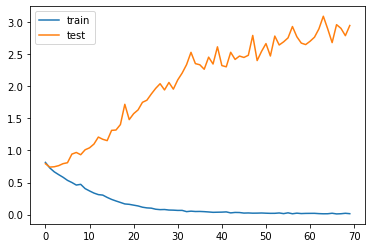

In [43]:
from matplotlib import pyplot
pyplot.plot(historyBL2.history['loss'], label='train')
pyplot.plot(historyBL2.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [35]:
#max_words = 2000
# bidirectional LSTM
modelBL1 = Sequential()
modelBL1.add(layers.Embedding(max_words, 40, input_length=max_len))
modelBL1.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
modelBL1.add(layers.Dense(3,activation='softmax'))
modelBL1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpointBL1 = ModelCheckpoint("best_modelBL1.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='min', period=1,save_weights_only=False)
historyBL1 = modelBL1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpointBL1])

Epoch 1/70
123/124 [============================>.] - ETA: 0s - loss: 0.7850 - accuracy: 0.7221
Epoch 00001: val_loss improved from inf to 0.76203, saving model to best_modelBL1.hdf5
124/124 [==============================] - 5s 37ms/step - loss: 0.7865 - accuracy: 0.7211 - val_loss: 0.7620 - val_accuracy: 0.7227
Epoch 2/70
124/124 [==============================] - ETA: 0s - loss: 0.7340 - accuracy: 0.7252
Epoch 00002: val_loss improved from 0.76203 to 0.73807, saving model to best_modelBL1.hdf5
124/124 [==============================] - 4s 29ms/step - loss: 0.7340 - accuracy: 0.7252 - val_loss: 0.7381 - val_accuracy: 0.7242
Epoch 3/70
124/124 [==============================] - ETA: 0s - loss: 0.7094 - accuracy: 0.7292
Epoch 00003: val_loss did not improve from 0.73807
124/124 [==============================] - 4s 28ms/step - loss: 0.7094 - accuracy: 0.7292 - val_loss: 0.7429 - val_accuracy: 0.7258
Epoch 4/70
123/124 [============================>.] - ETA: 0s - loss: 0.6925 - accuracy

123/124 [============================>.] - ETA: 0s - loss: 0.3437 - accuracy: 0.8727
Epoch 00058: val_loss did not improve from 0.73453
124/124 [==============================] - 4s 31ms/step - loss: 0.3423 - accuracy: 0.8732 - val_loss: 1.0380 - val_accuracy: 0.6947
Epoch 59/70
123/124 [============================>.] - ETA: 0s - loss: 0.3531 - accuracy: 0.8681
Epoch 00059: val_loss did not improve from 0.73453
124/124 [==============================] - 4s 31ms/step - loss: 0.3531 - accuracy: 0.8676 - val_loss: 1.0131 - val_accuracy: 0.6644
Epoch 60/70
124/124 [==============================] - ETA: 0s - loss: 0.3486 - accuracy: 0.8659
Epoch 00060: val_loss did not improve from 0.73453
124/124 [==============================] - 4s 30ms/step - loss: 0.3486 - accuracy: 0.8659 - val_loss: 1.0631 - val_accuracy: 0.6811
Epoch 61/70
124/124 [==============================] - ETA: 0s - loss: 0.3306 - accuracy: 0.8765
Epoch 00061: val_loss did not improve from 0.73453
124/124 [===============

Epoch 4/70
123/124 [============================>.] - ETA: 0s - loss: 0.6925 - accuracy: 0.7342
Epoch 00004: val_loss improved from 0.73807 to 0.73453, saving model to best_modelBL1.hdf5
124/124 [==============================] - 4s 29ms/step - loss: 0.6924 - accuracy: 0.7343 - val_loss: 0.7345 - val_accuracy: 0.7250

In [36]:
modelBL1 = load_model('best_modelBL1.hdf5')

In [37]:
y_pred=modelBL1.predict_classes(np.array(X_test))
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       161
           1       0.45      0.07      0.12       205
           2       0.73      0.99      0.84       954

    accuracy                           0.73      1320
   macro avg       0.39      0.35      0.32      1320
weighted avg       0.60      0.72      0.63      1320



C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


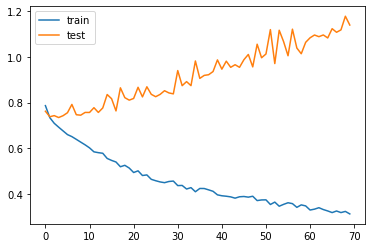

In [39]:
from matplotlib import pyplot
pyplot.plot(historyBL1.history['loss'], label='train')
pyplot.plot(historyBL1.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [119]:
#max_words = 2000
# bidirectional LSTM
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(15,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("best_modelBL2.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='min', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/70
123/124 [============================>.] - ETA: 0s - loss: 0.8081 - accuracy: 0.7175
Epoch 00001: val_loss improved from inf to 0.77086, saving model to best_modelBL2.hdf5
124/124 [==============================] - 5s 37ms/step - loss: 0.8083 - accuracy: 0.7174 - val_loss: 0.7709 - val_accuracy: 0.7227
Epoch 2/70
123/124 [============================>.] - ETA: 0s - loss: 0.7468 - accuracy: 0.7256
Epoch 00002: val_loss improved from 0.77086 to 0.74774, saving model to best_modelBL2.hdf5
124/124 [==============================] - 4s 29ms/step - loss: 0.7473 - accuracy: 0.7252 - val_loss: 0.7477 - val_accuracy: 0.7227
Epoch 3/70
122/124 [============================>.] - ETA: 0s - loss: 0.7185 - accuracy: 0.7249
Epoch 00003: val_loss improved from 0.74774 to 0.73400, saving model to best_modelBL2.hdf5
124/124 [==============================] - 4s 30ms/step - loss: 0.7181 - accuracy: 0.7252 - val_loss: 0.7340 - val_accuracy: 0.7227
Epoch 4/70
123/124 [===========================

124/124 [==============================] - ETA: 0s - loss: 0.3934 - accuracy: 0.8452
Epoch 00058: val_loss did not improve from 0.72827
124/124 [==============================] - 4s 31ms/step - loss: 0.3934 - accuracy: 0.8452 - val_loss: 1.0209 - val_accuracy: 0.7030
Epoch 59/70
124/124 [==============================] - ETA: 0s - loss: 0.3993 - accuracy: 0.8469
Epoch 00059: val_loss did not improve from 0.72827
124/124 [==============================] - 4s 31ms/step - loss: 0.3993 - accuracy: 0.8469 - val_loss: 0.9993 - val_accuracy: 0.6833
Epoch 60/70
124/124 [==============================] - ETA: 0s - loss: 0.3945 - accuracy: 0.8459
Epoch 00060: val_loss did not improve from 0.72827
124/124 [==============================] - 4s 29ms/step - loss: 0.3945 - accuracy: 0.8459 - val_loss: 1.0253 - val_accuracy: 0.7174
Epoch 61/70
124/124 [==============================] - ETA: 0s - loss: 0.3963 - accuracy: 0.8543
Epoch 00061: val_loss did not improve from 0.72827
124/124 [===============

In [121]:
modelBL4 = load_model('best_modelBL2.hdf5')

In [122]:
y_pred=modelBL4.predict_classes(np.array(X_test))
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       161
           1       0.37      0.09      0.15       205
           2       0.73      0.98      0.84       954

    accuracy                           0.72      1320
   macro avg       0.37      0.36      0.33      1320
weighted avg       0.59      0.72      0.63      1320



C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [284]:
#max_words = 2000
# bidirectional LSTM
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("best_model4.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='min', period=1,save_weights_only=False)
history = model2.fit(X_train, y_trn, epochs=70,validation_data=(X_test, y_vall),callbacks=[checkpoint2])

Epoch 1/70
194/194 [==============================] - ETA: 0s - loss: 0.8371 - accuracy: 0.6140
Epoch 00001: val_loss improved from inf to 0.71322, saving model to best_model4.hdf5
194/194 [==============================] - 7s 36ms/step - loss: 0.8371 - accuracy: 0.6140 - val_loss: 0.7132 - val_accuracy: 0.7281
Epoch 2/70
194/194 [==============================] - ETA: 0s - loss: 0.6306 - accuracy: 0.7713
Epoch 00002: val_loss improved from 0.71322 to 0.62627, saving model to best_model4.hdf5
194/194 [==============================] - 6s 31ms/step - loss: 0.6306 - accuracy: 0.7713 - val_loss: 0.6263 - val_accuracy: 0.7736
Epoch 3/70
194/194 [==============================] - ETA: 0s - loss: 0.5462 - accuracy: 0.8100
Epoch 00003: val_loss improved from 0.62627 to 0.53830, saving model to best_model4.hdf5
194/194 [==============================] - 6s 31ms/step - loss: 0.5462 - accuracy: 0.8100 - val_loss: 0.5383 - val_accuracy: 0.8094
Epoch 4/70
194/194 [==============================] -

Epoch 28/70
194/194 [==============================] - ETA: 0s - loss: 0.2482 - accuracy: 0.9140
Epoch 00028: val_loss improved from 0.32504 to 0.31976, saving model to best_model4.hdf5
194/194 [==============================] - 6s 32ms/step - loss: 0.2482 - accuracy: 0.9140 - val_loss: 0.3198 - val_accuracy: 0.9047
Epoch 29/70
194/194 [==============================] - ETA: 0s - loss: 0.2471 - accuracy: 0.9145
Epoch 00029: val_loss did not improve from 0.31976
194/194 [==============================] - 6s 32ms/step - loss: 0.2471 - accuracy: 0.9145 - val_loss: 0.3550 - val_accuracy: 0.9013
Epoch 30/70
193/194 [============================>.] - ETA: 0s - loss: 0.2367 - accuracy: 0.9184
Epoch 00030: val_loss improved from 0.31976 to 0.31907, saving model to best_model4.hdf5
194/194 [==============================] - 6s 32ms/step - loss: 0.2365 - accuracy: 0.9185 - val_loss: 0.3191 - val_accuracy: 0.9076
Epoch 31/70
194/194 [==============================] - ETA: 0s - loss: 0.2438 - accu

Epoch 57/70
193/194 [============================>.] - ETA: 0s - loss: 0.1717 - accuracy: 0.9422
Epoch 00057: val_loss did not improve from 0.28844
194/194 [==============================] - 6s 32ms/step - loss: 0.1718 - accuracy: 0.9421 - val_loss: 0.3378 - val_accuracy: 0.9139
Epoch 58/70
193/194 [============================>.] - ETA: 0s - loss: 0.1831 - accuracy: 0.9383
Epoch 00058: val_loss did not improve from 0.28844
194/194 [==============================] - 6s 31ms/step - loss: 0.1832 - accuracy: 0.9384 - val_loss: 0.3712 - val_accuracy: 0.9158
Epoch 59/70
194/194 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9398
Epoch 00059: val_loss did not improve from 0.28844
194/194 [==============================] - 6s 31ms/step - loss: 0.1734 - accuracy: 0.9398 - val_loss: 0.3857 - val_accuracy: 0.9119
Epoch 60/70
194/194 [==============================] - ETA: 0s - loss: 0.1644 - accuracy: 0.9442
Epoch 00060: val_loss did not improve from 0.28844
194/194 [===

In [285]:
import keras
modelblstm = keras.models.load_model('best_model4.hdf5')

In [286]:
y_predblstm = modelblstm.predict_classes(np.array(X_test))
y_trueblstm = np.argmax(y_vall, axis=1)
#print(classification_report(y_true,y_pred))

In [287]:
# Computing Model Accuracy
print("================================== RNN ==================================")
print("Accuracy:",round(accuracy_score(y_trueblstm, y_predblstm),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(y_trueblstm, y_predblstm))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(y_trueblstm, y_predblstm,target_names =target_names))

================================== RNN ==================================
Accuracy: 92.0 %
---------------
Confusion matrix
---------------
[[929   6   7]
 [ 13 940   8]
 [ 58  80  26]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.93      0.99      0.96       942
  Sentiment1       0.92      0.98      0.95       961
  Sentiment2       0.63      0.16      0.25       164

    accuracy                           0.92      2067
   macro avg       0.83      0.71      0.72      2067
weighted avg       0.90      0.92      0.90      2067



In [288]:
print("F1-score macro = ",(round(f1_score(y_trueblstm, y_predblstm,average='macro'),2))*100,"%")
print("F1-score micro = ",(round(f1_score(y_trueblstm, y_predblstm,average='micro'),2))*100,"%")
print("F1-score weighted = ",(round(f1_score(y_trueblstm, y_predblstm,average='weighted'),2))*100,"%")

F1-score macro =  72.0 %
F1-score micro =  92.0 %
F1-score weighted =  90.0 %


In [289]:
predictionsTestLstm = modelblstm.predict_classes(commentsTest)
predictionsTestLstm

array([0, 1, 1, ..., 2, 0, 1], dtype=int64)

In [290]:
dfinalLstm = pd.DataFrame(columns=['id','sentiment'])
dfinalLstm['id'] = test['unique_hash']
dfinalLstm['sentiment'] = predictionsTestLstm
dfinalLstm['sentiment'].value_counts()

1    1467
0    1288
2     169
Name: sentiment, dtype: int64

In [291]:
dfinalLstm.head(1)

id  sentiment
0  9e9a8166b84114aca147bf409f6f956635034c08          0

In [292]:
dfinalLstm.to_csv("sample_submision_finalLstm.csv",index=0)

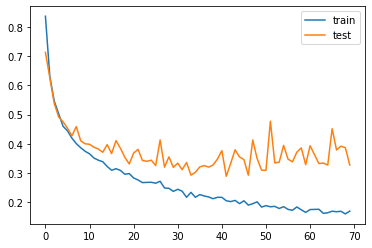

In [294]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Bidirectional Lstm Score = 0.21

#### Epoch 00007: val_loss improved from 0.73087 to 0.73061, saving model to best_model4.hdf5
#### 124/124 [==============================] - 5s 41ms/step - loss: 0.6137 - accuracy: 0.7664 - val_loss: 0.7306 - val_accuracy:
#### Bidirectional LSTM gives 72.65% accuracy

## CNN

In [266]:
modelcnn = Sequential()
modelcnn.add(layers.Embedding(max_words, 40, input_length=max_len))
modelcnn.add(Conv1D(64, 3, activation='relu',padding='same'))
modelcnn.add(Conv1D(32, 3, activation='relu', padding='same'))
modelcnn.add(Conv1D(16, 3, activation='relu', padding='same'))
modelcnn.add(Flatten())
modelcnn.add(Dropout(0.2))
modelcnn.add(Dense(180,activation='softmax'))
modelcnn.add(Dropout(0.2))
modelcnn.add(Dense(1,activation='softmax'))
modelcnn.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
checkpointcnn = ModelCheckpoint("best_modelcnn_a.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='min', period=1,save_weights_only=False)
historycnn = modelcnn.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpointcnn])

Epoch 1/70
194/194 [==============================] - ETA: 0s - loss: 0.0000e+00 - acc: 0.4619
Epoch 00001: val_loss improved from inf to 0.00000, saving model to best_modelcnn_a.hdf5
194/194 [==============================] - 2s 12ms/step - loss: 0.0000e+00 - acc: 0.4619 - val_loss: 0.0000e+00 - val_acc: 0.4649
Epoch 2/70
187/194 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - acc: 0.4611
Epoch 00002: val_loss did not improve from 0.00000
194/194 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - acc: 0.4619 - val_loss: 0.0000e+00 - val_acc: 0.4649
Epoch 3/70
190/194 [============================>.] - ETA: 0s - loss: 0.0000e+00 - acc: 0.4607
Epoch 00003: val_loss did not improve from 0.00000
194/194 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - acc: 0.4619 - val_loss: 0.0000e+00 - val_acc: 0.4649
Epoch 4/70
191/194 [============================>.] - ETA: 0s - loss: 0.0000e+00 - acc: 0.4625
Epoch 00004: val_loss did not improve fro

Epoch 60/70
182/194 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - acc: 0.4626
Epoch 00060: val_loss did not improve from 0.00000
194/194 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - acc: 0.4619 - val_loss: 0.0000e+00 - val_acc: 0.4649
Epoch 61/70
183/194 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - acc: 0.4623
Epoch 00061: val_loss did not improve from 0.00000
194/194 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - acc: 0.4619 - val_loss: 0.0000e+00 - val_acc: 0.4649
Epoch 62/70
186/194 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - acc: 0.4620
Epoch 00062: val_loss did not improve from 0.00000
194/194 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - acc: 0.4619 - val_loss: 0.0000e+00 - val_acc: 0.4649
Epoch 63/70
186/194 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - acc: 0.4647
Epoch 00063: val_loss did not improve from 0.00000
194/194 [================

In [268]:
#Splitting the data
#max_words = 2000
X_train, X_test, y_train, y_test = train_test_split(comments,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

6200 2067 6200 2067


In [271]:
y_trn = y_train
y_trn=to_categorical(y_trn,num_classes=3)
y_vall = y_test
y_vall=to_categorical(y_vall,num_classes=3)

In [270]:
y_train.shape

(6200,)

In [272]:
#max_words = 2000
from keras import regularizers
modelcnn = Sequential()
modelcnn.add(layers.Embedding(max_words, 40, input_length=max_len))
modelcnn.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
modelcnn.add(layers.MaxPooling1D(5))
modelcnn.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
modelcnn.add(layers.GlobalMaxPooling1D())
modelcnn.add(layers.Dense(3,activation='softmax'))
modelcnn.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
checkpointcnn = ModelCheckpoint("best_modelcnn.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='min', period=1,save_weights_only=False)
historycnn = modelcnn.fit(X_train, y_trn, epochs=70,validation_data=(X_test, y_vall),callbacks=[checkpointcnn])

Epoch 1/70
194/194 [==============================] - ETA: 0s - loss: 1.2344 - acc: 0.4852
Epoch 00001: val_loss improved from inf to 0.98790, saving model to best_modelcnn.hdf5
194/194 [==============================] - 1s 7ms/step - loss: 1.2344 - acc: 0.4852 - val_loss: 0.9879 - val_acc: 0.4649
Epoch 2/70
191/194 [============================>.] - ETA: 0s - loss: 0.9481 - acc: 0.5198
Epoch 00002: val_loss improved from 0.98790 to 0.94085, saving model to best_modelcnn.hdf5
194/194 [==============================] - 1s 5ms/step - loss: 0.9475 - acc: 0.5190 - val_loss: 0.9408 - val_acc: 0.6381
Epoch 3/70
184/194 [===========================>..] - ETA: 0s - loss: 0.9035 - acc: 0.6420
Epoch 00003: val_loss improved from 0.94085 to 0.87546, saving model to best_modelcnn.hdf5
194/194 [==============================] - 1s 5ms/step - loss: 0.8986 - acc: 0.6469 - val_loss: 0.8755 - val_acc: 0.6734
Epoch 4/70
190/194 [============================>.] - ETA: 0s - loss: 0.7984 - acc: 0.7334
Epoc

Epoch 28/70
183/194 [===========================>..] - ETA: 0s - loss: 0.2567 - acc: 0.9529
Epoch 00028: val_loss did not improve from 0.36339
194/194 [==============================] - 1s 5ms/step - loss: 0.2566 - acc: 0.9529 - val_loss: 0.3677 - val_acc: 0.9115
Epoch 29/70
190/194 [============================>.] - ETA: 0s - loss: 0.2501 - acc: 0.9544
Epoch 00029: val_loss improved from 0.36339 to 0.35656, saving model to best_modelcnn.hdf5
194/194 [==============================] - 1s 5ms/step - loss: 0.2506 - acc: 0.9545 - val_loss: 0.3566 - val_acc: 0.9158
Epoch 30/70
193/194 [============================>.] - ETA: 0s - loss: 0.2441 - acc: 0.9568
Epoch 00030: val_loss did not improve from 0.35656
194/194 [==============================] - 1s 6ms/step - loss: 0.2446 - acc: 0.9565 - val_loss: 0.3613 - val_acc: 0.9100
Epoch 31/70
188/194 [============================>.] - ETA: 0s - loss: 0.2390 - acc: 0.9599
Epoch 00031: val_loss improved from 0.35656 to 0.35572, saving model to best

Epoch 57/70
182/194 [===========================>..] - ETA: 0s - loss: 0.1406 - acc: 0.9895
Epoch 00057: val_loss did not improve from 0.28473
194/194 [==============================] - 1s 5ms/step - loss: 0.1398 - acc: 0.9898 - val_loss: 0.2848 - val_acc: 0.9381
Epoch 58/70
193/194 [============================>.] - ETA: 0s - loss: 0.1375 - acc: 0.9898
Epoch 00058: val_loss improved from 0.28473 to 0.28365, saving model to best_modelcnn.hdf5
194/194 [==============================] - 1s 6ms/step - loss: 0.1374 - acc: 0.9898 - val_loss: 0.2836 - val_acc: 0.9352
Epoch 59/70
186/194 [===========================>..] - ETA: 0s - loss: 0.1344 - acc: 0.9908
Epoch 00059: val_loss did not improve from 0.28365
194/194 [==============================] - 1s 5ms/step - loss: 0.1354 - acc: 0.9905 - val_loss: 0.2911 - val_acc: 0.9366
Epoch 60/70
190/194 [============================>.] - ETA: 0s - loss: 0.1338 - acc: 0.9901
Epoch 00060: val_loss did not improve from 0.28365
194/194 [================

In [274]:
import keras
modelcnn = keras.models.load_model('best_modelcnn.hdf5')

In [295]:
y_predCnn=modelcnn.predict_classes(np.array(X_test))
y_trueCnn = np.argmax(y_vall, axis=1)
#print(classification_report(y_true,y_pred))

In [296]:
# Computing Model Accuracy
print("================================== CNN ==================================")
print("Accuracy:",round(accuracy_score(y_trueCnn, y_predCnn),2) * 100, "%")

print ("---------------")

print ("Confusion matrix")

print ("---------------")
print(confusion_matrix(y_trueCnn, y_predCnn))


# User specific target names   
    
target_names = ['Sentiment0', 'Sentiment1', 'Sentiment2']

# Model detailed classification report

print ("---------------")
print("Classification report", classification_report(y_trueCnn, y_predCnn,target_names =target_names))

================================== CNN ==================================
Accuracy: 94.0 %
---------------
Confusion matrix
---------------
[[934   0   8]
 [  1 934  26]
 [ 36  50  78]]
---------------
Classification report               precision    recall  f1-score   support

  Sentiment0       0.96      0.99      0.98       942
  Sentiment1       0.95      0.97      0.96       961
  Sentiment2       0.70      0.48      0.57       164

    accuracy                           0.94      2067
   macro avg       0.87      0.81      0.83      2067
weighted avg       0.93      0.94      0.94      2067



In [297]:
print("F1-score macro = ",(round(f1_score(y_trueCnn, y_predCnn,average='macro'),2))*100,"%")
print("F1-score micro = ",(round(f1_score(y_trueCnn, y_predCnn,average='micro'),2))*100,"%")
print("F1-score weighted = ",(round(f1_score(y_trueCnn, y_predCnn,average='weighted'),2))*100,"%")

F1-score macro =  83.0 %
F1-score micro =  94.0 %
F1-score weighted =  94.0 %


In [298]:
predictionsTestCnn = modelcnn.predict_classes(commentsTest)
predictionsTestCnn

array([0, 2, 0, ..., 2, 2, 1], dtype=int64)

In [299]:
dfinalCnn = pd.DataFrame(columns=['id','sentiment'])
dfinalCnn['id'] = test['unique_hash']
dfinalCnn['sentiment'] = predictionsTestCnn
dfinalCnn['sentiment'].value_counts()

2    1529
0     746
1     649
Name: sentiment, dtype: int64

In [300]:
dfinalCnn.head(1)

id  sentiment
0  9e9a8166b84114aca147bf409f6f956635034c08          0

In [301]:
dfinalCnn.to_csv("sample_submision_finalCnn.csv",index=0)

### CNN score 0.33

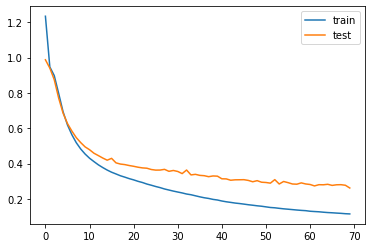

In [293]:
from matplotlib import pyplot
pyplot.plot(historycnn.history['loss'], label='train')
pyplot.plot(historycnn.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#### Epoch 00009: val_loss improved from 0.79369 to 0.78688, saving model to best_model3.hdf5
#### 124/124 [==============================] - 1s 7ms/step - loss: 0.7515 - acc: 0.7252 - val_loss: 0.7869 - val_acc: 0.7227
#### Simple CNN gives 72.27% accuracy

## Results

In [161]:
modelLstm = load_model('best_model1l.hdf5')

In [162]:
y_pred=modelLstm.predict_classes(np.array(X_test))
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.01      0.02       161
           1       0.41      0.12      0.18       205
           2       0.74      0.97      0.84       954

    accuracy                           0.72      1320
   macro avg       0.72      0.37      0.35      1320
weighted avg       0.72      0.72      0.64      1320



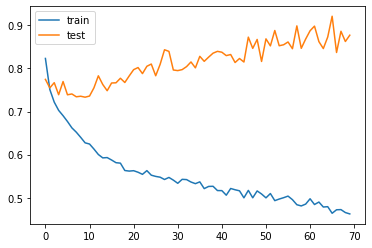

In [165]:
pyplot.plot(history1l.history['loss'], label='train')
pyplot.plot(history1l.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

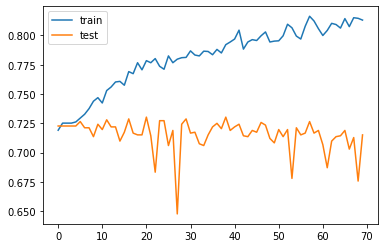

In [166]:
pyplot.plot(history1l.history['accuracy'], label='train')
pyplot.plot(history1l.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [167]:
#Let's load the best model obtained during training
import keras
best_model = keras.models.load_model("best_model1l.hdf5")

In [180]:
best_model1 = keras.models.load_model("best_model1.hdf5")

In [168]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

42/42 - 0s - loss: 0.7332 - accuracy: 0.7242
Model accuracy:  0.7242424488067627


In [169]:
predictions = best_model.predict(commentsTest)
predictions

array([[0.19387242, 0.10487865, 0.70124894],
       [0.15551335, 0.11231567, 0.73217106],
       [0.17610504, 0.16450714, 0.6593878 ],
       ...,
       [0.04788493, 0.05252545, 0.89958966],
       [0.19292988, 0.2912794 , 0.51579076],
       [0.05219607, 0.05779565, 0.89000833]], dtype=float32)

In [170]:
print(commentsTest.shape)

(2924, 200)


In [181]:
y_pred1 = best_model1.predict_classes(commentsTest)
print(y_pred1)
print(y_pred1.shape)

[2 2 2 ... 2 2 2]
(2924,)


In [171]:
y_pred = best_model.predict_classes(commentsTest)
print(y_pred)
print(y_pred.shape)

[2 2 2 ... 2 2 2]
(2924,)


In [53]:
y_pred=best_model.predict_classes(X_test)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       161
           1       0.42      0.21      0.28       205
           2       0.75      0.96      0.84       954

    accuracy                           0.73      1320
   macro avg       0.39      0.39      0.38      1320
weighted avg       0.61      0.73      0.65      1320



C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harshitta\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [175]:
finaldf = pd.DataFrame()
finaldf['id'] = test['unique_hash']
finaldf['sentiment'] = y_pred

#finaldf.to_csv('C:\Users\Harshitta\AnalyticsVidhya\CertifiedAlMiBlackbelt\final\test.csv')

In [183]:
finaldf1 = pd.DataFrame()
finaldf1['id'] = test['unique_hash']
finaldf1['sentiment'] = y_pred1

#finaldf.to_csv('C:\Users\Harshitta\AnalyticsVidhya\CertifiedAlMiBlackbelt\final\test.csv')

In [184]:
finaldf1['sentiment'].value_counts()

2    2890
1      31
0       3
Name: sentiment, dtype: int64

In [130]:
test['text'].shape

(2924,)

In [176]:
y_pred.shape

(2924,)

In [179]:
finaldf['sentiment'].value_counts()

2    2886
1      37
0       1
Name: sentiment, dtype: int64

In [ ]:
trainx, valx, trainy, valy = train_test_split(trainMeta, train['sentiment'],test_size=0.2, random_state=42)
modelXg = xgboost.XGBClassifier()
modelXg.fit(trainx, trainy)
predsXg = modelXg.predict(valx)
accuracy_score(predsXg, valy)

In [219]:
predTestXg = modelXg.predict(testMeta)
predTestXg

ValueError: Feature shape mismatch, expected: 35093, got 26410

In [218]:
print(testMeta)

  (0, 8712)	0.4384496515394141
  (0, 15914)	0.5004761201278126
  (0, 19000)	0.45334250147118904
  (0, 22435)	0.4282765898846932
  (0, 23123)	0.4102990313946171
  (0, 26405)	5.0
  (0, 26406)	72.0
  (0, 26407)	63.0
  (0, 26408)	2.0
  (0, 26409)	3.0
  (1, 2944)	0.19486134476560285
  (1, 6130)	0.3209370626568552
  (1, 6365)	0.3102748150461544
  (1, 7073)	0.6968191490190885
  (1, 8552)	0.1972392597567365
  (1, 8712)	0.2830739001357157
  (1, 13675)	0.169387114730352
  (1, 21829)	0.18456378311058824
  (1, 25674)	0.21680072175138923
  (1, 25980)	0.22001948705875846
  (1, 26405)	11.0
  (1, 26406)	146.0
  (1, 26407)	120.0
  (1, 26408)	5.0
  (1, 26409)	6.0
  :	:
  (2923, 16025)	0.08081497617770825
  (2923, 16175)	0.12311282500430554
  (2923, 16757)	0.1218317337333136
  (2923, 19654)	0.2531407723047765
  (2923, 19760)	0.09368657907774323
  (2923, 19788)	0.17990772177168055
  (2923, 19886)	0.11059330348183995
  (2923, 20627)	0.09649449048266902
  (2923, 20882)	0.1371778417393156
  (2923, 21091)	0.2

In [215]:
print(valx)

  (0, 86)	0.3470329419095809
  (0, 1401)	0.20434061889827082
  (0, 2486)	0.26338473600166057
  (0, 3263)	0.20696487525261695
  (0, 10388)	0.18603321413565385
  (0, 10508)	0.155446785188842
  (0, 10531)	0.14757681228745087
  (0, 10535)	0.1757538139632029
  (0, 10960)	0.14583417280099922
  (0, 12006)	0.18014439541084218
  (0, 12723)	0.15170821393084433
  (0, 14020)	0.3449503207145422
  (0, 19773)	0.24990604618601825
  (0, 21216)	0.27387030021977377
  (0, 23467)	0.09116850369992797
  (0, 25297)	0.2866089433004789
  (0, 26444)	0.28039989949573
  (0, 30031)	0.22200724310974326
  (0, 31477)	0.09130905307186922
  (0, 32295)	0.20548359145693168
  (0, 33961)	0.10979276640866188
  (0, 35088)	24.0
  (0, 35089)	296.0
  (0, 35090)	247.0
  (0, 35091)	14.0
  :	:
  (1055, 27479)	0.0929080923290014
  (1055, 27868)	0.05408253918131604
  (1055, 28189)	0.05409947859732372
  (1055, 28235)	0.13302294820476382
  (1055, 28413)	0.08743322299926681
  (1055, 28786)	0.060001123387403606
  (1055, 29382)	0.09173841